In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
# Phần code này dựa trên bài viết này
# https://www.sciencedirect.com/science/article/pii/S1877050919302789

# Import the libraries

In [3]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, LeakyReLU, Flatten
import time
import datetime

from tensorflow.keras.layers import Lambda

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr

In [4]:
# Hàm vẽ mô hình miêu tả giá trị từng thuộc tính
def plot_dataframe(df):
  for column_name in df.columns:
    plt.figure()
    plt.title(column_name)
    plt.plot(df[column_name])

# Preprocessing

In [5]:
# Hàm thêm cột giá trị Ma, là đường trung bình động (Moving Average) của biến giá trị Close
def add_Ma(df, window=5):
    for i in range(window, df.shape[0]):
        sum = 0.0
        for k in range(1, window+1):
            sum += df.iloc[i-k, 4]
        df.loc[df.index[i], 'Ma'] = np.round(sum/window, 6)
    return df[window:]

In [6]:
# Class này kế thừa class TimeseriesGenerator
# Nó tạo ra các batch dữ liệu được chuẩn hóa (standarized)
class Standarized_TimeseriesGenerator(tf.keras.preprocessing.sequence.TimeseriesGenerator):
  def __getitem__(self, index):
    samples, targets  = super(Standarized_TimeseriesGenerator, self).__getitem__(index)
    mean = samples.mean(axis=1)
    std = samples.std(axis=1)
    samples = (samples - mean[:,None,:])/std[:,None,:]
    targets = (targets - mean)/std
    return samples, targets

In [7]:
# Giải thích các thông số đầu vào của class TimeseriesGenerator
# Data: Những dữ liệu liên tiếp nhau (axis 0 được kì vọng là time dimension)
# Target: Dữ liệu tương ứng với những timesteps trong data
# Length: Độ dài của các sequences đầu vào (Hay window, look-back)
# sampling_rate: Chu kỳ của các timestep input được lấy (VD: sampling_rate=2 
# thì cách 2 ngày lấy một lần)
# stride: Chu kỳ của các timestep output được lấy (VD: stride=2 
# thì cách 2 ngày lấy một lần, hay chú Sơn nói là số bước mà cửa sổ trượt)
# start_index, end_index: Khoảng dữ liệu được dùng
# bacth_size: số lượng samples 1 batch
# ([day1, day2, day3],[day4]) là 1 sample
# [([day1, day2, day3],[day4]), ([day2, day3, day4],[day5])] là 1 batch có 
# batch_size là 5
################Xét ví dụ sau############
# from keras.preprocessing.sequence import TimeseriesGenerator
# import numpy as np
# data = np.array([[i] for i in range(50)])
# targets = np.array([[i] for i in range(50)])
# data_gen = TimeseriesGenerator(data, targets,
#                                length=10, sampling_rate=2,
#                                batch_size=2)
# assert len(data_gen) == 20
# batch_0 = data_gen[0]
# x, y = batch_0
# assert np.array_equal(x,
#                       np.array([[[0], [2], [4], [6], [8]],
#                                 [[1], [3], [5], [7], [9]]]))
# assert np.array_equal(y,
#                       np.array([[10], [11]]))
# ==>length=10 nên những dữ liệu được pick cho input có index 0->9
# Và dữ liệu đầu tiên cho output có index là 10
# sampling_rate bằng 2 nên (index thứ i) - (index thứ i - 1) = 2
# Batch_size=2 --> Mỗi batch có 2 sample mà có 41 samples --> Có 21 batches

def get_gen_train_test(dataframe, n_sequence, n_batch):
    data = dataframe.drop(columns='Date').to_numpy()
    targets = data
    n_samples = data.shape[0]
    train_test_split=int(n_samples*0.9)

    data_gen_train = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = 0,
                                end_index = train_test_split,
                                shuffle = True)
    data_gen_test = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = train_test_split,
                                end_index = n_samples-1)

    return data_gen_train, data_gen_test

# Baseline

In [8]:
# Hàm dùng để tính mean squared error cho generated data
def mean_squared_error(dataset):
    mse=0
    for X_batch, y_batch in dataset:
        mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch[:, 3:4]))
    mse /= len(dataset)
    return mse

# Utilities

In [9]:
# Các hàm tính metrics từ 2 tập thực tế và dự đoán.
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3]))
def mae(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])))
    # ***The absolute is over the whole thing as y_true can be negative
def mape(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])/y_true[:,3]))
    # ***The absolute is over the whole thing as y_true can be negative
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3])))
def ar(y_true, y_pred):
    mask = tf.cast(y_pred[1:,3] > y_true[:-1,3],tf.float32)
    return tf.reduce_mean((y_true[1:,3]-y_true[:-1,3])*mask)

# GAN

## Perdidas

In [10]:
# Vì Discriminator trong bài toán này chỉ có hai giá trị đầu ra (giống/ không giống) nên dùng hàm phân loại nhị phân
# Tìm hiểu Binary Cross Entropy là gì tại đây:
# https://ndquy.github.io/posts/loss-function-p2/#:~:text=Binary%20Cross%2DEntropy%20Loss,tr%E1%BB%8B%20%7B0%2C%201%7D.
# Cross-entropy là hàm loss được sử dụng mặc định cho bài toán phân lớp nhị phân.
# Nó được thiết kế để sử dụng với bài toán phân loại nhị phân trong đó các giá trị mục tiêu nhận một trong 2 giá trị {0, 1}.
# Trang 402
def discriminator_loss(real_output, fake_output):
    # So sách kết quả dự đoán như thể nào với 1 (đúng) (real_loss)
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    # So sách kết quả dự đoán như thể nào với 1 (đúng) (real_loss)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    # Giá trị mất mát của Generator
    total_loss = real_loss + fake_loss
    return total_loss
# https://www.sciencedirect.com/science/article/pii/S1877050919302789
# Trang 403
def generator_loss(x, y, fake_output):
    a1=0.01
    g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
    g_mse = tf.keras.losses.MSE(x, y)
    return a1*g_mse + (1-a1)*g_loss, g_mse


## Generator

In [11]:
def make_generator_model(n_sequence, n_features):
    inputs = Input(shape=(n_sequence, n_features,))
    # return_sequences = True, Trả về cho lớp sau các điểm đầu ra trước đó thay vì chỉ các điểm đầu ra ở lớp cuối cùng
    # Trong mạng neural học sâu, kernel_initializer là một tham số được sử dụng để khởi tạo trọng số (weights) của các lớp (layer) trong mạng neural.
    lstm_1 = LSTM(units=10, return_sequences = True, activation=None, kernel_initializer='random_normal')(inputs)
    # Batch Normalization là một lớp (layer) được sử dụng trong mạng neural học sâu để chuẩn hóa đầu ra của một lớp trước khi đưa vào lớp kế tiếp
    # Cải thiện "vanishing gradient" và "exploding gradient", đồng thời giúp mô hình hội tụ nhanh hơn
    batch_norm1=tf.keras.layers.BatchNormalization()(lstm_1)
    lstm_1_LRelu = LeakyReLU(alpha=0.3)(batch_norm1) 
    lstm_1_droput = Dropout(0.3)(lstm_1_LRelu)
    lstm_2 = LSTM(units=10, return_sequences = False, activation=None, kernel_initializer='random_normal')(lstm_1_droput)
    batch_norm2=tf.keras.layers.BatchNormalization()(lstm_2)
    lstm_2_LRelu = LeakyReLU(alpha=0.3)(batch_norm2) 
    lstm_2_droput = Dropout(0.3)(lstm_2_LRelu)
    output_dense = Dense(n_features, activation=None)(lstm_2_droput)
    #  LeakyReLU
    # https://aicurious.io/blog/2019-09-23-cac-ham-kich-hoat-activation-function-trong-neural-networks
    output = LeakyReLU(alpha=0.3)(output_dense) 

    model = Model(inputs = inputs, outputs = output)
    model.compile(loss=None, metrics = [mse , mae, mape, rmse, ar])
    model.summary()

    return model
# Vì sao cần hàm kích hoạt, vì nếu có hàm kích hoạt mà là các lớp nơ ron đơn thuần xếp chồng lên nhau thì kết quả đầu ra đơn 
# là một hàm tuyến tính của giá trị đầu vào --> Việc xếp chồng mà k có hàm kích hoạt là vô nghĩa
# Sigmoid (0,1). Đạo hàm đẹp nhưng dễ bằng 0 (vanishing gradient), không có trung tâm nên hội tụ khó khăn
# tanh (-1,1). Cũng bão hòa hai đầu nhưng có trung tâm (O)
# ReLu max(0, x): Sử dụng khá nhiều gần đây do tốc độ hội tụ nhanh do nó k bị bão hòa 2 đầu
# --> Rectified Linear Unit: đơn vị tuyến tính được hiệu chỉnh
# Tính toán nhanh dO công thức đơn giản
# Nhược điểm là với những node < 0 thù activation chuyển thành 0 (Dying ReLU) (*)
# Leaky ReLU dùng để khắc phục ReLU
# LeakyReLU: f(x) = 1 với x<0 và f(x)=ax + 1 với x>=0 với a nhỏ
# Thay vì trả về 0 với x < 0 thì nó cố gắng tạo ra một đường xiên nhỏ



## Discriminator

In [12]:
def make_discriminator_model(n_features):
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(units=72, input_shape=((n_sequence+1) * n_features,), activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    # là một lớp sinh dữ liệu ngẫu nhiên nhằm giảm thiểu overfit
    model.add(tf.keras.layers.GaussianNoise(stddev=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(units=100, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(units=10, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(1 ,activation='sigmoid'))
    model.compile(loss=discriminator_loss)
    return model

# Training

In [13]:
def train_step_def(sequences, sequences_end):
    # GradientTape trả về  Context Manager, quản lý quan sát các thay đổi của mô hình và cập nhật lại trọng số
    # Nó theo dõi các quá trình tính toán của mô hình trong quá trình lan truyền thuận và cập nhật trong quá trình lan truyền ngược
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Giải thích training=True 
        # https://stackoverflow.com/questions/57320371/what-does-training-true-mean-when-calling-a-tensorflow-keras-model
        generated_prediction = generator(sequences, training=True)
        # None là cách tăng dimension. VD: [1,2,3] --> [[1],[2],[3]]
        sequences_true = tf.concat((sequences, sequences_end[:, None, :]), axis=1)
        sequences_fake = tf.concat((sequences, generated_prediction[:, None, :]), axis=1)

        real_output = discriminator(sequences_true, training=True)
        fake_output = discriminator(sequences_fake, training=True)

        gen_loss, gen_mse_loss = generator_loss(generated_prediction, 
                                                sequences_end, 
                                                fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

def test_step_def(sequences, sequences_end):
    generated_prediction = generator(sequences, training=False)

    sequences_true = tf.concat((sequences, sequences_end[:,None,:]), axis=1)
    sequences_fake = tf.concat((sequences, generated_prediction[:,None,:]), axis=1)

    real_output = discriminator(sequences_true, training=False)
    fake_output = discriminator(sequences_fake, training=False)

    gen_loss, gen_mse_loss = generator_loss(generated_prediction, sequences_end, fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

In [14]:
def train(dataset, dataset_val, epochs):
    # Biến history (training) và history_val (testing) lưu các thông số liên quan đến mse, rmse, mae, mape để vẽ đồ thị ở bước sau
    history = np.empty(shape = (8, epochs))
    history_val = np.empty(shape = (8, epochs))
    len_dataset = len(dataset)
    len_dataset_val = len(dataset_val)
    for epoch in range(epochs):
        start = time.time()

        cur_dis_loss = 0
        cur_gen_loss = 0
        cur_gen_mse_loss = 0
        # Với mỗi batch
        for sequence_batch, sequence_end_batch in dataset:
            # Tiến hành train, cập nhật weight bằng Gradient Tape cho hai mô hình G và D
            aux_cur_losses = train_step(tf.cast(sequence_batch, tf.float32), 
                                      tf.cast(sequence_end_batch, tf.float32))
            # lấy ra giá trị của các loss function 
            cur_gen_loss += aux_cur_losses[0]/len_dataset
            cur_dis_loss += aux_cur_losses[1]/len_dataset
            cur_gen_mse_loss += aux_cur_losses[2]/len_dataset
        # Verbose là dài dòng, verbose=False có nghĩa là không xuất ra giá trị cụ thể
        cur_gen_metrics = generator.evaluate(dataset,verbose=False)[1:]

        #Lưu các thông số vào biến history
        history[:, epoch] = cur_gen_loss, cur_dis_loss, cur_gen_mse_loss, *cur_gen_metrics

        cur_gen_metrics_val = generator.evaluate(dataset_val,verbose=False)[1: ]

        cur_gen_loss_val = 0
        cur_dis_loss_val = 0
        cur_gen_mse_loss_val = 0
        for sequence_batch, sequence_end_batch in dataset_val:
            aux_cur_losses_val = test_step(tf.cast(sequence_batch, tf.float32), 
                                         tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss_val += aux_cur_losses_val[0]/len_dataset_val
            cur_dis_loss_val += aux_cur_losses_val[1]/len_dataset_val
            cur_gen_mse_loss_val += aux_cur_losses_val[2]/len_dataset_val
    


        history_val[:, epoch] = cur_gen_loss_val, cur_dis_loss_val, cur_gen_mse_loss_val, *cur_gen_metrics_val

        print ('Time for epoch {} is {} sec Generator Loss: {},  Discriminator_loss: {}'
               .format(epoch + 1, time.time()-start, cur_gen_loss, cur_dis_loss))

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

    return history, history_val

## Visualization

In [15]:
def plot_history(history, history_val):
    metrics = ["gen_loss","dis_loss","gen_mse_loss", 'mse','mae','mape','rmse','ar']
    for i, metric_name in enumerate(metrics):  
        plt.figure()
        plt.title(metric_name)
        plt.plot(history[i], label='train')
        plt.plot(history_val[i], label='test')
        plt.legend()
    plt.show()

In [16]:
def plot_frame(sequence, target, model):
    y_pred = model.predict(sequence)[...,3]
    y_true = target[...,3]

    plt.figure()
    plt.title("closing price")
    plt.plot(y_true, label="true")
    plt.plot(y_pred, label="prediction")
    plt.legend()
    plt.show()

In [17]:
def get_best_results(history):
    min_index = np.argmin(history[3, :])
    return history[:, min_index]

## Variables

In [18]:
window = 5
n_sequence = window
n_features = 7
n_batch = 50

## Data loading

In [19]:
stock_code = "IBM"
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2020, 12, 31)
raw_data = pdr.get_data_yahoo(stock_code, start, end,threads=False, proxy="http://127.0.0.1:7890")
df = raw_data.dropna();
df = df.reset_index(level=0)
df = add_Ma(df, window)
df

[*********************100%***********************]  1 of 1 completed


Date        Open        High         Low       Close   Adj Close  \
5    2000-01-10  112.093689  114.125237  110.301147  112.810707   64.370781   
6    2000-01-11  112.691208  115.798279  111.496178  113.766731   64.916306   
7    2000-01-12  114.364243  116.634796  113.049713  114.244743   65.189049   
8    2000-01-13  114.663002  115.678780  110.659653  113.049713   64.507141   
9    2000-01-14  115.619026  117.889580  112.332695  114.364243   65.257248   
...         ...         ...         ...         ...         ...         ...   
5278 2020-12-23  118.432121  119.703636  118.298279  118.451241  106.144394   
5279 2020-12-24  119.502869  119.598473  118.747612  119.206497  106.821190   
5280 2020-12-28  119.598473  121.032501  118.986618  119.330788  106.932564   
5281 2020-12-29  119.837479  119.961761  117.820267  118.355644  106.058739   
5282 2020-12-30  118.355644  119.359467  118.193115  118.871895  106.521347   

        Volume          Ma  
5      8933363  109.285373  
6      8235472  109.667783  
7      7116775  110.994264  
8      8880226  111.663481  
9     11460604  112.476100  
...        ...         ...  
5278   2817819  119.302103  
5279   1842111  118.986615  
5280   3781499  118.822179  
5281   3647402  118.625238  
5282   3535794  118.703633  

[5278 rows x 8 columns]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 lstm (LSTM)                 (None, 5, 10)             720       
                                                                 
 batch_normalization (BatchN  (None, 5, 10)            40        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5, 10)             0         
                                                                 
 dropout (Dropout)           (None, 5, 10)             0         
                                                                 
 lstm_1 (LSTM)               (None, 10)                840       
                                                             

Time for epoch 53 is 0.8178744316101074 sec Generator Loss: 1.0088900327682495,  Discriminator_loss: 1.1944701671600342
Time for epoch 54 is 0.8116562366485596 sec Generator Loss: 0.9970511198043823,  Discriminator_loss: 1.1988232135772705
Time for epoch 55 is 0.8098242282867432 sec Generator Loss: 0.9900913238525391,  Discriminator_loss: 1.2129420042037964
Time for epoch 56 is 0.8161678314208984 sec Generator Loss: 0.9852651357650757,  Discriminator_loss: 1.227299690246582
Time for epoch 57 is 0.819608211517334 sec Generator Loss: 0.9895515441894531,  Discriminator_loss: 1.2218170166015625
Time for epoch 58 is 0.8211512565612793 sec Generator Loss: 0.9620249271392822,  Discriminator_loss: 1.2338117361068726
Time for epoch 59 is 0.806776762008667 sec Generator Loss: 0.9730759263038635,  Discriminator_loss: 1.2228343486785889
Time for epoch 60 is 0.8049943447113037 sec Generator Loss: 0.9633820652961731,  Discriminator_loss: 1.250967264175415
Time for epoch 61 is 0.804948091506958 sec G

Time for epoch 122 is 0.9607086181640625 sec Generator Loss: 0.8573010563850403,  Discriminator_loss: 1.321423888206482
Time for epoch 123 is 0.970710277557373 sec Generator Loss: 0.8478928804397583,  Discriminator_loss: 1.3154670000076294
Time for epoch 124 is 0.8820528984069824 sec Generator Loss: 0.8521912097930908,  Discriminator_loss: 1.3152376413345337
Time for epoch 125 is 0.8862924575805664 sec Generator Loss: 0.8409712910652161,  Discriminator_loss: 1.3097378015518188
Time for epoch 126 is 0.851752758026123 sec Generator Loss: 0.848052978515625,  Discriminator_loss: 1.3261264562606812
Time for epoch 127 is 0.8198051452636719 sec Generator Loss: 0.8470165729522705,  Discriminator_loss: 1.3087611198425293
Time for epoch 128 is 0.8165013790130615 sec Generator Loss: 0.8518743515014648,  Discriminator_loss: 1.3155792951583862
Time for epoch 129 is 0.783543586730957 sec Generator Loss: 0.8521434664726257,  Discriminator_loss: 1.3233636617660522
Time for epoch 130 is 0.7872407436370

Time for epoch 191 is 0.7662549018859863 sec Generator Loss: 0.8424250483512878,  Discriminator_loss: 1.3136788606643677
Time for epoch 192 is 0.8043701648712158 sec Generator Loss: 0.8477391600608826,  Discriminator_loss: 1.3173376321792603
Time for epoch 193 is 0.7659933567047119 sec Generator Loss: 0.8511456251144409,  Discriminator_loss: 1.308583378791809
Time for epoch 194 is 0.7921121120452881 sec Generator Loss: 0.835899293422699,  Discriminator_loss: 1.3264087438583374
Time for epoch 195 is 0.8080615997314453 sec Generator Loss: 0.8451792001724243,  Discriminator_loss: 1.307258129119873
Time for epoch 196 is 0.7866487503051758 sec Generator Loss: 0.8530855774879456,  Discriminator_loss: 1.3057276010513306
Time for epoch 197 is 0.7754430770874023 sec Generator Loss: 0.8395707607269287,  Discriminator_loss: 1.322380781173706
Time for epoch 198 is 0.8328821659088135 sec Generator Loss: 0.8611653447151184,  Discriminator_loss: 1.3032327890396118
Time for epoch 199 is 0.786262035369

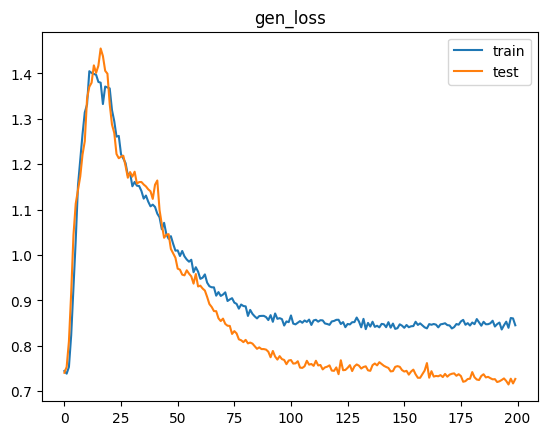

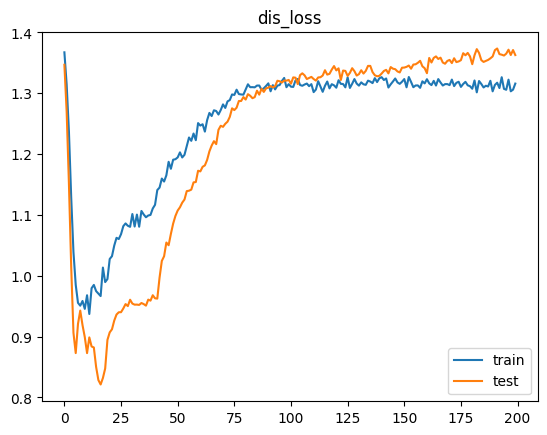

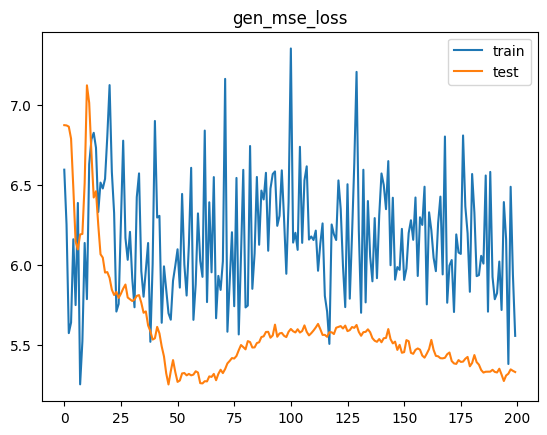

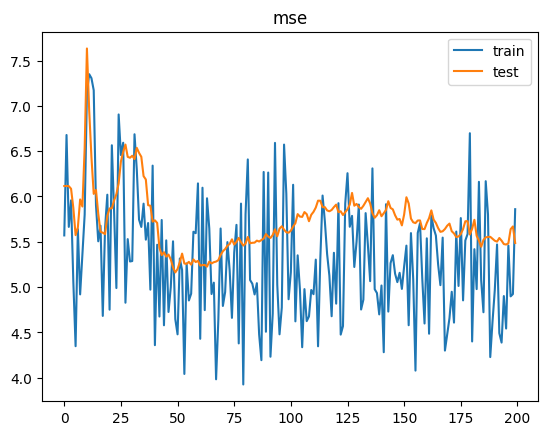

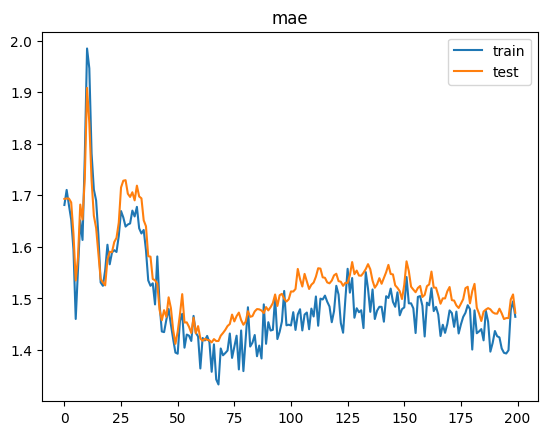

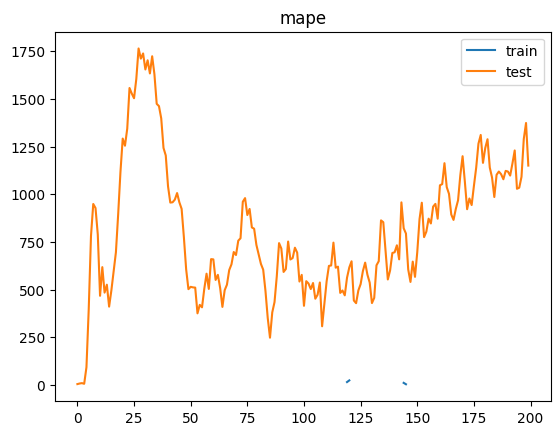

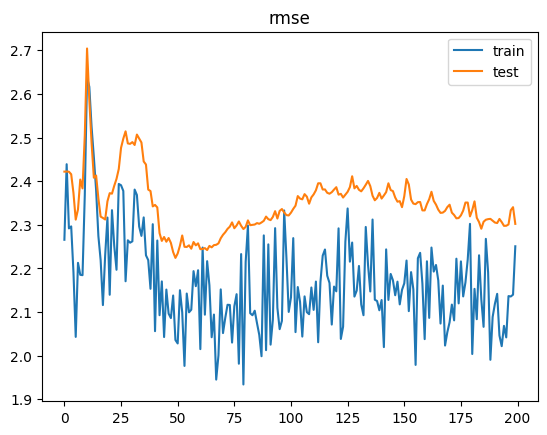

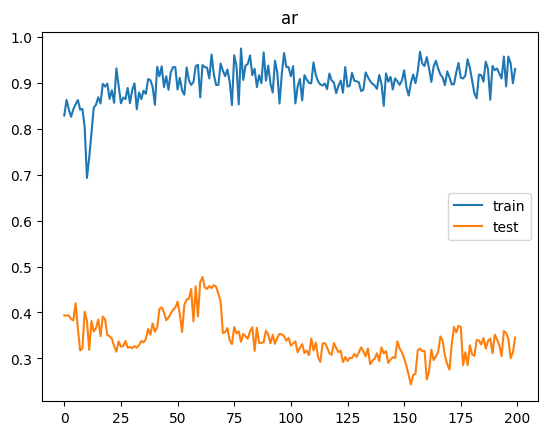

2/2 [==============================] - 0s 3ms/step


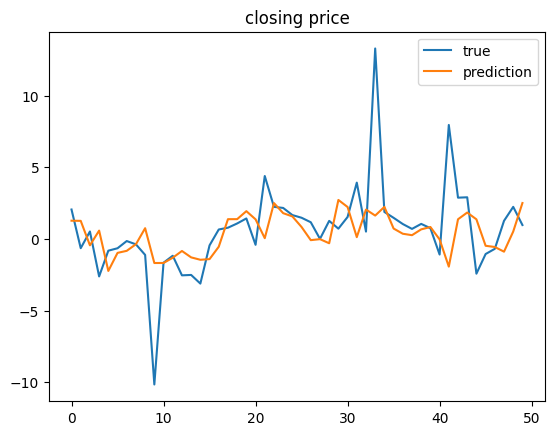

[MSE Baseline] train: 4.702320825685989  test: 4.988566607603537
Delta time with epochs = 200: 0:03:00.167879
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 lstm_2 (LSTM)               (None, 5, 10)             720       
                                                                 
 batch_normalization_2 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 5, 10)             0         
                                                                 
 dropout_5 (Dropout)         (None, 5, 10)             0         
                                                                 
 lstm_3 (LSTM) 

Time for epoch 53 is 0.7584283351898193 sec Generator Loss: 1.0777348279953003,  Discriminator_loss: 1.176937460899353
Time for epoch 54 is 0.7538299560546875 sec Generator Loss: 1.0581445693969727,  Discriminator_loss: 1.179746389389038
Time for epoch 55 is 0.7550427913665771 sec Generator Loss: 1.0479501485824585,  Discriminator_loss: 1.1855883598327637
Time for epoch 56 is 0.7569735050201416 sec Generator Loss: 1.0479878187179565,  Discriminator_loss: 1.182628870010376
Time for epoch 57 is 0.755486011505127 sec Generator Loss: 1.0417462587356567,  Discriminator_loss: 1.1745045185089111
Time for epoch 58 is 0.7524776458740234 sec Generator Loss: 1.0434199571609497,  Discriminator_loss: 1.1915132999420166
Time for epoch 59 is 0.7631580829620361 sec Generator Loss: 1.013153314590454,  Discriminator_loss: 1.2152947187423706
Time for epoch 60 is 0.754096269607544 sec Generator Loss: 1.017317533493042,  Discriminator_loss: 1.1964894533157349
Time for epoch 61 is 0.7572734355926514 sec Gen

Time for epoch 122 is 0.8593378067016602 sec Generator Loss: 0.9257171154022217,  Discriminator_loss: 1.2605892419815063
Time for epoch 123 is 0.8647394180297852 sec Generator Loss: 0.9201553463935852,  Discriminator_loss: 1.2790393829345703
Time for epoch 124 is 0.8786599636077881 sec Generator Loss: 0.9180898666381836,  Discriminator_loss: 1.2691375017166138
Time for epoch 125 is 0.8666708469390869 sec Generator Loss: 0.9230484366416931,  Discriminator_loss: 1.278821587562561
Time for epoch 126 is 0.854257345199585 sec Generator Loss: 0.9151080250740051,  Discriminator_loss: 1.2779375314712524
Time for epoch 127 is 0.9102599620819092 sec Generator Loss: 0.9146086573600769,  Discriminator_loss: 1.2745015621185303
Time for epoch 128 is 0.8568565845489502 sec Generator Loss: 0.9151984453201294,  Discriminator_loss: 1.2744685411453247
Time for epoch 129 is 0.8828740119934082 sec Generator Loss: 0.9187527298927307,  Discriminator_loss: 1.2830182313919067
Time for epoch 130 is 0.8734092712

Time for epoch 190 is 0.8642315864562988 sec Generator Loss: 0.8668476939201355,  Discriminator_loss: 1.3134164810180664
Time for epoch 191 is 0.8696587085723877 sec Generator Loss: 0.8544609546661377,  Discriminator_loss: 1.3223727941513062
Time for epoch 192 is 0.861037015914917 sec Generator Loss: 0.8652995824813843,  Discriminator_loss: 1.3122074604034424
Time for epoch 193 is 0.8701744079589844 sec Generator Loss: 0.8548268675804138,  Discriminator_loss: 1.318936824798584
Time for epoch 194 is 0.8967032432556152 sec Generator Loss: 0.8521637320518494,  Discriminator_loss: 1.320419192314148
Time for epoch 195 is 0.858957052230835 sec Generator Loss: 0.8434037566184998,  Discriminator_loss: 1.3345292806625366
Time for epoch 196 is 0.8474235534667969 sec Generator Loss: 0.8661737442016602,  Discriminator_loss: 1.3147330284118652
Time for epoch 197 is 0.8806202411651611 sec Generator Loss: 0.841875433921814,  Discriminator_loss: 1.333858847618103
Time for epoch 198 is 0.84645247459411

Time for epoch 259 is 0.8148560523986816 sec Generator Loss: 0.8340485692024231,  Discriminator_loss: 1.3299388885498047
Time for epoch 260 is 0.8249108791351318 sec Generator Loss: 0.8454799056053162,  Discriminator_loss: 1.3292531967163086
Time for epoch 261 is 0.8199491500854492 sec Generator Loss: 0.8307337164878845,  Discriminator_loss: 1.3284515142440796
Time for epoch 262 is 0.831263542175293 sec Generator Loss: 0.8427563905715942,  Discriminator_loss: 1.323494553565979
Time for epoch 263 is 0.8293054103851318 sec Generator Loss: 0.8424018025398254,  Discriminator_loss: 1.3209285736083984
Time for epoch 264 is 0.8422632217407227 sec Generator Loss: 0.8497695922851562,  Discriminator_loss: 1.3221639394760132
Time for epoch 265 is 0.8219730854034424 sec Generator Loss: 0.838895857334137,  Discriminator_loss: 1.3210535049438477
Time for epoch 266 is 0.8124899864196777 sec Generator Loss: 0.8366757035255432,  Discriminator_loss: 1.3318232297897339
Time for epoch 267 is 0.82652831077

Time for epoch 327 is 0.8464577198028564 sec Generator Loss: 0.8469629883766174,  Discriminator_loss: 1.3151415586471558
Time for epoch 328 is 0.7732944488525391 sec Generator Loss: 0.8536776304244995,  Discriminator_loss: 1.3135862350463867
Time for epoch 329 is 0.7753844261169434 sec Generator Loss: 0.8555479645729065,  Discriminator_loss: 1.3174833059310913
Time for epoch 330 is 0.8036637306213379 sec Generator Loss: 0.8517719507217407,  Discriminator_loss: 1.3116583824157715
Time for epoch 331 is 0.8212766647338867 sec Generator Loss: 0.8607253432273865,  Discriminator_loss: 1.3146346807479858
Time for epoch 332 is 0.8666636943817139 sec Generator Loss: 0.8614612817764282,  Discriminator_loss: 1.3085734844207764
Time for epoch 333 is 0.7787373065948486 sec Generator Loss: 0.8419387340545654,  Discriminator_loss: 1.324373483657837
Time for epoch 334 is 0.7877259254455566 sec Generator Loss: 0.8624157309532166,  Discriminator_loss: 1.3173319101333618
Time for epoch 335 is 0.814654588

Time for epoch 395 is 0.7521383762359619 sec Generator Loss: 0.8656634092330933,  Discriminator_loss: 1.3064733743667603
Time for epoch 396 is 0.751924991607666 sec Generator Loss: 0.8623759150505066,  Discriminator_loss: 1.3083889484405518
Time for epoch 397 is 0.7499799728393555 sec Generator Loss: 0.8522093296051025,  Discriminator_loss: 1.3064227104187012
Time for epoch 398 is 0.7497274875640869 sec Generator Loss: 0.8489731550216675,  Discriminator_loss: 1.3226540088653564
Time for epoch 399 is 0.7413718700408936 sec Generator Loss: 0.8587852120399475,  Discriminator_loss: 1.310402512550354
Time for epoch 400 is 0.7418258190155029 sec Generator Loss: 0.867689847946167,  Discriminator_loss: 1.3054964542388916
Time for epoch 401 is 0.747786283493042 sec Generator Loss: 0.8653069138526917,  Discriminator_loss: 1.3121799230575562
Time for epoch 402 is 0.7460968494415283 sec Generator Loss: 0.8607513904571533,  Discriminator_loss: 1.3142740726470947
Time for epoch 403 is 0.745958566665

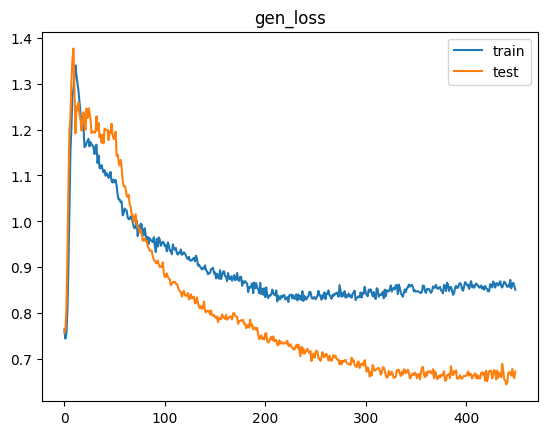

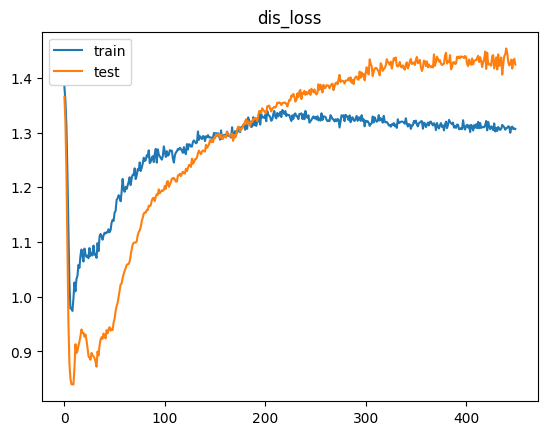

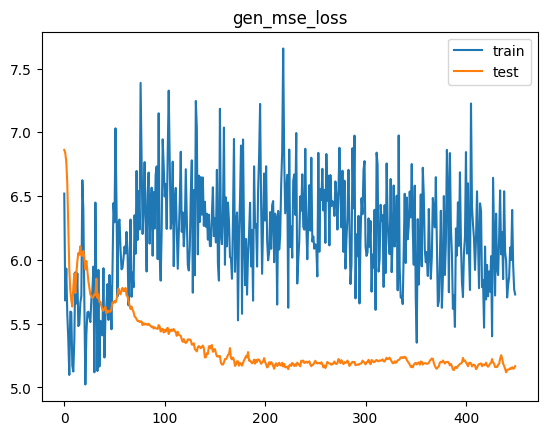

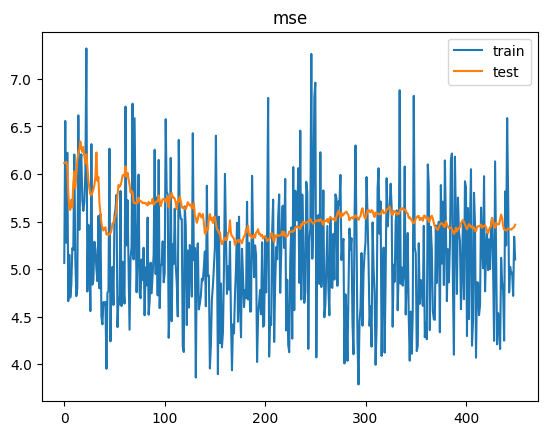

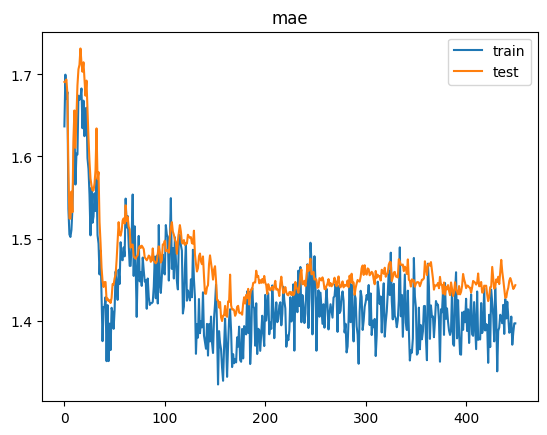

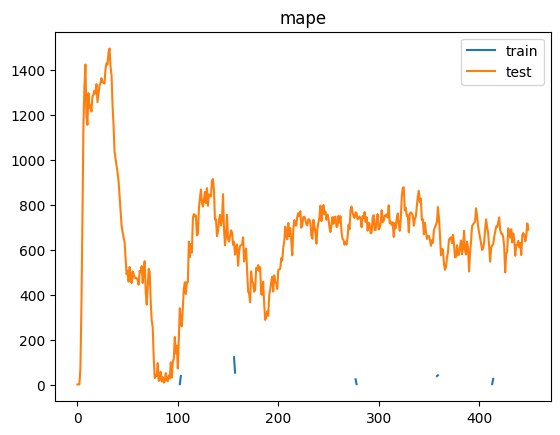

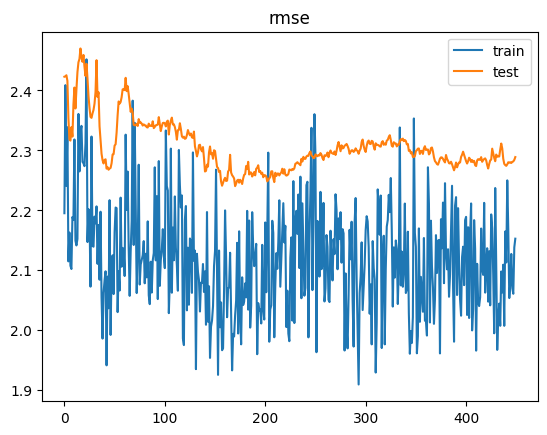

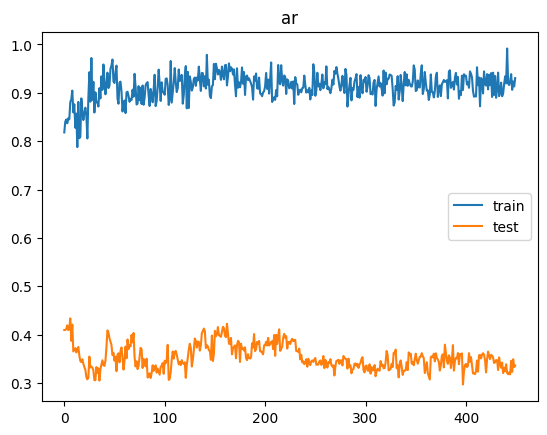

2/2 [==============================] - 0s 3ms/step


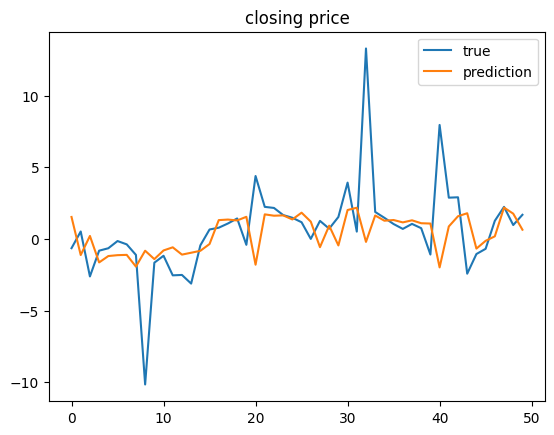

[MSE Baseline] train: 4.19324741866197  test: 5.002352560408067
Delta time with epochs = 450: 0:06:22.172400
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 lstm_4 (LSTM)               (None, 5, 10)             720       
                                                                 
 batch_normalization_4 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_10 (Dropout)        (None, 5, 10)             0         
                                                                 
 lstm_5 (LSTM)  

Time for epoch 53 is 0.7590272426605225 sec Generator Loss: 0.8920907378196716,  Discriminator_loss: 1.2842239141464233
Time for epoch 54 is 0.7612519264221191 sec Generator Loss: 0.893746018409729,  Discriminator_loss: 1.2838122844696045
Time for epoch 55 is 0.7581832408905029 sec Generator Loss: 0.8909221887588501,  Discriminator_loss: 1.2838467359542847
Time for epoch 56 is 0.7559003829956055 sec Generator Loss: 0.8818047046661377,  Discriminator_loss: 1.2827039957046509
Time for epoch 57 is 0.7631933689117432 sec Generator Loss: 0.8875834345817566,  Discriminator_loss: 1.26826012134552
Time for epoch 58 is 0.7813680171966553 sec Generator Loss: 0.893363356590271,  Discriminator_loss: 1.2756726741790771
Time for epoch 59 is 0.7938697338104248 sec Generator Loss: 0.8811348676681519,  Discriminator_loss: 1.2770798206329346
Time for epoch 60 is 0.8276021480560303 sec Generator Loss: 0.8927180171012878,  Discriminator_loss: 1.2637969255447388
Time for epoch 61 is 0.8320128917694092 sec 

Time for epoch 122 is 0.7597432136535645 sec Generator Loss: 0.861143946647644,  Discriminator_loss: 1.2972958087921143
Time for epoch 123 is 0.7554254531860352 sec Generator Loss: 0.8688027858734131,  Discriminator_loss: 1.2955102920532227
Time for epoch 124 is 0.752619743347168 sec Generator Loss: 0.8672714829444885,  Discriminator_loss: 1.2954450845718384
Time for epoch 125 is 0.7497406005859375 sec Generator Loss: 0.8650485873222351,  Discriminator_loss: 1.2910658121109009
Time for epoch 126 is 0.7478632926940918 sec Generator Loss: 0.8700881004333496,  Discriminator_loss: 1.2931188344955444
Time for epoch 127 is 0.7540526390075684 sec Generator Loss: 0.8861832618713379,  Discriminator_loss: 1.288313627243042
Time for epoch 128 is 0.7487497329711914 sec Generator Loss: 0.8732924461364746,  Discriminator_loss: 1.2998175621032715
Time for epoch 129 is 0.7531459331512451 sec Generator Loss: 0.8681550621986389,  Discriminator_loss: 1.2996128797531128
Time for epoch 130 is 0.75956201553

Time for epoch 190 is 0.9958188533782959 sec Generator Loss: 0.8647754788398743,  Discriminator_loss: 1.295973777770996
Time for epoch 191 is 1.0509083271026611 sec Generator Loss: 0.8667901158332825,  Discriminator_loss: 1.2992411851882935
Time for epoch 192 is 0.8552260398864746 sec Generator Loss: 0.8652470111846924,  Discriminator_loss: 1.311453104019165
Time for epoch 193 is 0.898146390914917 sec Generator Loss: 0.8648717403411865,  Discriminator_loss: 1.3050180673599243
Time for epoch 194 is 0.9446537494659424 sec Generator Loss: 0.8672634363174438,  Discriminator_loss: 1.2944446802139282
Time for epoch 195 is 0.8382296562194824 sec Generator Loss: 0.877130925655365,  Discriminator_loss: 1.2925500869750977
Time for epoch 196 is 0.7997894287109375 sec Generator Loss: 0.8772399425506592,  Discriminator_loss: 1.303039312362671
Time for epoch 197 is 1.1499559879302979 sec Generator Loss: 0.8658556342124939,  Discriminator_loss: 1.3025604486465454
Time for epoch 198 is 1.1755094528198

Time for epoch 259 is 0.9950759410858154 sec Generator Loss: 0.8689156770706177,  Discriminator_loss: 1.302127718925476
Time for epoch 260 is 0.8152391910552979 sec Generator Loss: 0.8605371117591858,  Discriminator_loss: 1.303908109664917
Time for epoch 261 is 0.7863707542419434 sec Generator Loss: 0.8570464253425598,  Discriminator_loss: 1.2992924451828003
Time for epoch 262 is 0.8007102012634277 sec Generator Loss: 0.8602873086929321,  Discriminator_loss: 1.2975455522537231
Time for epoch 263 is 0.792597770690918 sec Generator Loss: 0.8630769848823547,  Discriminator_loss: 1.3033843040466309
Time for epoch 264 is 0.7931950092315674 sec Generator Loss: 0.8576841950416565,  Discriminator_loss: 1.3072787523269653
Time for epoch 265 is 0.7826352119445801 sec Generator Loss: 0.8715748190879822,  Discriminator_loss: 1.297003149986267
Time for epoch 266 is 0.7830922603607178 sec Generator Loss: 0.859379231929779,  Discriminator_loss: 1.2988693714141846
Time for epoch 267 is 0.7846562862396

Time for epoch 328 is 0.7744495868682861 sec Generator Loss: 0.8631719350814819,  Discriminator_loss: 1.3099243640899658
Time for epoch 329 is 0.777484655380249 sec Generator Loss: 0.8570827841758728,  Discriminator_loss: 1.2970476150512695
Time for epoch 330 is 0.786527156829834 sec Generator Loss: 0.8580155968666077,  Discriminator_loss: 1.3034262657165527
Time for epoch 331 is 0.7905700206756592 sec Generator Loss: 0.8576642870903015,  Discriminator_loss: 1.2984472513198853
Time for epoch 332 is 0.9682657718658447 sec Generator Loss: 0.8641103506088257,  Discriminator_loss: 1.295573353767395
Time for epoch 333 is 0.8385763168334961 sec Generator Loss: 0.860057532787323,  Discriminator_loss: 1.297839879989624
Time for epoch 334 is 0.8273136615753174 sec Generator Loss: 0.8668990135192871,  Discriminator_loss: 1.2958290576934814
Time for epoch 335 is 0.7831430435180664 sec Generator Loss: 0.8692758679389954,  Discriminator_loss: 1.2947732210159302
Time for epoch 336 is 0.8062181472778

Time for epoch 397 is 0.8003389835357666 sec Generator Loss: 0.8664824962615967,  Discriminator_loss: 1.2942639589309692
Time for epoch 398 is 0.8011519908905029 sec Generator Loss: 0.8704066872596741,  Discriminator_loss: 1.296587347984314
Time for epoch 399 is 0.7931816577911377 sec Generator Loss: 0.8586349487304688,  Discriminator_loss: 1.3024455308914185
Time for epoch 400 is 0.78045654296875 sec Generator Loss: 0.8643427491188049,  Discriminator_loss: 1.3020166158676147
Time for epoch 401 is 0.7924563884735107 sec Generator Loss: 0.8632478713989258,  Discriminator_loss: 1.3010413646697998
Time for epoch 402 is 0.7855925559997559 sec Generator Loss: 0.8627343773841858,  Discriminator_loss: 1.300118088722229
Time for epoch 403 is 0.7918062210083008 sec Generator Loss: 0.8680384755134583,  Discriminator_loss: 1.300179123878479
Time for epoch 404 is 0.7904345989227295 sec Generator Loss: 0.8660916686058044,  Discriminator_loss: 1.301720142364502
Time for epoch 405 is 0.82108616828918

Time for epoch 465 is 0.7938754558563232 sec Generator Loss: 0.8661211133003235,  Discriminator_loss: 1.2972323894500732
Time for epoch 466 is 0.7969191074371338 sec Generator Loss: 0.8637160062789917,  Discriminator_loss: 1.2977466583251953
Time for epoch 467 is 0.7890427112579346 sec Generator Loss: 0.873457670211792,  Discriminator_loss: 1.2959299087524414
Time for epoch 468 is 0.7882723808288574 sec Generator Loss: 0.866999089717865,  Discriminator_loss: 1.3029778003692627
Time for epoch 469 is 0.8037426471710205 sec Generator Loss: 0.8707418441772461,  Discriminator_loss: 1.299593448638916
Time for epoch 470 is 0.7865791320800781 sec Generator Loss: 0.8653236031532288,  Discriminator_loss: 1.2970110177993774
Time for epoch 471 is 0.782264232635498 sec Generator Loss: 0.8662332892417908,  Discriminator_loss: 1.307614803314209
Time for epoch 472 is 0.8134722709655762 sec Generator Loss: 0.8690992593765259,  Discriminator_loss: 1.308868408203125
Time for epoch 473 is 0.79828214645385

Time for epoch 534 is 0.7796413898468018 sec Generator Loss: 0.8603274822235107,  Discriminator_loss: 1.302429437637329
Time for epoch 535 is 0.7861242294311523 sec Generator Loss: 0.8645579814910889,  Discriminator_loss: 1.3005410432815552
Time for epoch 536 is 0.7898008823394775 sec Generator Loss: 0.8672060966491699,  Discriminator_loss: 1.2992732524871826
Time for epoch 537 is 0.7801365852355957 sec Generator Loss: 0.8683179020881653,  Discriminator_loss: 1.3014671802520752
Time for epoch 538 is 0.795250654220581 sec Generator Loss: 0.8646532297134399,  Discriminator_loss: 1.3127033710479736
Time for epoch 539 is 0.7844133377075195 sec Generator Loss: 0.8726913332939148,  Discriminator_loss: 1.2941014766693115
Time for epoch 540 is 0.7918102741241455 sec Generator Loss: 0.8724491596221924,  Discriminator_loss: 1.305600881576538
Time for epoch 541 is 0.7834732532501221 sec Generator Loss: 0.8717001080513,  Discriminator_loss: 1.2985608577728271
Time for epoch 542 is 0.78159308433532

Time for epoch 603 is 0.7881629467010498 sec Generator Loss: 0.8685665726661682,  Discriminator_loss: 1.297927975654602
Time for epoch 604 is 0.7884597778320312 sec Generator Loss: 0.876376748085022,  Discriminator_loss: 1.2905317544937134
Time for epoch 605 is 0.7700445652008057 sec Generator Loss: 0.8670431971549988,  Discriminator_loss: 1.2961708307266235
Time for epoch 606 is 0.7424283027648926 sec Generator Loss: 0.8886095881462097,  Discriminator_loss: 1.2877211570739746
Time for epoch 607 is 0.756765604019165 sec Generator Loss: 0.8646164536476135,  Discriminator_loss: 1.3012275695800781
Time for epoch 608 is 0.7576181888580322 sec Generator Loss: 0.8638966679573059,  Discriminator_loss: 1.296958088874817
Time for epoch 609 is 0.7572946548461914 sec Generator Loss: 0.8743484020233154,  Discriminator_loss: 1.290313482284546
Time for epoch 610 is 0.7539534568786621 sec Generator Loss: 0.8753267526626587,  Discriminator_loss: 1.3013001680374146
Time for epoch 611 is 0.7538831233978

Time for epoch 671 is 0.8029484748840332 sec Generator Loss: 0.862431526184082,  Discriminator_loss: 1.291733980178833
Time for epoch 672 is 0.7858822345733643 sec Generator Loss: 0.876854419708252,  Discriminator_loss: 1.2872895002365112
Time for epoch 673 is 0.7914261817932129 sec Generator Loss: 0.869735598564148,  Discriminator_loss: 1.2910566329956055
Time for epoch 674 is 0.8041849136352539 sec Generator Loss: 0.878251314163208,  Discriminator_loss: 1.2935996055603027
Time for epoch 675 is 0.7860219478607178 sec Generator Loss: 0.8800386190414429,  Discriminator_loss: 1.2962061166763306
Time for epoch 676 is 0.7828941345214844 sec Generator Loss: 0.8785097599029541,  Discriminator_loss: 1.2986466884613037
Time for epoch 677 is 0.8197805881500244 sec Generator Loss: 0.865490198135376,  Discriminator_loss: 1.302260398864746
Time for epoch 678 is 0.7790279388427734 sec Generator Loss: 0.8851140737533569,  Discriminator_loss: 1.2996375560760498
Time for epoch 679 is 0.785136222839355

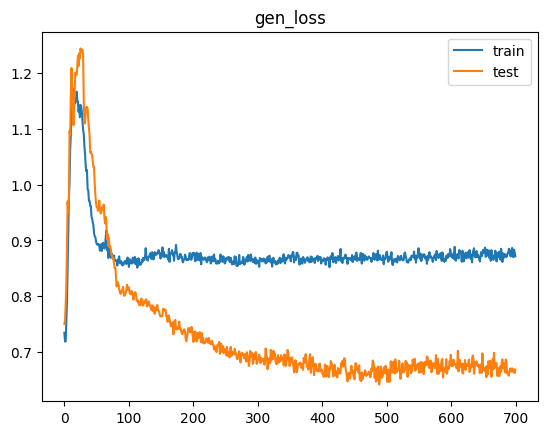

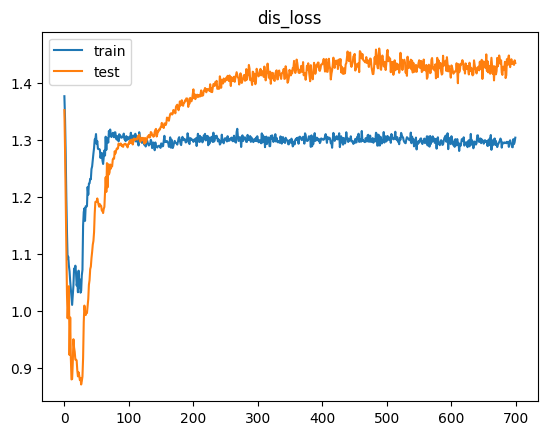

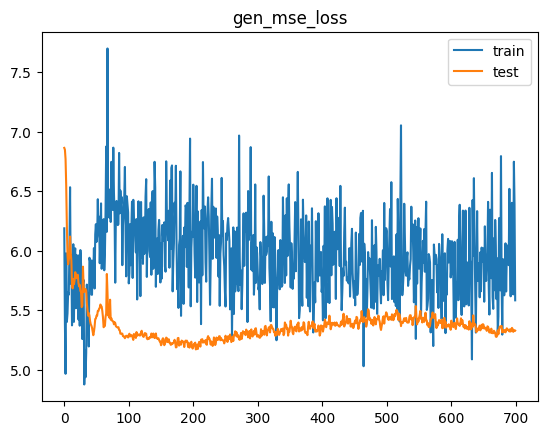

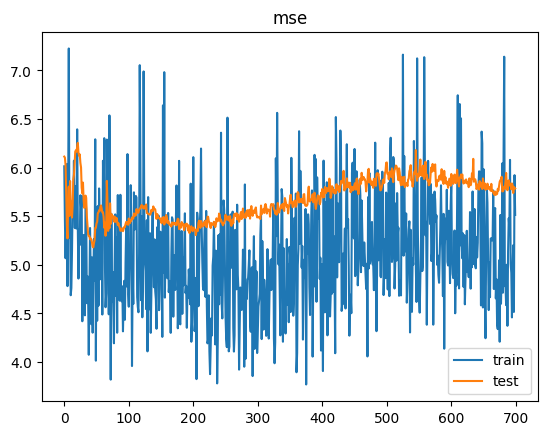

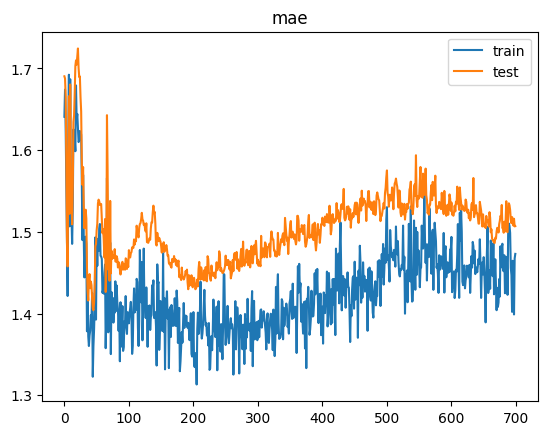

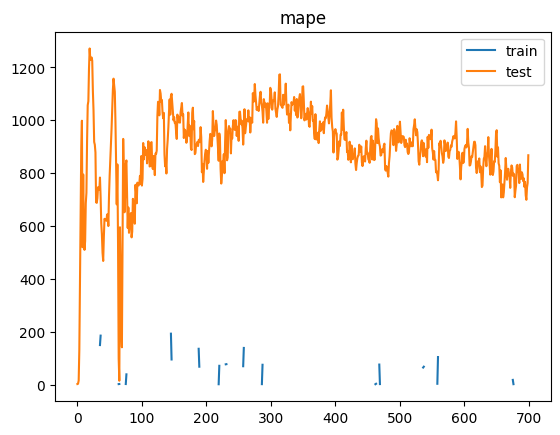

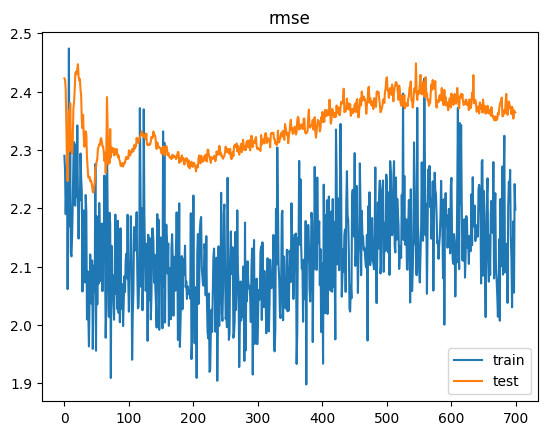

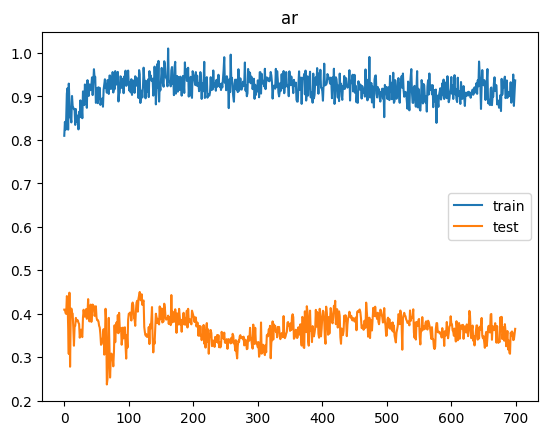

2/2 [==============================] - 0s 3ms/step


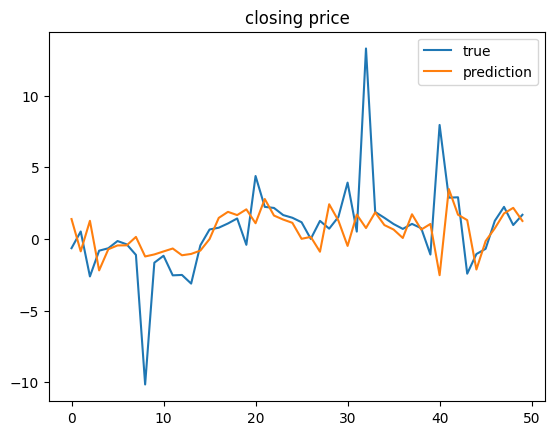

[MSE Baseline] train: 4.472632382442669  test: 5.002352560408067
Delta time with epochs = 700: 0:09:31.844997


In [20]:
for epochs in [200, 450, 700]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("lstm_ffnn_epochs_{0}.h5".format(epochs))

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 lstm_6 (LSTM)               (None, 5, 10)             720       
                                                                 
 batch_normalization_6 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_15 (Dropout)        (None, 5, 10)             0         
                                                                 
 lstm_7 (LSTM)               (None, 10)                840       
                                                           

Time for epoch 53 is 0.7564883232116699 sec Generator Loss: 1.0190479755401611,  Discriminator_loss: 1.195096731185913
Time for epoch 54 is 0.7520120143890381 sec Generator Loss: 1.0011460781097412,  Discriminator_loss: 1.2019256353378296
Time for epoch 55 is 0.75510573387146 sec Generator Loss: 0.988277792930603,  Discriminator_loss: 1.1999552249908447
Time for epoch 56 is 0.7587990760803223 sec Generator Loss: 0.9957777857780457,  Discriminator_loss: 1.2066807746887207
Time for epoch 57 is 0.7543551921844482 sec Generator Loss: 1.0010312795639038,  Discriminator_loss: 1.2110159397125244
Time for epoch 58 is 0.7620766162872314 sec Generator Loss: 1.0155363082885742,  Discriminator_loss: 1.2017645835876465
Time for epoch 59 is 0.7541224956512451 sec Generator Loss: 0.994104266166687,  Discriminator_loss: 1.2069369554519653
Time for epoch 60 is 0.7553350925445557 sec Generator Loss: 0.9991053938865662,  Discriminator_loss: 1.1985876560211182
Time for epoch 61 is 0.751460075378418 sec Ge

Time for epoch 122 is 0.8040368556976318 sec Generator Loss: 0.911890983581543,  Discriminator_loss: 1.2838178873062134
Time for epoch 123 is 0.7806253433227539 sec Generator Loss: 0.8989406228065491,  Discriminator_loss: 1.2945679426193237
Time for epoch 124 is 0.7858777046203613 sec Generator Loss: 0.9005833864212036,  Discriminator_loss: 1.2987011671066284
Time for epoch 125 is 0.7929291725158691 sec Generator Loss: 0.8923608660697937,  Discriminator_loss: 1.2974876165390015
Time for epoch 126 is 0.7959558963775635 sec Generator Loss: 0.8872537016868591,  Discriminator_loss: 1.2947516441345215
Time for epoch 127 is 0.7973415851593018 sec Generator Loss: 0.912965714931488,  Discriminator_loss: 1.2782182693481445
Time for epoch 128 is 0.790769100189209 sec Generator Loss: 0.8971666097640991,  Discriminator_loss: 1.2911620140075684
Time for epoch 129 is 0.801499605178833 sec Generator Loss: 0.8925891518592834,  Discriminator_loss: 1.3005660772323608
Time for epoch 130 is 0.787223100662

Time for epoch 191 is 0.7818331718444824 sec Generator Loss: 0.8746110796928406,  Discriminator_loss: 1.3067539930343628
Time for epoch 192 is 0.8425135612487793 sec Generator Loss: 0.8797637224197388,  Discriminator_loss: 1.2961801290512085
Time for epoch 193 is 0.7809183597564697 sec Generator Loss: 0.8900330066680908,  Discriminator_loss: 1.2975317239761353
Time for epoch 194 is 0.9145493507385254 sec Generator Loss: 0.873070240020752,  Discriminator_loss: 1.3024187088012695
Time for epoch 195 is 0.8884713649749756 sec Generator Loss: 0.8764542937278748,  Discriminator_loss: 1.2947041988372803
Time for epoch 196 is 0.8527052402496338 sec Generator Loss: 0.8773863911628723,  Discriminator_loss: 1.3050284385681152
Time for epoch 197 is 0.8714604377746582 sec Generator Loss: 0.882238507270813,  Discriminator_loss: 1.3158209323883057
Time for epoch 198 is 0.8110270500183105 sec Generator Loss: 0.8861725926399231,  Discriminator_loss: 1.3002095222473145
Time for epoch 199 is 0.8021259307

Time for epoch 260 is 0.7573690414428711 sec Generator Loss: 0.8979009985923767,  Discriminator_loss: 1.293418526649475
Time for epoch 261 is 0.7508478164672852 sec Generator Loss: 0.8711093664169312,  Discriminator_loss: 1.3139511346817017
Time for epoch 262 is 0.7511014938354492 sec Generator Loss: 0.8876508474349976,  Discriminator_loss: 1.2935103178024292
Time for epoch 263 is 0.7509474754333496 sec Generator Loss: 0.8730530142784119,  Discriminator_loss: 1.3089585304260254
Time for epoch 264 is 0.7446870803833008 sec Generator Loss: 0.8901788592338562,  Discriminator_loss: 1.302323579788208
Time for epoch 265 is 0.7543494701385498 sec Generator Loss: 0.8898656964302063,  Discriminator_loss: 1.3026467561721802
Time for epoch 266 is 0.7611949443817139 sec Generator Loss: 0.8815720081329346,  Discriminator_loss: 1.3017590045928955
Time for epoch 267 is 0.7527997493743896 sec Generator Loss: 0.8863344788551331,  Discriminator_loss: 1.297999620437622
Time for epoch 268 is 0.75128245353

Time for epoch 328 is 0.8469564914703369 sec Generator Loss: 0.8670530319213867,  Discriminator_loss: 1.3081194162368774
Time for epoch 329 is 0.8176257610321045 sec Generator Loss: 0.8645140528678894,  Discriminator_loss: 1.3155192136764526
Time for epoch 330 is 0.8261785507202148 sec Generator Loss: 0.8785780668258667,  Discriminator_loss: 1.300684928894043
Time for epoch 331 is 0.8281128406524658 sec Generator Loss: 0.8754594326019287,  Discriminator_loss: 1.308872938156128
Time for epoch 332 is 0.807807445526123 sec Generator Loss: 0.8728562593460083,  Discriminator_loss: 1.3123323917388916
Time for epoch 333 is 0.7831995487213135 sec Generator Loss: 0.8754551410675049,  Discriminator_loss: 1.3100684881210327
Time for epoch 334 is 0.7929770946502686 sec Generator Loss: 0.8727836012840271,  Discriminator_loss: 1.303455114364624
Time for epoch 335 is 0.7825970649719238 sec Generator Loss: 0.8754258155822754,  Discriminator_loss: 1.3063641786575317
Time for epoch 336 is 0.760503768920

Time for epoch 397 is 0.7485148906707764 sec Generator Loss: 0.8784384727478027,  Discriminator_loss: 1.3051387071609497
Time for epoch 398 is 0.7738115787506104 sec Generator Loss: 0.8777129650115967,  Discriminator_loss: 1.303348422050476
Time for epoch 399 is 0.7467269897460938 sec Generator Loss: 0.8779308795928955,  Discriminator_loss: 1.3103643655776978
Time for epoch 400 is 0.758922815322876 sec Generator Loss: 0.8785951137542725,  Discriminator_loss: 1.3067928552627563
Time for epoch 401 is 0.762171745300293 sec Generator Loss: 0.8822275996208191,  Discriminator_loss: 1.307686686515808
Time for epoch 402 is 0.756030797958374 sec Generator Loss: 0.872456967830658,  Discriminator_loss: 1.3132017850875854
Time for epoch 403 is 0.7530674934387207 sec Generator Loss: 0.8825435042381287,  Discriminator_loss: 1.3038129806518555
Time for epoch 404 is 0.7699368000030518 sec Generator Loss: 0.8786104917526245,  Discriminator_loss: 1.3082658052444458
Time for epoch 405 is 0.80307269096374

Time for epoch 465 is 0.7543606758117676 sec Generator Loss: 0.879037082195282,  Discriminator_loss: 1.2956359386444092
Time for epoch 466 is 0.7543299198150635 sec Generator Loss: 0.8659427762031555,  Discriminator_loss: 1.3065159320831299
Time for epoch 467 is 0.7519874572753906 sec Generator Loss: 0.8755276203155518,  Discriminator_loss: 1.3081295490264893
Time for epoch 468 is 0.7524387836456299 sec Generator Loss: 0.8716353178024292,  Discriminator_loss: 1.3010756969451904
Time for epoch 469 is 0.754453182220459 sec Generator Loss: 0.8797886371612549,  Discriminator_loss: 1.3037246465682983
Time for epoch 470 is 0.7455966472625732 sec Generator Loss: 0.883923351764679,  Discriminator_loss: 1.2898062467575073
Time for epoch 471 is 0.7572121620178223 sec Generator Loss: 0.8904624581336975,  Discriminator_loss: 1.2910102605819702
Time for epoch 472 is 0.7514164447784424 sec Generator Loss: 0.8776472210884094,  Discriminator_loss: 1.308463454246521
Time for epoch 473 is 0.756640911102

Time for epoch 533 is 0.7527170181274414 sec Generator Loss: 0.8839284181594849,  Discriminator_loss: 1.2948358058929443
Time for epoch 534 is 0.7575061321258545 sec Generator Loss: 0.8735478520393372,  Discriminator_loss: 1.3116188049316406
Time for epoch 535 is 0.7589480876922607 sec Generator Loss: 0.8845183849334717,  Discriminator_loss: 1.3013256788253784
Time for epoch 536 is 0.7518961429595947 sec Generator Loss: 0.8902506828308105,  Discriminator_loss: 1.2960330247879028
Time for epoch 537 is 0.757744312286377 sec Generator Loss: 0.8844643235206604,  Discriminator_loss: 1.2965322732925415
Time for epoch 538 is 0.7600512504577637 sec Generator Loss: 0.8872830867767334,  Discriminator_loss: 1.3012713193893433
Time for epoch 539 is 0.7527871131896973 sec Generator Loss: 0.8878173232078552,  Discriminator_loss: 1.3084911108016968
Time for epoch 540 is 0.7692289352416992 sec Generator Loss: 0.8851182460784912,  Discriminator_loss: 1.3011940717697144
Time for epoch 541 is 0.777486562

Time for epoch 601 is 0.759676456451416 sec Generator Loss: 0.8771542906761169,  Discriminator_loss: 1.3034422397613525
Time for epoch 602 is 0.7596302032470703 sec Generator Loss: 0.8793646097183228,  Discriminator_loss: 1.3014740943908691
Time for epoch 603 is 0.7600984573364258 sec Generator Loss: 0.8793967366218567,  Discriminator_loss: 1.306166410446167
Time for epoch 604 is 0.7456049919128418 sec Generator Loss: 0.8886346220970154,  Discriminator_loss: 1.2978614568710327
Time for epoch 605 is 0.7664828300476074 sec Generator Loss: 0.8907477259635925,  Discriminator_loss: 1.2950950860977173
Time for epoch 606 is 0.7537479400634766 sec Generator Loss: 0.8964161276817322,  Discriminator_loss: 1.2875173091888428
Time for epoch 607 is 0.7570271492004395 sec Generator Loss: 0.892422080039978,  Discriminator_loss: 1.29716157913208
Time for epoch 608 is 0.7554314136505127 sec Generator Loss: 0.8933731317520142,  Discriminator_loss: 1.3021841049194336
Time for epoch 609 is 0.7609684467315

Time for epoch 669 is 0.9223153591156006 sec Generator Loss: 0.8948217630386353,  Discriminator_loss: 1.2836925983428955
Time for epoch 670 is 0.8551225662231445 sec Generator Loss: 0.8828583359718323,  Discriminator_loss: 1.2995952367782593
Time for epoch 671 is 0.8533871173858643 sec Generator Loss: 0.8907254338264465,  Discriminator_loss: 1.295302391052246
Time for epoch 672 is 0.8539364337921143 sec Generator Loss: 0.8919313549995422,  Discriminator_loss: 1.2976993322372437
Time for epoch 673 is 0.966935396194458 sec Generator Loss: 0.9063243865966797,  Discriminator_loss: 1.2863340377807617
Time for epoch 674 is 0.8646948337554932 sec Generator Loss: 0.8813846707344055,  Discriminator_loss: 1.298811674118042
Time for epoch 675 is 0.8883218765258789 sec Generator Loss: 0.8774515390396118,  Discriminator_loss: 1.2995548248291016
Time for epoch 676 is 0.8957250118255615 sec Generator Loss: 0.892838716506958,  Discriminator_loss: 1.294103980064392
Time for epoch 677 is 0.8189113140106

Time for epoch 738 is 0.8277554512023926 sec Generator Loss: 0.8940299153327942,  Discriminator_loss: 1.2972002029418945
Time for epoch 739 is 0.8603026866912842 sec Generator Loss: 0.8945638537406921,  Discriminator_loss: 1.292607307434082
Time for epoch 740 is 0.8354530334472656 sec Generator Loss: 0.8922032117843628,  Discriminator_loss: 1.2955482006072998
Time for epoch 741 is 0.8359165191650391 sec Generator Loss: 0.8928930163383484,  Discriminator_loss: 1.2932976484298706
Time for epoch 742 is 0.8388044834136963 sec Generator Loss: 0.8974154591560364,  Discriminator_loss: 1.2899274826049805
Time for epoch 743 is 0.8403959274291992 sec Generator Loss: 0.8871480822563171,  Discriminator_loss: 1.2907840013504028
Time for epoch 744 is 0.83782958984375 sec Generator Loss: 0.9069486856460571,  Discriminator_loss: 1.2844699621200562
Time for epoch 745 is 0.8918299674987793 sec Generator Loss: 0.8779219388961792,  Discriminator_loss: 1.3066442012786865
Time for epoch 746 is 0.84823131561

Time for epoch 806 is 0.8133571147918701 sec Generator Loss: 0.9105008244514465,  Discriminator_loss: 1.2869906425476074
Time for epoch 807 is 0.8769583702087402 sec Generator Loss: 0.9059987664222717,  Discriminator_loss: 1.2850985527038574
Time for epoch 808 is 0.8422765731811523 sec Generator Loss: 0.9101831912994385,  Discriminator_loss: 1.2833644151687622
Time for epoch 809 is 0.9018092155456543 sec Generator Loss: 0.8961286544799805,  Discriminator_loss: 1.296550989151001
Time for epoch 810 is 0.8560936450958252 sec Generator Loss: 0.8895920515060425,  Discriminator_loss: 1.2891179323196411
Time for epoch 811 is 0.874852180480957 sec Generator Loss: 0.89718097448349,  Discriminator_loss: 1.2946858406066895
Time for epoch 812 is 0.817298173904419 sec Generator Loss: 0.8990709185600281,  Discriminator_loss: 1.2918345928192139
Time for epoch 813 is 0.8098986148834229 sec Generator Loss: 0.9014741778373718,  Discriminator_loss: 1.2783538103103638
Time for epoch 814 is 0.8270289897918

Time for epoch 874 is 0.9364893436431885 sec Generator Loss: 0.8902255296707153,  Discriminator_loss: 1.2998753786087036
Time for epoch 875 is 0.8940093517303467 sec Generator Loss: 0.9107906222343445,  Discriminator_loss: 1.2813853025436401
Time for epoch 876 is 0.8615865707397461 sec Generator Loss: 0.8994247913360596,  Discriminator_loss: 1.2865350246429443
Time for epoch 877 is 0.8786230087280273 sec Generator Loss: 0.9114536046981812,  Discriminator_loss: 1.272679090499878
Time for epoch 878 is 0.8039040565490723 sec Generator Loss: 0.9013211131095886,  Discriminator_loss: 1.2926796674728394
Time for epoch 879 is 0.7978136539459229 sec Generator Loss: 0.9004830718040466,  Discriminator_loss: 1.2896682024002075
Time for epoch 880 is 0.7961375713348389 sec Generator Loss: 0.8946611881256104,  Discriminator_loss: 1.287758231163025
Time for epoch 881 is 0.7860734462738037 sec Generator Loss: 0.9050431251525879,  Discriminator_loss: 1.2846094369888306
Time for epoch 882 is 0.7938628196

Time for epoch 943 is 0.9850056171417236 sec Generator Loss: 0.9156391024589539,  Discriminator_loss: 1.2810049057006836
Time for epoch 944 is 0.9342339038848877 sec Generator Loss: 0.909742534160614,  Discriminator_loss: 1.2795764207839966
Time for epoch 945 is 0.8773891925811768 sec Generator Loss: 0.9144676923751831,  Discriminator_loss: 1.2812329530715942
Time for epoch 946 is 0.9295589923858643 sec Generator Loss: 0.9212237596511841,  Discriminator_loss: 1.2717889547348022
Time for epoch 947 is 0.9215972423553467 sec Generator Loss: 0.9324842691421509,  Discriminator_loss: 1.2765424251556396
Time for epoch 948 is 0.9322583675384521 sec Generator Loss: 0.8959301114082336,  Discriminator_loss: 1.2969430685043335
Time for epoch 949 is 0.859825849533081 sec Generator Loss: 0.9161360263824463,  Discriminator_loss: 1.279456615447998
Time for epoch 950 is 0.9636020660400391 sec Generator Loss: 0.9016842842102051,  Discriminator_loss: 1.290793776512146


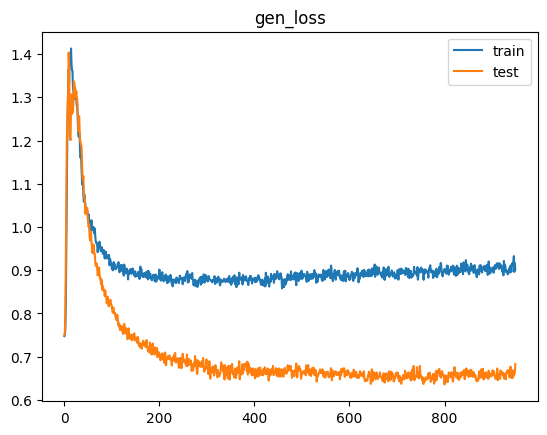

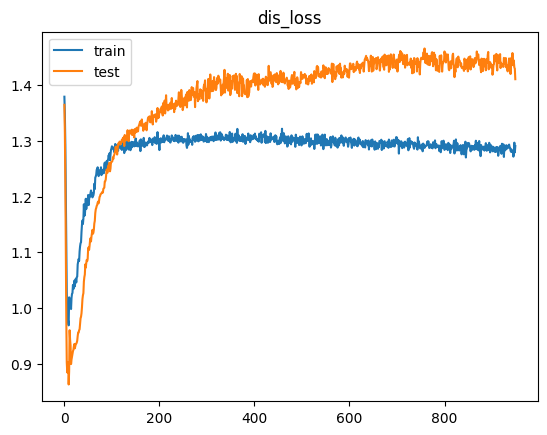

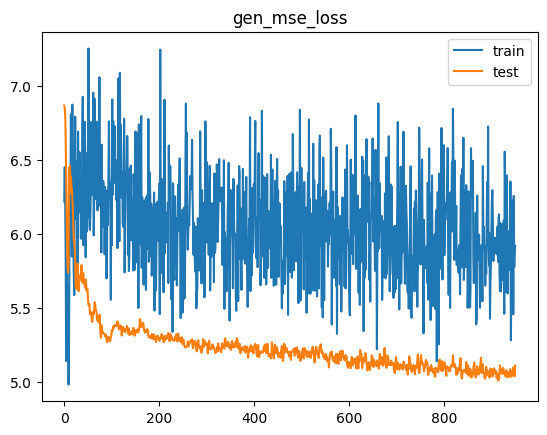

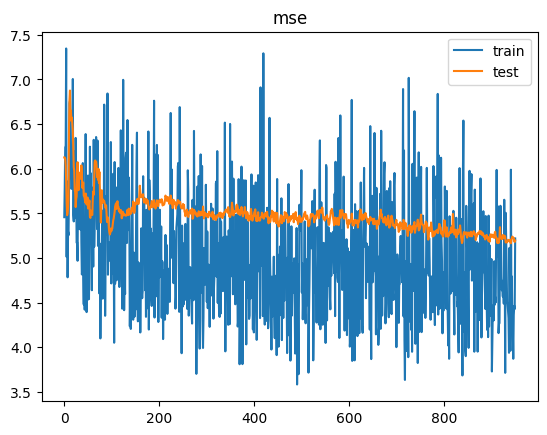

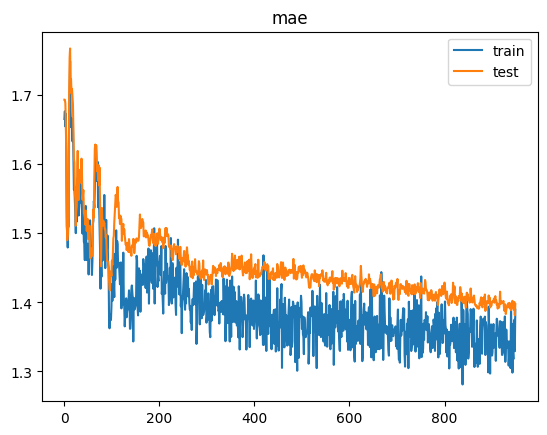

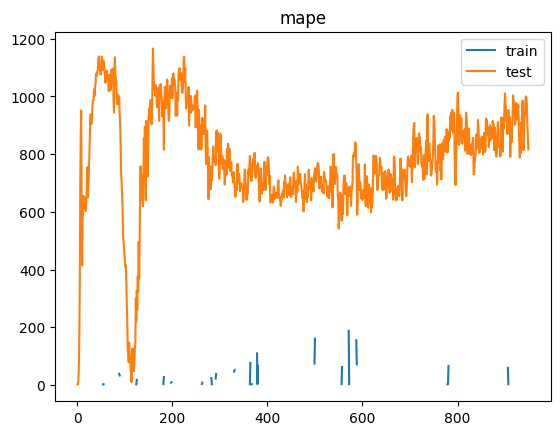

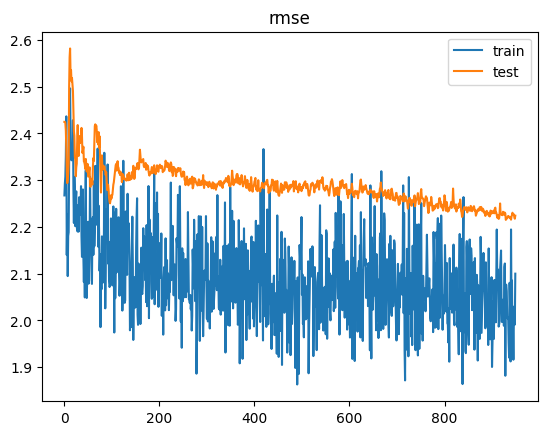

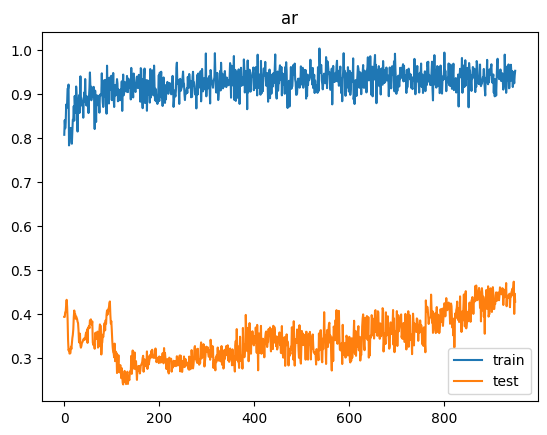

2/2 [==============================] - 0s 4ms/step


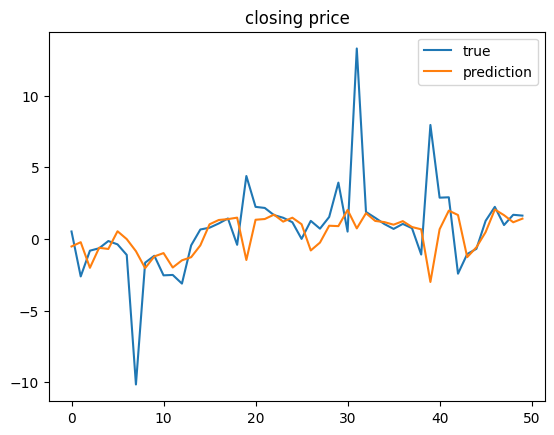

[MSE Baseline] train: 4.629357486791305  test: 5.010967196008289
Delta time with epochs = 950: 0:13:03.801442
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 lstm_8 (LSTM)               (None, 5, 10)             720       
                                                                 
 batch_normalization_8 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_20 (Dropout)        (None, 5, 10)             0         
                                                                 
 lstm_9 (LSTM) 

Time for epoch 53 is 0.8075962066650391 sec Generator Loss: 1.0331462621688843,  Discriminator_loss: 1.1739674806594849
Time for epoch 54 is 0.8158104419708252 sec Generator Loss: 1.0428663492202759,  Discriminator_loss: 1.1750153303146362
Time for epoch 55 is 0.8284206390380859 sec Generator Loss: 1.0240142345428467,  Discriminator_loss: 1.1885148286819458
Time for epoch 56 is 0.8189771175384521 sec Generator Loss: 1.0221391916275024,  Discriminator_loss: 1.1918840408325195
Time for epoch 57 is 0.8135497570037842 sec Generator Loss: 1.0016456842422485,  Discriminator_loss: 1.210159182548523
Time for epoch 58 is 0.8010597229003906 sec Generator Loss: 1.012507677078247,  Discriminator_loss: 1.184165358543396
Time for epoch 59 is 0.8124439716339111 sec Generator Loss: 1.0170519351959229,  Discriminator_loss: 1.1807808876037598
Time for epoch 60 is 0.8106780052185059 sec Generator Loss: 1.0161633491516113,  Discriminator_loss: 1.1938340663909912
Time for epoch 61 is 0.8227524757385254 sec

Time for epoch 122 is 0.8532876968383789 sec Generator Loss: 0.8794575333595276,  Discriminator_loss: 1.3029234409332275
Time for epoch 123 is 0.8455512523651123 sec Generator Loss: 0.8733113408088684,  Discriminator_loss: 1.306073546409607
Time for epoch 124 is 0.8677711486816406 sec Generator Loss: 0.8800985813140869,  Discriminator_loss: 1.3133723735809326
Time for epoch 125 is 0.8574638366699219 sec Generator Loss: 0.866948664188385,  Discriminator_loss: 1.3062771558761597
Time for epoch 126 is 0.8668780326843262 sec Generator Loss: 0.8726231455802917,  Discriminator_loss: 1.3058353662490845
Time for epoch 127 is 0.8612823486328125 sec Generator Loss: 0.8744331002235413,  Discriminator_loss: 1.2988406419754028
Time for epoch 128 is 0.8420829772949219 sec Generator Loss: 0.8772501349449158,  Discriminator_loss: 1.2912343740463257
Time for epoch 129 is 0.8436436653137207 sec Generator Loss: 0.8755072355270386,  Discriminator_loss: 1.2946741580963135
Time for epoch 130 is 0.8431155681

Time for epoch 190 is 1.0194618701934814 sec Generator Loss: 0.8951607346534729,  Discriminator_loss: 1.2844387292861938
Time for epoch 191 is 1.0334641933441162 sec Generator Loss: 0.8953431844711304,  Discriminator_loss: 1.285199522972107
Time for epoch 192 is 1.026916265487671 sec Generator Loss: 0.8922876119613647,  Discriminator_loss: 1.283921241760254
Time for epoch 193 is 0.903038740158081 sec Generator Loss: 0.8944683074951172,  Discriminator_loss: 1.2975207567214966
Time for epoch 194 is 0.9055585861206055 sec Generator Loss: 0.8829448223114014,  Discriminator_loss: 1.2982220649719238
Time for epoch 195 is 0.9326086044311523 sec Generator Loss: 0.8732393980026245,  Discriminator_loss: 1.3013828992843628
Time for epoch 196 is 1.0919685363769531 sec Generator Loss: 0.8738354444503784,  Discriminator_loss: 1.2948986291885376
Time for epoch 197 is 1.0477981567382812 sec Generator Loss: 0.8812769651412964,  Discriminator_loss: 1.2918096780776978
Time for epoch 198 is 1.044291019439

Time for epoch 259 is 0.8606357574462891 sec Generator Loss: 0.8509827852249146,  Discriminator_loss: 1.312529444694519
Time for epoch 260 is 0.8865687847137451 sec Generator Loss: 0.8658829927444458,  Discriminator_loss: 1.3028008937835693
Time for epoch 261 is 0.8830411434173584 sec Generator Loss: 0.8555865287780762,  Discriminator_loss: 1.3089354038238525
Time for epoch 262 is 0.8616037368774414 sec Generator Loss: 0.857236385345459,  Discriminator_loss: 1.3096592426300049
Time for epoch 263 is 0.8465075492858887 sec Generator Loss: 0.8712471127510071,  Discriminator_loss: 1.3038724660873413
Time for epoch 264 is 0.8609461784362793 sec Generator Loss: 0.877554178237915,  Discriminator_loss: 1.3013262748718262
Time for epoch 265 is 0.8769869804382324 sec Generator Loss: 0.881532609462738,  Discriminator_loss: 1.3012404441833496
Time for epoch 266 is 0.8633391857147217 sec Generator Loss: 0.8597748875617981,  Discriminator_loss: 1.316758155822754
Time for epoch 267 is 0.8827490806579

Time for epoch 328 is 0.8578572273254395 sec Generator Loss: 0.8620356321334839,  Discriminator_loss: 1.3017479181289673
Time for epoch 329 is 0.8636219501495361 sec Generator Loss: 0.8697745203971863,  Discriminator_loss: 1.2967369556427002
Time for epoch 330 is 0.8537824153900146 sec Generator Loss: 0.8639314770698547,  Discriminator_loss: 1.3069069385528564
Time for epoch 331 is 0.845252275466919 sec Generator Loss: 0.8797669410705566,  Discriminator_loss: 1.2874460220336914
Time for epoch 332 is 0.9252498149871826 sec Generator Loss: 0.8672794699668884,  Discriminator_loss: 1.3012323379516602
Time for epoch 333 is 0.8486557006835938 sec Generator Loss: 0.8647521138191223,  Discriminator_loss: 1.3003278970718384
Time for epoch 334 is 0.8505356311798096 sec Generator Loss: 0.8665738701820374,  Discriminator_loss: 1.315253734588623
Time for epoch 335 is 0.8508462905883789 sec Generator Loss: 0.8697549104690552,  Discriminator_loss: 1.3021732568740845
Time for epoch 336 is 0.8437335491

Time for epoch 397 is 0.9265050888061523 sec Generator Loss: 0.858084499835968,  Discriminator_loss: 1.2986061573028564
Time for epoch 398 is 0.8672120571136475 sec Generator Loss: 0.8754351139068604,  Discriminator_loss: 1.298362374305725
Time for epoch 399 is 0.985027551651001 sec Generator Loss: 0.8661544919013977,  Discriminator_loss: 1.2955424785614014
Time for epoch 400 is 0.8643975257873535 sec Generator Loss: 0.8692523241043091,  Discriminator_loss: 1.2898948192596436
Time for epoch 401 is 0.8596866130828857 sec Generator Loss: 0.8809447288513184,  Discriminator_loss: 1.2961028814315796
Time for epoch 402 is 0.867394208908081 sec Generator Loss: 0.8764432668685913,  Discriminator_loss: 1.2906635999679565
Time for epoch 403 is 0.8440113067626953 sec Generator Loss: 0.8830839991569519,  Discriminator_loss: 1.2963981628417969
Time for epoch 404 is 0.8969247341156006 sec Generator Loss: 0.8801250457763672,  Discriminator_loss: 1.2912172079086304
Time for epoch 405 is 0.863180398941

Time for epoch 466 is 0.7872066497802734 sec Generator Loss: 0.8653785586357117,  Discriminator_loss: 1.2954933643341064
Time for epoch 467 is 0.8360340595245361 sec Generator Loss: 0.8791196942329407,  Discriminator_loss: 1.2952543497085571
Time for epoch 468 is 0.8045389652252197 sec Generator Loss: 0.8736361861228943,  Discriminator_loss: 1.297020435333252
Time for epoch 469 is 0.854095458984375 sec Generator Loss: 0.8675013780593872,  Discriminator_loss: 1.2930359840393066
Time for epoch 470 is 0.8316607475280762 sec Generator Loss: 0.8874873518943787,  Discriminator_loss: 1.2952256202697754
Time for epoch 471 is 0.8358912467956543 sec Generator Loss: 0.8809126019477844,  Discriminator_loss: 1.2897588014602661
Time for epoch 472 is 0.8875460624694824 sec Generator Loss: 0.884402334690094,  Discriminator_loss: 1.2960587739944458
Time for epoch 473 is 0.8690907955169678 sec Generator Loss: 0.874195396900177,  Discriminator_loss: 1.3033630847930908
Time for epoch 474 is 1.042986154556

Time for epoch 535 is 0.8057956695556641 sec Generator Loss: 0.8736132383346558,  Discriminator_loss: 1.2930442094802856
Time for epoch 536 is 0.8170130252838135 sec Generator Loss: 0.8740607500076294,  Discriminator_loss: 1.2913743257522583
Time for epoch 537 is 0.8519740104675293 sec Generator Loss: 0.8785386085510254,  Discriminator_loss: 1.2926075458526611
Time for epoch 538 is 0.8977601528167725 sec Generator Loss: 0.8704161643981934,  Discriminator_loss: 1.301905632019043
Time for epoch 539 is 1.0714428424835205 sec Generator Loss: 0.8751977682113647,  Discriminator_loss: 1.2978403568267822
Time for epoch 540 is 0.8450193405151367 sec Generator Loss: 0.8762856125831604,  Discriminator_loss: 1.2918379306793213
Time for epoch 541 is 0.859055757522583 sec Generator Loss: 0.8783589005470276,  Discriminator_loss: 1.291441798210144
Time for epoch 542 is 0.8669171333312988 sec Generator Loss: 0.8831530809402466,  Discriminator_loss: 1.2978805303573608
Time for epoch 543 is 0.84252977371

Time for epoch 603 is 0.8877031803131104 sec Generator Loss: 0.884056568145752,  Discriminator_loss: 1.295506477355957
Time for epoch 604 is 0.8467957973480225 sec Generator Loss: 0.8796946406364441,  Discriminator_loss: 1.2930928468704224
Time for epoch 605 is 0.8805773258209229 sec Generator Loss: 0.8873584866523743,  Discriminator_loss: 1.2957236766815186
Time for epoch 606 is 0.8488514423370361 sec Generator Loss: 0.8820763230323792,  Discriminator_loss: 1.2980674505233765
Time for epoch 607 is 0.8334028720855713 sec Generator Loss: 0.8881774544715881,  Discriminator_loss: 1.2875220775604248
Time for epoch 608 is 0.8960630893707275 sec Generator Loss: 0.8881216645240784,  Discriminator_loss: 1.2918487787246704
Time for epoch 609 is 0.8165981769561768 sec Generator Loss: 0.8763636946678162,  Discriminator_loss: 1.2964415550231934
Time for epoch 610 is 0.8796415328979492 sec Generator Loss: 0.8712265491485596,  Discriminator_loss: 1.3019202947616577
Time for epoch 611 is 0.9091305732

Time for epoch 671 is 0.9586811065673828 sec Generator Loss: 0.8877825140953064,  Discriminator_loss: 1.2813308238983154
Time for epoch 672 is 0.8976001739501953 sec Generator Loss: 0.8881996273994446,  Discriminator_loss: 1.2910895347595215
Time for epoch 673 is 0.8444910049438477 sec Generator Loss: 0.888377845287323,  Discriminator_loss: 1.2901413440704346
Time for epoch 674 is 0.9055995941162109 sec Generator Loss: 0.883404016494751,  Discriminator_loss: 1.292177438735962
Time for epoch 675 is 0.8291003704071045 sec Generator Loss: 0.8940747380256653,  Discriminator_loss: 1.2823665142059326
Time for epoch 676 is 0.8357770442962646 sec Generator Loss: 0.8995769023895264,  Discriminator_loss: 1.2840685844421387
Time for epoch 677 is 0.8608608245849609 sec Generator Loss: 0.8935162425041199,  Discriminator_loss: 1.284121036529541
Time for epoch 678 is 0.9019579887390137 sec Generator Loss: 0.8930380344390869,  Discriminator_loss: 1.2885090112686157
Time for epoch 679 is 1.045030832290

Time for epoch 739 is 1.1298439502716064 sec Generator Loss: 0.899206280708313,  Discriminator_loss: 1.278524398803711
Time for epoch 740 is 1.0628790855407715 sec Generator Loss: 0.8765023946762085,  Discriminator_loss: 1.2915209531784058
Time for epoch 741 is 1.1843714714050293 sec Generator Loss: 0.8757545948028564,  Discriminator_loss: 1.2910743951797485
Time for epoch 742 is 1.095120906829834 sec Generator Loss: 0.885434091091156,  Discriminator_loss: 1.2929636240005493
Time for epoch 743 is 1.0812005996704102 sec Generator Loss: 0.8881180286407471,  Discriminator_loss: 1.2929049730300903
Time for epoch 744 is 0.9638621807098389 sec Generator Loss: 0.8946986198425293,  Discriminator_loss: 1.2779009342193604
Time for epoch 745 is 1.0139615535736084 sec Generator Loss: 0.8936756253242493,  Discriminator_loss: 1.29108726978302
Time for epoch 746 is 0.9530048370361328 sec Generator Loss: 0.899475634098053,  Discriminator_loss: 1.2864935398101807
Time for epoch 747 is 0.977143526077270

Time for epoch 808 is 0.9736099243164062 sec Generator Loss: 0.8785498738288879,  Discriminator_loss: 1.29512619972229
Time for epoch 809 is 0.9909448623657227 sec Generator Loss: 0.8733454346656799,  Discriminator_loss: 1.2934225797653198
Time for epoch 810 is 0.9747612476348877 sec Generator Loss: 0.889171838760376,  Discriminator_loss: 1.2942698001861572
Time for epoch 811 is 1.0328702926635742 sec Generator Loss: 0.88899827003479,  Discriminator_loss: 1.2847135066986084
Time for epoch 812 is 0.9729621410369873 sec Generator Loss: 0.880090057849884,  Discriminator_loss: 1.285756230354309
Time for epoch 813 is 0.9520857334136963 sec Generator Loss: 0.8708941340446472,  Discriminator_loss: 1.2972540855407715
Time for epoch 814 is 0.9554593563079834 sec Generator Loss: 0.8819963932037354,  Discriminator_loss: 1.2894861698150635
Time for epoch 815 is 0.9111108779907227 sec Generator Loss: 0.8821237683296204,  Discriminator_loss: 1.291754961013794
Time for epoch 816 is 0.9648346900939941

Time for epoch 877 is 1.186744213104248 sec Generator Loss: 0.8707352876663208,  Discriminator_loss: 1.31126868724823
Time for epoch 878 is 1.1179192066192627 sec Generator Loss: 0.887578010559082,  Discriminator_loss: 1.286675214767456
Time for epoch 879 is 1.0581459999084473 sec Generator Loss: 0.8898244500160217,  Discriminator_loss: 1.293113112449646
Time for epoch 880 is 0.9597461223602295 sec Generator Loss: 0.889122724533081,  Discriminator_loss: 1.2932703495025635
Time for epoch 881 is 0.9919607639312744 sec Generator Loss: 0.8826652765274048,  Discriminator_loss: 1.2906179428100586
Time for epoch 882 is 1.0079090595245361 sec Generator Loss: 0.885593593120575,  Discriminator_loss: 1.2931797504425049
Time for epoch 883 is 0.9616618156433105 sec Generator Loss: 0.8724038004875183,  Discriminator_loss: 1.3002018928527832
Time for epoch 884 is 0.9412102699279785 sec Generator Loss: 0.8804616332054138,  Discriminator_loss: 1.2931135892868042
Time for epoch 885 is 0.9337894916534424

Time for epoch 945 is 0.8825714588165283 sec Generator Loss: 0.8753990530967712,  Discriminator_loss: 1.2966344356536865
Time for epoch 946 is 0.9043469429016113 sec Generator Loss: 0.8875081539154053,  Discriminator_loss: 1.287520170211792
Time for epoch 947 is 0.8948180675506592 sec Generator Loss: 0.8775238394737244,  Discriminator_loss: 1.298877477645874
Time for epoch 948 is 0.9310338497161865 sec Generator Loss: 0.878364086151123,  Discriminator_loss: 1.297310471534729
Time for epoch 949 is 0.8928160667419434 sec Generator Loss: 0.8808407187461853,  Discriminator_loss: 1.3014631271362305
Time for epoch 950 is 0.8861415386199951 sec Generator Loss: 0.8774844408035278,  Discriminator_loss: 1.291851282119751
Time for epoch 951 is 0.8937511444091797 sec Generator Loss: 0.8832117915153503,  Discriminator_loss: 1.2965010404586792
Time for epoch 952 is 0.9114148616790771 sec Generator Loss: 0.8771762251853943,  Discriminator_loss: 1.30508553981781
Time for epoch 953 is 0.921061277389526

Time for epoch 1013 is 0.9868512153625488 sec Generator Loss: 0.8751802444458008,  Discriminator_loss: 1.3022782802581787
Time for epoch 1014 is 0.9778897762298584 sec Generator Loss: 0.8762990236282349,  Discriminator_loss: 1.3003114461898804
Time for epoch 1015 is 0.9833590984344482 sec Generator Loss: 0.874947190284729,  Discriminator_loss: 1.2965677976608276
Time for epoch 1016 is 1.0343139171600342 sec Generator Loss: 0.8730738162994385,  Discriminator_loss: 1.3055247068405151
Time for epoch 1017 is 1.0421392917633057 sec Generator Loss: 0.8725550770759583,  Discriminator_loss: 1.2983949184417725
Time for epoch 1018 is 0.9994297027587891 sec Generator Loss: 0.8733967542648315,  Discriminator_loss: 1.2910423278808594
Time for epoch 1019 is 0.9930009841918945 sec Generator Loss: 0.8764467239379883,  Discriminator_loss: 1.306787371635437
Time for epoch 1020 is 0.9977545738220215 sec Generator Loss: 0.8716295957565308,  Discriminator_loss: 1.3047525882720947
Time for epoch 1021 is 1.0

Time for epoch 1081 is 1.0780723094940186 sec Generator Loss: 0.8762244582176208,  Discriminator_loss: 1.3045926094055176
Time for epoch 1082 is 0.9982013702392578 sec Generator Loss: 0.8693955540657043,  Discriminator_loss: 1.3058605194091797
Time for epoch 1083 is 0.9827110767364502 sec Generator Loss: 0.8772327303886414,  Discriminator_loss: 1.2951207160949707
Time for epoch 1084 is 1.0141959190368652 sec Generator Loss: 0.8823771476745605,  Discriminator_loss: 1.3004759550094604
Time for epoch 1085 is 1.0055553913116455 sec Generator Loss: 0.8711769580841064,  Discriminator_loss: 1.3004496097564697
Time for epoch 1086 is 0.9834229946136475 sec Generator Loss: 0.8776119947433472,  Discriminator_loss: 1.3069931268692017
Time for epoch 1087 is 0.9797699451446533 sec Generator Loss: 0.8706189393997192,  Discriminator_loss: 1.3047043085098267
Time for epoch 1088 is 0.9980621337890625 sec Generator Loss: 0.866001307964325,  Discriminator_loss: 1.307259440422058
Time for epoch 1089 is 0.9

Time for epoch 1149 is 0.9622757434844971 sec Generator Loss: 0.8756312727928162,  Discriminator_loss: 1.3024729490280151
Time for epoch 1150 is 0.948012113571167 sec Generator Loss: 0.8765249252319336,  Discriminator_loss: 1.2985121011734009
Time for epoch 1151 is 0.9606866836547852 sec Generator Loss: 0.8838868737220764,  Discriminator_loss: 1.2991139888763428
Time for epoch 1152 is 0.8914141654968262 sec Generator Loss: 0.8699285387992859,  Discriminator_loss: 1.3120654821395874
Time for epoch 1153 is 0.8342385292053223 sec Generator Loss: 0.8791858553886414,  Discriminator_loss: 1.316003441810608
Time for epoch 1154 is 0.8215582370758057 sec Generator Loss: 0.8678390383720398,  Discriminator_loss: 1.3100717067718506
Time for epoch 1155 is 0.8406531810760498 sec Generator Loss: 0.875584602355957,  Discriminator_loss: 1.3088074922561646
Time for epoch 1156 is 0.867168664932251 sec Generator Loss: 0.8776809573173523,  Discriminator_loss: 1.3106563091278076
Time for epoch 1157 is 0.842

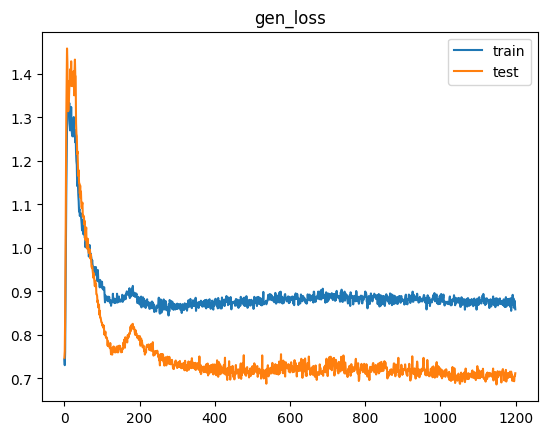

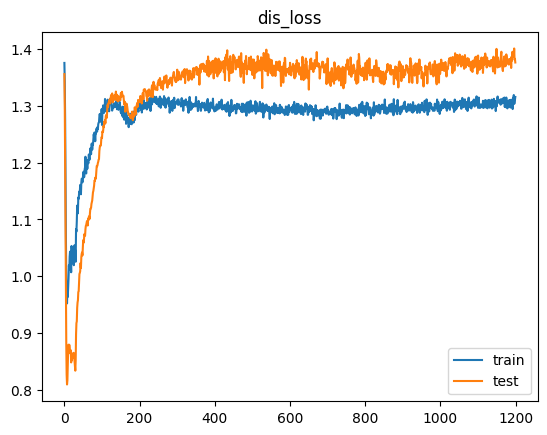

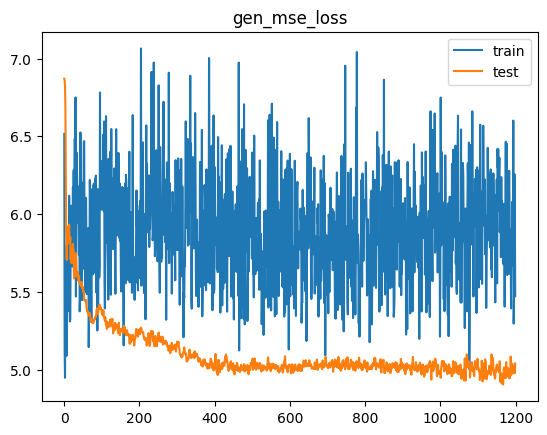

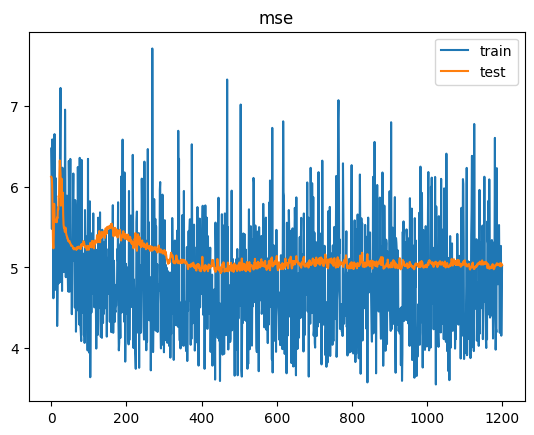

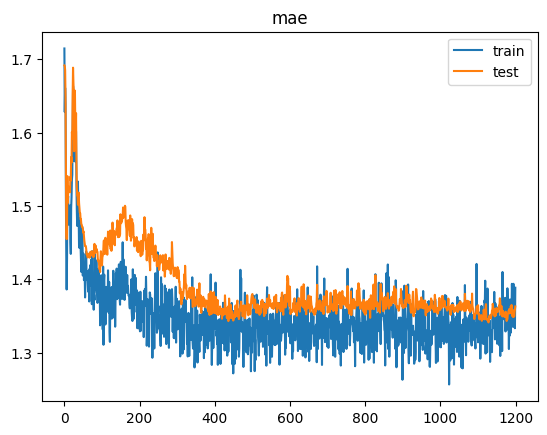

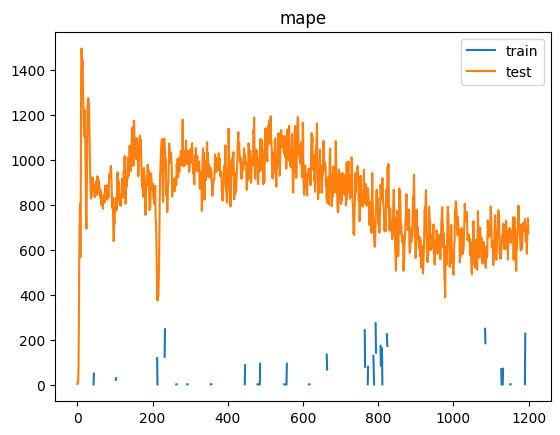

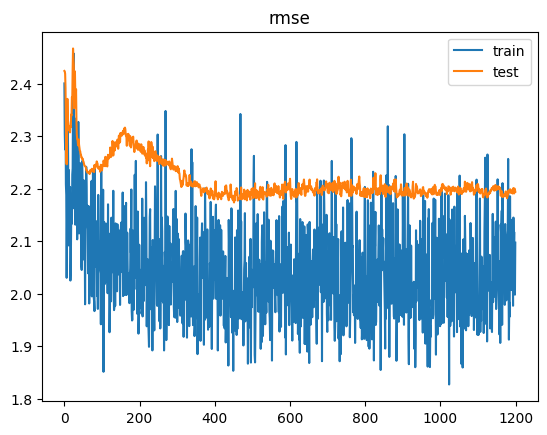

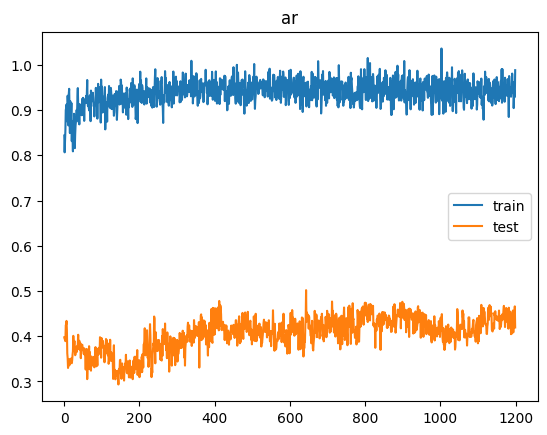

2/2 [==============================] - 0s 3ms/step


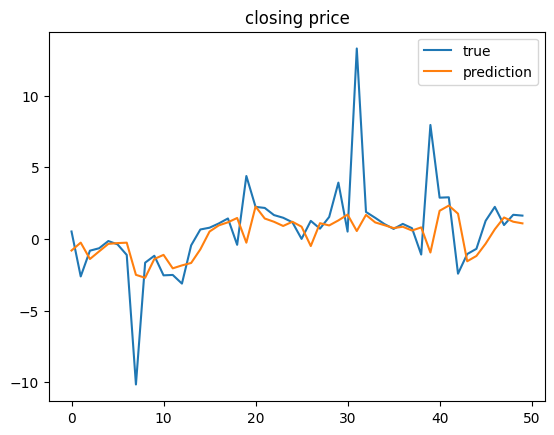

[MSE Baseline] train: 3.6684178098479485  test: 5.010967196008289
Delta time with epochs = 1200: 0:18:56.127442
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 lstm_10 (LSTM)              (None, 5, 10)             720       
                                                                 
 batch_normalization_10 (Bat  (None, 5, 10)            40        
 chNormalization)                                                
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_25 (Dropout)        (None, 5, 10)             0         
                                                                 
 lstm_11 (LST

Time for epoch 52 is 0.8516414165496826 sec Generator Loss: 0.9813228249549866,  Discriminator_loss: 1.2236864566802979
Time for epoch 53 is 0.8184206485748291 sec Generator Loss: 0.9999569058418274,  Discriminator_loss: 1.201600432395935
Time for epoch 54 is 0.8299167156219482 sec Generator Loss: 0.9777510762214661,  Discriminator_loss: 1.2251588106155396
Time for epoch 55 is 0.8402018547058105 sec Generator Loss: 0.9778469800949097,  Discriminator_loss: 1.223696231842041
Time for epoch 56 is 0.8217678070068359 sec Generator Loss: 0.971900224685669,  Discriminator_loss: 1.2314516305923462
Time for epoch 57 is 0.8152995109558105 sec Generator Loss: 0.9619606733322144,  Discriminator_loss: 1.230530858039856
Time for epoch 58 is 0.8468225002288818 sec Generator Loss: 0.9571065902709961,  Discriminator_loss: 1.2374752759933472
Time for epoch 59 is 0.8350353240966797 sec Generator Loss: 0.9474701285362244,  Discriminator_loss: 1.2490397691726685
Time for epoch 60 is 0.8282122611999512 sec 

Time for epoch 121 is 0.8798229694366455 sec Generator Loss: 0.8520523309707642,  Discriminator_loss: 1.3106940984725952
Time for epoch 122 is 0.9447054862976074 sec Generator Loss: 0.8652570843696594,  Discriminator_loss: 1.3110078573226929
Time for epoch 123 is 0.9325249195098877 sec Generator Loss: 0.8554548025131226,  Discriminator_loss: 1.3219610452651978
Time for epoch 124 is 0.931694507598877 sec Generator Loss: 0.8585895895957947,  Discriminator_loss: 1.3105993270874023
Time for epoch 125 is 0.9380342960357666 sec Generator Loss: 0.8499915599822998,  Discriminator_loss: 1.3216757774353027
Time for epoch 126 is 0.9367494583129883 sec Generator Loss: 0.8440728187561035,  Discriminator_loss: 1.322616457939148
Time for epoch 127 is 0.9605121612548828 sec Generator Loss: 0.8534327149391174,  Discriminator_loss: 1.3138015270233154
Time for epoch 128 is 0.9524259567260742 sec Generator Loss: 0.8474099636077881,  Discriminator_loss: 1.323106050491333
Time for epoch 129 is 0.92542195320

Time for epoch 189 is 0.927009105682373 sec Generator Loss: 0.8456602692604065,  Discriminator_loss: 1.3263458013534546
Time for epoch 190 is 0.8409686088562012 sec Generator Loss: 0.8517463803291321,  Discriminator_loss: 1.3143736124038696
Time for epoch 191 is 0.8420376777648926 sec Generator Loss: 0.8511075377464294,  Discriminator_loss: 1.3205597400665283
Time for epoch 192 is 0.8236203193664551 sec Generator Loss: 0.8483628034591675,  Discriminator_loss: 1.3144813776016235
Time for epoch 193 is 0.8751833438873291 sec Generator Loss: 0.8459501266479492,  Discriminator_loss: 1.3187092542648315
Time for epoch 194 is 0.8510637283325195 sec Generator Loss: 0.8495698571205139,  Discriminator_loss: 1.319347620010376
Time for epoch 195 is 0.8119096755981445 sec Generator Loss: 0.8538140654563904,  Discriminator_loss: 1.3119460344314575
Time for epoch 196 is 0.8253886699676514 sec Generator Loss: 0.8485918045043945,  Discriminator_loss: 1.3187607526779175
Time for epoch 197 is 0.8362863063

Time for epoch 257 is 0.853344202041626 sec Generator Loss: 0.8496452569961548,  Discriminator_loss: 1.314422607421875
Time for epoch 258 is 0.8564989566802979 sec Generator Loss: 0.8559026718139648,  Discriminator_loss: 1.31751549243927
Time for epoch 259 is 0.8443846702575684 sec Generator Loss: 0.8691167235374451,  Discriminator_loss: 1.3070586919784546
Time for epoch 260 is 0.8381052017211914 sec Generator Loss: 0.8511013984680176,  Discriminator_loss: 1.3074856996536255
Time for epoch 261 is 0.8393986225128174 sec Generator Loss: 0.8634876012802124,  Discriminator_loss: 1.3031141757965088
Time for epoch 262 is 0.8364315032958984 sec Generator Loss: 0.8589661121368408,  Discriminator_loss: 1.3172060251235962
Time for epoch 263 is 0.8811278343200684 sec Generator Loss: 0.8563395738601685,  Discriminator_loss: 1.3096612691879272
Time for epoch 264 is 0.8480250835418701 sec Generator Loss: 0.8611025810241699,  Discriminator_loss: 1.3030065298080444
Time for epoch 265 is 0.835582494735

Time for epoch 325 is 0.8135566711425781 sec Generator Loss: 0.8726823329925537,  Discriminator_loss: 1.300754427909851
Time for epoch 326 is 0.8166675567626953 sec Generator Loss: 0.86026930809021,  Discriminator_loss: 1.3034509420394897
Time for epoch 327 is 0.8305370807647705 sec Generator Loss: 0.8698247075080872,  Discriminator_loss: 1.3055821657180786
Time for epoch 328 is 0.837965726852417 sec Generator Loss: 0.8611173033714294,  Discriminator_loss: 1.3115739822387695
Time for epoch 329 is 0.8195006847381592 sec Generator Loss: 0.8667188286781311,  Discriminator_loss: 1.3010436296463013
Time for epoch 330 is 0.8459796905517578 sec Generator Loss: 0.8679021596908569,  Discriminator_loss: 1.311442494392395
Time for epoch 331 is 0.8180563449859619 sec Generator Loss: 0.865838348865509,  Discriminator_loss: 1.3102085590362549
Time for epoch 332 is 0.8551104068756104 sec Generator Loss: 0.8539230823516846,  Discriminator_loss: 1.3097620010375977
Time for epoch 333 is 0.82567119598388

Time for epoch 394 is 0.9674875736236572 sec Generator Loss: 0.8632040023803711,  Discriminator_loss: 1.2998757362365723
Time for epoch 395 is 0.9381790161132812 sec Generator Loss: 0.8650193214416504,  Discriminator_loss: 1.3073492050170898
Time for epoch 396 is 0.9375853538513184 sec Generator Loss: 0.8664953708648682,  Discriminator_loss: 1.296850562095642
Time for epoch 397 is 0.9299061298370361 sec Generator Loss: 0.8627813458442688,  Discriminator_loss: 1.3013482093811035
Time for epoch 398 is 0.9214572906494141 sec Generator Loss: 0.8675947189331055,  Discriminator_loss: 1.3004205226898193
Time for epoch 399 is 0.9242684841156006 sec Generator Loss: 0.8720911741256714,  Discriminator_loss: 1.296000361442566
Time for epoch 400 is 0.9678411483764648 sec Generator Loss: 0.8750747442245483,  Discriminator_loss: 1.294579029083252
Time for epoch 401 is 0.9498515129089355 sec Generator Loss: 0.8778244256973267,  Discriminator_loss: 1.299368143081665
Time for epoch 402 is 0.954560995101

Time for epoch 462 is 0.8173966407775879 sec Generator Loss: 0.8738226294517517,  Discriminator_loss: 1.2955724000930786
Time for epoch 463 is 0.8412537574768066 sec Generator Loss: 0.8779553771018982,  Discriminator_loss: 1.2965264320373535
Time for epoch 464 is 0.853797197341919 sec Generator Loss: 0.8904165625572205,  Discriminator_loss: 1.2897742986679077
Time for epoch 465 is 0.8369898796081543 sec Generator Loss: 0.8760586977005005,  Discriminator_loss: 1.3002650737762451
Time for epoch 466 is 0.8356940746307373 sec Generator Loss: 0.8670294880867004,  Discriminator_loss: 1.2915202379226685
Time for epoch 467 is 0.8836119174957275 sec Generator Loss: 0.8720846772193909,  Discriminator_loss: 1.3036469221115112
Time for epoch 468 is 0.8201766014099121 sec Generator Loss: 0.8714629411697388,  Discriminator_loss: 1.2943565845489502
Time for epoch 469 is 0.8496768474578857 sec Generator Loss: 0.8826112747192383,  Discriminator_loss: 1.2956446409225464
Time for epoch 470 is 0.848892211

Time for epoch 531 is 0.9027500152587891 sec Generator Loss: 0.872286856174469,  Discriminator_loss: 1.2894647121429443
Time for epoch 532 is 0.9093172550201416 sec Generator Loss: 0.8751623630523682,  Discriminator_loss: 1.2930700778961182
Time for epoch 533 is 0.9936118125915527 sec Generator Loss: 0.885351300239563,  Discriminator_loss: 1.2859987020492554
Time for epoch 534 is 0.9579627513885498 sec Generator Loss: 0.8917092680931091,  Discriminator_loss: 1.2846288681030273
Time for epoch 535 is 0.9600367546081543 sec Generator Loss: 0.8952576518058777,  Discriminator_loss: 1.2845661640167236
Time for epoch 536 is 0.8984451293945312 sec Generator Loss: 0.8893479108810425,  Discriminator_loss: 1.2882106304168701
Time for epoch 537 is 0.9049382209777832 sec Generator Loss: 0.897579550743103,  Discriminator_loss: 1.2872021198272705
Time for epoch 538 is 0.8889212608337402 sec Generator Loss: 0.8801013231277466,  Discriminator_loss: 1.3081103563308716
Time for epoch 539 is 0.91446113586

Time for epoch 600 is 0.8586034774780273 sec Generator Loss: 0.8764072060585022,  Discriminator_loss: 1.293516755104065
Time for epoch 601 is 0.8649015426635742 sec Generator Loss: 0.8841158151626587,  Discriminator_loss: 1.2900662422180176
Time for epoch 602 is 0.8794350624084473 sec Generator Loss: 0.8872291445732117,  Discriminator_loss: 1.2929600477218628
Time for epoch 603 is 0.8653857707977295 sec Generator Loss: 0.889740526676178,  Discriminator_loss: 1.2834280729293823
Time for epoch 604 is 0.936347246170044 sec Generator Loss: 0.8926470279693604,  Discriminator_loss: 1.2932640314102173
Time for epoch 605 is 0.8655893802642822 sec Generator Loss: 0.8906551003456116,  Discriminator_loss: 1.29232919216156
Time for epoch 606 is 0.9071156978607178 sec Generator Loss: 0.8882350325584412,  Discriminator_loss: 1.2894800901412964
Time for epoch 607 is 0.8920361995697021 sec Generator Loss: 0.8954682946205139,  Discriminator_loss: 1.2939081192016602
Time for epoch 608 is 0.8657953739166

Time for epoch 669 is 0.8804538249969482 sec Generator Loss: 0.9002426862716675,  Discriminator_loss: 1.2871549129486084
Time for epoch 670 is 0.8721427917480469 sec Generator Loss: 0.8878973722457886,  Discriminator_loss: 1.2933930158615112
Time for epoch 671 is 0.858339786529541 sec Generator Loss: 0.8905038833618164,  Discriminator_loss: 1.2954142093658447
Time for epoch 672 is 0.8587641716003418 sec Generator Loss: 0.8920937776565552,  Discriminator_loss: 1.293640375137329
Time for epoch 673 is 0.866978645324707 sec Generator Loss: 0.8735759258270264,  Discriminator_loss: 1.2944676876068115
Time for epoch 674 is 0.8824312686920166 sec Generator Loss: 0.8996482491493225,  Discriminator_loss: 1.2858213186264038
Time for epoch 675 is 0.852961540222168 sec Generator Loss: 0.8940026164054871,  Discriminator_loss: 1.2871900796890259
Time for epoch 676 is 0.8796231746673584 sec Generator Loss: 0.9017715454101562,  Discriminator_loss: 1.2894386053085327
Time for epoch 677 is 0.858070373535

Time for epoch 737 is 0.897777795791626 sec Generator Loss: 0.8872877359390259,  Discriminator_loss: 1.2954373359680176
Time for epoch 738 is 0.890143632888794 sec Generator Loss: 0.8834757804870605,  Discriminator_loss: 1.2928643226623535
Time for epoch 739 is 0.846050500869751 sec Generator Loss: 0.8947129845619202,  Discriminator_loss: 1.2872518301010132
Time for epoch 740 is 0.8813257217407227 sec Generator Loss: 0.8952364921569824,  Discriminator_loss: 1.281967043876648
Time for epoch 741 is 0.8626163005828857 sec Generator Loss: 0.8926498293876648,  Discriminator_loss: 1.2838222980499268
Time for epoch 742 is 0.8646707534790039 sec Generator Loss: 0.895998477935791,  Discriminator_loss: 1.28862464427948
Time for epoch 743 is 0.924929141998291 sec Generator Loss: 0.9012380838394165,  Discriminator_loss: 1.28531813621521
Time for epoch 744 is 0.8919453620910645 sec Generator Loss: 0.8823002576828003,  Discriminator_loss: 1.2935339212417603
Time for epoch 745 is 0.8579764366149902 s

Time for epoch 806 is 0.9576930999755859 sec Generator Loss: 0.9005922675132751,  Discriminator_loss: 1.2746953964233398
Time for epoch 807 is 0.9304478168487549 sec Generator Loss: 0.8945602178573608,  Discriminator_loss: 1.2979854345321655
Time for epoch 808 is 0.9754586219787598 sec Generator Loss: 0.8876885175704956,  Discriminator_loss: 1.2910150289535522
Time for epoch 809 is 0.9575772285461426 sec Generator Loss: 0.9033676385879517,  Discriminator_loss: 1.2849314212799072
Time for epoch 810 is 0.9407219886779785 sec Generator Loss: 0.8912602663040161,  Discriminator_loss: 1.293047547340393
Time for epoch 811 is 0.9413142204284668 sec Generator Loss: 0.8964457511901855,  Discriminator_loss: 1.277030110359192
Time for epoch 812 is 0.8540501594543457 sec Generator Loss: 0.8927305340766907,  Discriminator_loss: 1.286230444908142
Time for epoch 813 is 0.9429032802581787 sec Generator Loss: 0.8898123502731323,  Discriminator_loss: 1.2886847257614136
Time for epoch 814 is 0.95818042755

Time for epoch 875 is 1.0408341884613037 sec Generator Loss: 0.8991822600364685,  Discriminator_loss: 1.2837672233581543
Time for epoch 876 is 1.1550297737121582 sec Generator Loss: 0.8823708891868591,  Discriminator_loss: 1.2888861894607544
Time for epoch 877 is 1.2542431354522705 sec Generator Loss: 0.8985515236854553,  Discriminator_loss: 1.2791613340377808
Time for epoch 878 is 1.2519166469573975 sec Generator Loss: 0.9025468826293945,  Discriminator_loss: 1.2856448888778687
Time for epoch 879 is 1.1793286800384521 sec Generator Loss: 0.8906040787696838,  Discriminator_loss: 1.2781378030776978
Time for epoch 880 is 1.1411347389221191 sec Generator Loss: 0.9032734632492065,  Discriminator_loss: 1.2886515855789185
Time for epoch 881 is 1.0623242855072021 sec Generator Loss: 0.8990616798400879,  Discriminator_loss: 1.290395736694336
Time for epoch 882 is 1.046708106994629 sec Generator Loss: 0.9000108242034912,  Discriminator_loss: 1.2890723943710327
Time for epoch 883 is 1.1532676219

Time for epoch 943 is 0.9659991264343262 sec Generator Loss: 0.8935917615890503,  Discriminator_loss: 1.2779779434204102
Time for epoch 944 is 0.9129457473754883 sec Generator Loss: 0.8979962468147278,  Discriminator_loss: 1.2786006927490234
Time for epoch 945 is 0.937896728515625 sec Generator Loss: 0.8992680907249451,  Discriminator_loss: 1.2828657627105713
Time for epoch 946 is 0.9161748886108398 sec Generator Loss: 0.9053348302841187,  Discriminator_loss: 1.2910696268081665
Time for epoch 947 is 0.9329404830932617 sec Generator Loss: 0.9014456272125244,  Discriminator_loss: 1.2872651815414429
Time for epoch 948 is 0.9101114273071289 sec Generator Loss: 0.8956423997879028,  Discriminator_loss: 1.2795403003692627
Time for epoch 949 is 0.9389998912811279 sec Generator Loss: 0.9091167449951172,  Discriminator_loss: 1.280655860900879
Time for epoch 950 is 0.9571666717529297 sec Generator Loss: 0.9140609502792358,  Discriminator_loss: 1.2794374227523804
Time for epoch 951 is 0.9708979129

Time for epoch 1011 is 1.1496245861053467 sec Generator Loss: 0.8894805908203125,  Discriminator_loss: 1.2985553741455078
Time for epoch 1012 is 0.9199557304382324 sec Generator Loss: 0.8949493765830994,  Discriminator_loss: 1.282694697380066
Time for epoch 1013 is 1.05373215675354 sec Generator Loss: 0.8871064186096191,  Discriminator_loss: 1.294191837310791
Time for epoch 1014 is 1.0029065608978271 sec Generator Loss: 0.8780530691146851,  Discriminator_loss: 1.2915359735488892
Time for epoch 1015 is 1.1424131393432617 sec Generator Loss: 0.8923925757408142,  Discriminator_loss: 1.282286286354065
Time for epoch 1016 is 1.1516482830047607 sec Generator Loss: 0.9021896719932556,  Discriminator_loss: 1.2917497158050537
Time for epoch 1017 is 1.2051010131835938 sec Generator Loss: 0.8960024118423462,  Discriminator_loss: 1.2951617240905762
Time for epoch 1018 is 1.1509277820587158 sec Generator Loss: 0.8842838406562805,  Discriminator_loss: 1.2956132888793945
Time for epoch 1019 is 1.1622

Time for epoch 1079 is 0.9770424365997314 sec Generator Loss: 0.8989728689193726,  Discriminator_loss: 1.2756237983703613
Time for epoch 1080 is 0.9719624519348145 sec Generator Loss: 0.8967764973640442,  Discriminator_loss: 1.2850953340530396
Time for epoch 1081 is 0.9672949314117432 sec Generator Loss: 0.9086381196975708,  Discriminator_loss: 1.2881542444229126
Time for epoch 1082 is 0.9178891181945801 sec Generator Loss: 0.9039246439933777,  Discriminator_loss: 1.281748652458191
Time for epoch 1083 is 0.9895381927490234 sec Generator Loss: 0.8981447815895081,  Discriminator_loss: 1.287273645401001
Time for epoch 1084 is 0.9540836811065674 sec Generator Loss: 0.8939245939254761,  Discriminator_loss: 1.2821171283721924
Time for epoch 1085 is 0.9529464244842529 sec Generator Loss: 0.8819782137870789,  Discriminator_loss: 1.2934445142745972
Time for epoch 1086 is 1.0370111465454102 sec Generator Loss: 0.9064248204231262,  Discriminator_loss: 1.2927629947662354
Time for epoch 1087 is 0.9

Time for epoch 1147 is 1.0023281574249268 sec Generator Loss: 0.8909927606582642,  Discriminator_loss: 1.291715383529663
Time for epoch 1148 is 0.9963960647583008 sec Generator Loss: 0.9082483649253845,  Discriminator_loss: 1.272485613822937
Time for epoch 1149 is 1.0422120094299316 sec Generator Loss: 0.9052203893661499,  Discriminator_loss: 1.2718578577041626
Time for epoch 1150 is 1.024911880493164 sec Generator Loss: 0.9148032069206238,  Discriminator_loss: 1.2888801097869873
Time for epoch 1151 is 1.0267705917358398 sec Generator Loss: 0.9026562571525574,  Discriminator_loss: 1.2733910083770752
Time for epoch 1152 is 1.0178890228271484 sec Generator Loss: 0.9116564393043518,  Discriminator_loss: 1.272034764289856
Time for epoch 1153 is 0.9898760318756104 sec Generator Loss: 0.8825485110282898,  Discriminator_loss: 1.2957426309585571
Time for epoch 1154 is 1.0434041023254395 sec Generator Loss: 0.8968393802642822,  Discriminator_loss: 1.2811120748519897
Time for epoch 1155 is 1.019

Time for epoch 1215 is 0.9269886016845703 sec Generator Loss: 0.9053028225898743,  Discriminator_loss: 1.2874133586883545
Time for epoch 1216 is 0.893740177154541 sec Generator Loss: 0.9036344885826111,  Discriminator_loss: 1.2810686826705933
Time for epoch 1217 is 0.9538812637329102 sec Generator Loss: 0.9094505906105042,  Discriminator_loss: 1.2783925533294678
Time for epoch 1218 is 1.036449909210205 sec Generator Loss: 0.91008061170578,  Discriminator_loss: 1.2836766242980957
Time for epoch 1219 is 0.9399337768554688 sec Generator Loss: 0.914661169052124,  Discriminator_loss: 1.2696902751922607
Time for epoch 1220 is 0.9564337730407715 sec Generator Loss: 0.9070644378662109,  Discriminator_loss: 1.2816691398620605
Time for epoch 1221 is 0.9370064735412598 sec Generator Loss: 0.8905190825462341,  Discriminator_loss: 1.2823035717010498
Time for epoch 1222 is 0.9501309394836426 sec Generator Loss: 0.898832380771637,  Discriminator_loss: 1.286629319190979
Time for epoch 1223 is 0.953932

Time for epoch 1283 is 0.9045202732086182 sec Generator Loss: 0.886335015296936,  Discriminator_loss: 1.2944202423095703
Time for epoch 1284 is 0.9249203205108643 sec Generator Loss: 0.902809202671051,  Discriminator_loss: 1.2770402431488037
Time for epoch 1285 is 0.9344232082366943 sec Generator Loss: 0.8983730673789978,  Discriminator_loss: 1.2848514318466187
Time for epoch 1286 is 0.9205582141876221 sec Generator Loss: 0.9092482924461365,  Discriminator_loss: 1.2727868556976318
Time for epoch 1287 is 0.9774699211120605 sec Generator Loss: 0.9020407199859619,  Discriminator_loss: 1.2879515886306763
Time for epoch 1288 is 0.9305567741394043 sec Generator Loss: 0.8977504372596741,  Discriminator_loss: 1.2850817441940308
Time for epoch 1289 is 0.9079480171203613 sec Generator Loss: 0.8981092572212219,  Discriminator_loss: 1.2820603847503662
Time for epoch 1290 is 0.9630656242370605 sec Generator Loss: 0.9063995480537415,  Discriminator_loss: 1.2827818393707275
Time for epoch 1291 is 0.9

Time for epoch 1351 is 1.0520763397216797 sec Generator Loss: 0.9198765754699707,  Discriminator_loss: 1.2717939615249634
Time for epoch 1352 is 1.0454370975494385 sec Generator Loss: 0.925096869468689,  Discriminator_loss: 1.2687149047851562
Time for epoch 1353 is 1.0239489078521729 sec Generator Loss: 0.9142917394638062,  Discriminator_loss: 1.2698715925216675
Time for epoch 1354 is 1.035853624343872 sec Generator Loss: 0.9236370325088501,  Discriminator_loss: 1.2775373458862305
Time for epoch 1355 is 1.0263347625732422 sec Generator Loss: 0.9157935976982117,  Discriminator_loss: 1.276733636856079
Time for epoch 1356 is 1.0964512825012207 sec Generator Loss: 0.9175113439559937,  Discriminator_loss: 1.2806397676467896
Time for epoch 1357 is 1.0498089790344238 sec Generator Loss: 0.9230712056159973,  Discriminator_loss: 1.2834488153457642
Time for epoch 1358 is 1.0749843120574951 sec Generator Loss: 0.9116932153701782,  Discriminator_loss: 1.2705320119857788
Time for epoch 1359 is 1.01

Time for epoch 1419 is 0.8955180644989014 sec Generator Loss: 0.9160521030426025,  Discriminator_loss: 1.2824769020080566
Time for epoch 1420 is 0.8916699886322021 sec Generator Loss: 0.9025341272354126,  Discriminator_loss: 1.2904512882232666
Time for epoch 1421 is 0.8856105804443359 sec Generator Loss: 0.9158383011817932,  Discriminator_loss: 1.2803356647491455
Time for epoch 1422 is 0.8910403251647949 sec Generator Loss: 0.9119488596916199,  Discriminator_loss: 1.2799044847488403
Time for epoch 1423 is 0.8737301826477051 sec Generator Loss: 0.9241098761558533,  Discriminator_loss: 1.2684069871902466
Time for epoch 1424 is 1.0148842334747314 sec Generator Loss: 0.922269880771637,  Discriminator_loss: 1.2679351568222046
Time for epoch 1425 is 1.160759449005127 sec Generator Loss: 0.9209437370300293,  Discriminator_loss: 1.2689529657363892
Time for epoch 1426 is 1.1364564895629883 sec Generator Loss: 0.9152283668518066,  Discriminator_loss: 1.2680752277374268
Time for epoch 1427 is 1.0

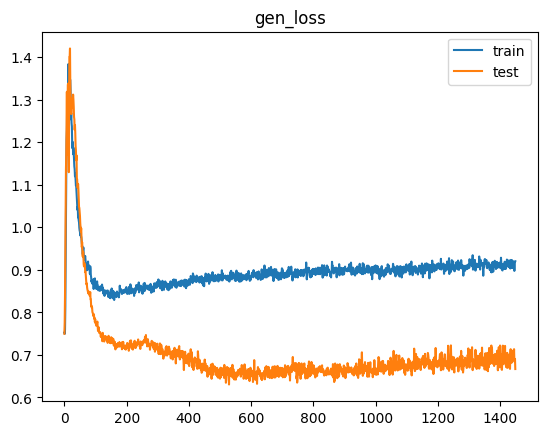

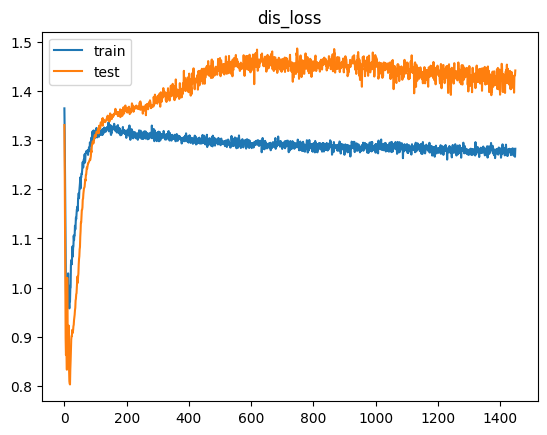

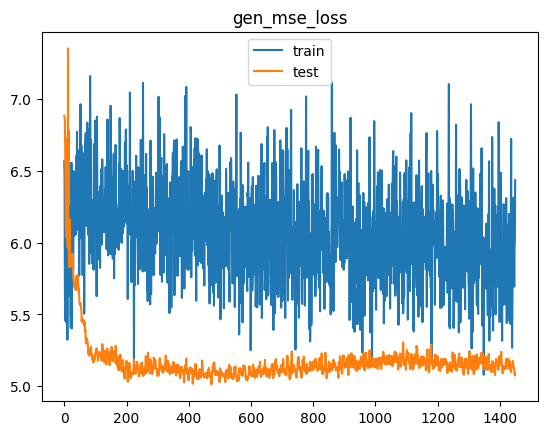

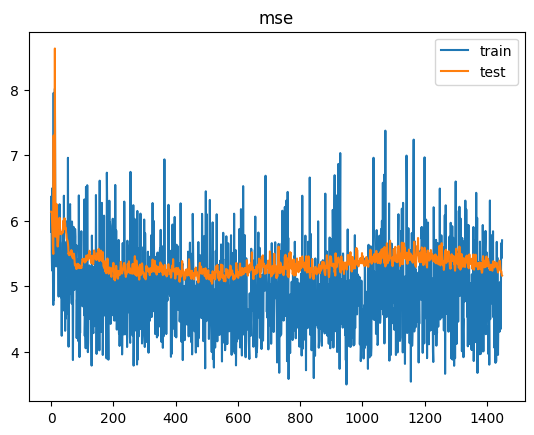

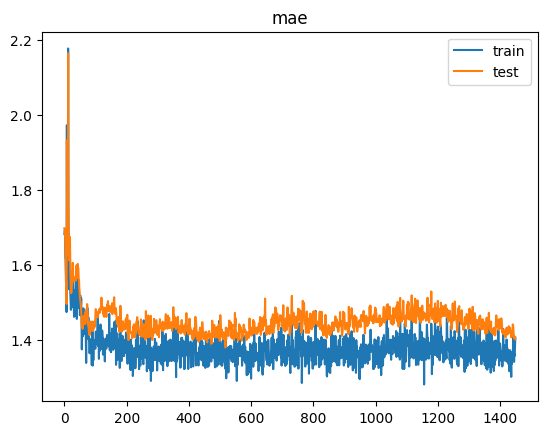

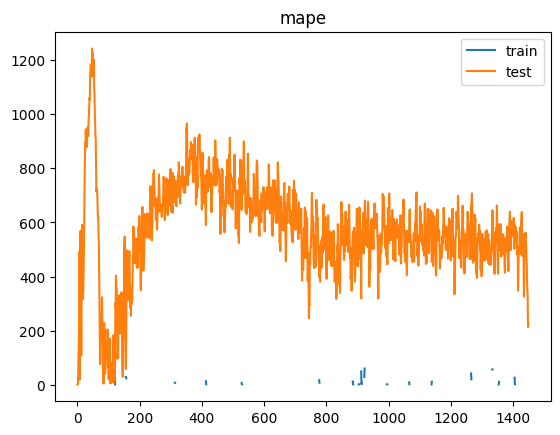

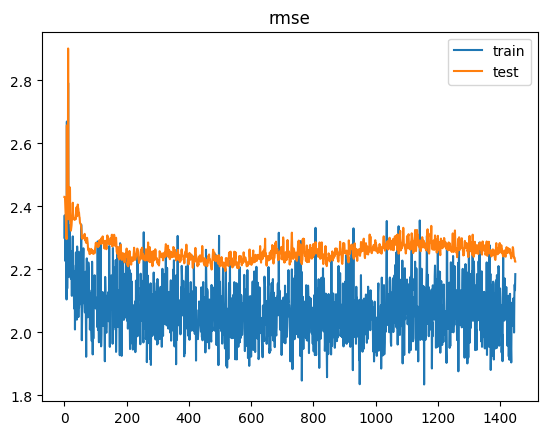

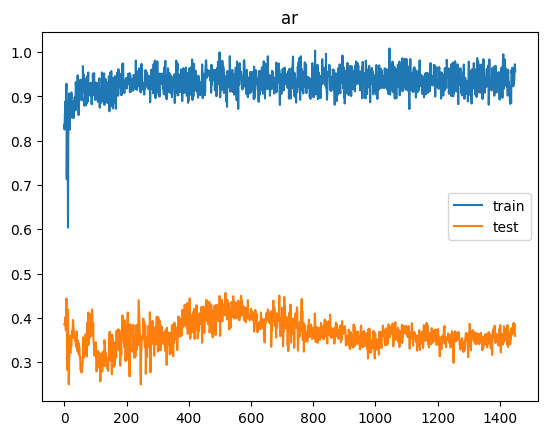

2/2 [==============================] - 0s 5ms/step


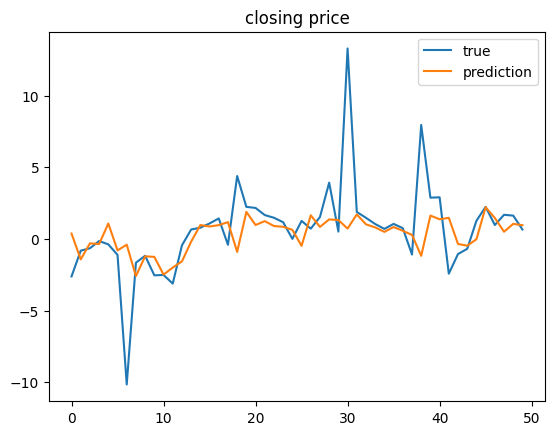

[MSE Baseline] train: 3.6967722227491153  test: 5.023830941163814
Delta time with epochs = 1450: 0:23:04.944901


In [21]:
for epochs in [950, 1200, 1450]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("lstm_ffnn_epochs_{0}.h5".format(epochs))

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 lstm_12 (LSTM)              (None, 5, 10)             720       
                                                                 
 batch_normalization_12 (Bat  (None, 5, 10)            40        
 chNormalization)                                                
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_30 (Dropout)        (None, 5, 10)             0         
                                                                 
 lstm_13 (LSTM)              (None, 10)                840       
                                                           

Time for epoch 53 is 0.8988606929779053 sec Generator Loss: 1.0199111700057983,  Discriminator_loss: 1.175794005393982
Time for epoch 54 is 0.8791558742523193 sec Generator Loss: 1.0210380554199219,  Discriminator_loss: 1.1830583810806274
Time for epoch 55 is 0.8852443695068359 sec Generator Loss: 1.0036795139312744,  Discriminator_loss: 1.1991394758224487
Time for epoch 56 is 0.8852329254150391 sec Generator Loss: 1.0141159296035767,  Discriminator_loss: 1.2046136856079102
Time for epoch 57 is 0.8838160037994385 sec Generator Loss: 0.9868892431259155,  Discriminator_loss: 1.208867073059082
Time for epoch 58 is 0.8944058418273926 sec Generator Loss: 0.988815188407898,  Discriminator_loss: 1.2051013708114624
Time for epoch 59 is 0.886955738067627 sec Generator Loss: 0.9791240692138672,  Discriminator_loss: 1.2084375619888306
Time for epoch 60 is 0.8680222034454346 sec Generator Loss: 0.9753868579864502,  Discriminator_loss: 1.2174433469772339
Time for epoch 61 is 0.9044597148895264 sec 

Time for epoch 122 is 0.8905496597290039 sec Generator Loss: 0.9081974029541016,  Discriminator_loss: 1.3028204441070557
Time for epoch 123 is 0.8638451099395752 sec Generator Loss: 0.9014159440994263,  Discriminator_loss: 1.2996699810028076
Time for epoch 124 is 0.8937506675720215 sec Generator Loss: 0.9021603465080261,  Discriminator_loss: 1.2808939218521118
Time for epoch 125 is 0.9040000438690186 sec Generator Loss: 0.890217125415802,  Discriminator_loss: 1.2999178171157837
Time for epoch 126 is 0.9495604038238525 sec Generator Loss: 0.8917134404182434,  Discriminator_loss: 1.303681492805481
Time for epoch 127 is 0.9113364219665527 sec Generator Loss: 0.8868954181671143,  Discriminator_loss: 1.3003666400909424
Time for epoch 128 is 0.8665647506713867 sec Generator Loss: 0.8809531927108765,  Discriminator_loss: 1.2987213134765625
Time for epoch 129 is 0.8794267177581787 sec Generator Loss: 0.8965527415275574,  Discriminator_loss: 1.2889870405197144
Time for epoch 130 is 0.8872327804

Time for epoch 191 is 0.9727931022644043 sec Generator Loss: 0.8862730860710144,  Discriminator_loss: 1.2858258485794067
Time for epoch 192 is 1.0041146278381348 sec Generator Loss: 0.8953814506530762,  Discriminator_loss: 1.2951302528381348
Time for epoch 193 is 1.0453860759735107 sec Generator Loss: 0.8851580619812012,  Discriminator_loss: 1.2882951498031616
Time for epoch 194 is 1.0147309303283691 sec Generator Loss: 0.8885948657989502,  Discriminator_loss: 1.279478907585144
Time for epoch 195 is 0.9910991191864014 sec Generator Loss: 0.8950312733650208,  Discriminator_loss: 1.2875956296920776
Time for epoch 196 is 0.9848906993865967 sec Generator Loss: 0.893406331539154,  Discriminator_loss: 1.3026596307754517
Time for epoch 197 is 1.0462391376495361 sec Generator Loss: 0.8893389105796814,  Discriminator_loss: 1.2953262329101562
Time for epoch 198 is 1.0091776847839355 sec Generator Loss: 0.8801290988922119,  Discriminator_loss: 1.2930306196212769
Time for epoch 199 is 0.9952733516

Time for epoch 259 is 1.0351190567016602 sec Generator Loss: 0.8753513097763062,  Discriminator_loss: 1.3001224994659424
Time for epoch 260 is 1.035703420639038 sec Generator Loss: 0.8830212354660034,  Discriminator_loss: 1.303928256034851
Time for epoch 261 is 1.0726983547210693 sec Generator Loss: 0.8848497271537781,  Discriminator_loss: 1.2959617376327515
Time for epoch 262 is 1.0731656551361084 sec Generator Loss: 0.8560695648193359,  Discriminator_loss: 1.3083347082138062
Time for epoch 263 is 1.0790066719055176 sec Generator Loss: 0.8721927404403687,  Discriminator_loss: 1.3094468116760254
Time for epoch 264 is 1.036574363708496 sec Generator Loss: 0.8754202127456665,  Discriminator_loss: 1.3024253845214844
Time for epoch 265 is 1.059403419494629 sec Generator Loss: 0.8698613047599792,  Discriminator_loss: 1.2999407052993774
Time for epoch 266 is 1.1203656196594238 sec Generator Loss: 0.8695744872093201,  Discriminator_loss: 1.308276653289795
Time for epoch 267 is 1.0913059711456

Time for epoch 327 is 0.971602201461792 sec Generator Loss: 0.8679192662239075,  Discriminator_loss: 1.309571385383606
Time for epoch 328 is 0.9731299877166748 sec Generator Loss: 0.875690221786499,  Discriminator_loss: 1.2991448640823364
Time for epoch 329 is 1.031442642211914 sec Generator Loss: 0.8711434006690979,  Discriminator_loss: 1.3008160591125488
Time for epoch 330 is 0.9687001705169678 sec Generator Loss: 0.8745210766792297,  Discriminator_loss: 1.3019062280654907
Time for epoch 331 is 1.0624284744262695 sec Generator Loss: 0.8788803219795227,  Discriminator_loss: 1.310826063156128
Time for epoch 332 is 1.0522403717041016 sec Generator Loss: 0.8707818388938904,  Discriminator_loss: 1.2978227138519287
Time for epoch 333 is 1.0781385898590088 sec Generator Loss: 0.877320408821106,  Discriminator_loss: 1.3078570365905762
Time for epoch 334 is 1.0025317668914795 sec Generator Loss: 0.8759834170341492,  Discriminator_loss: 1.299619197845459
Time for epoch 335 is 0.891769170761108

Time for epoch 396 is 1.1258068084716797 sec Generator Loss: 0.8845526576042175,  Discriminator_loss: 1.2941820621490479
Time for epoch 397 is 1.112706184387207 sec Generator Loss: 0.8744258284568787,  Discriminator_loss: 1.3064123392105103
Time for epoch 398 is 1.22025465965271 sec Generator Loss: 0.8935043811798096,  Discriminator_loss: 1.2925409078598022
Time for epoch 399 is 1.2377920150756836 sec Generator Loss: 0.878605306148529,  Discriminator_loss: 1.293370246887207
Time for epoch 400 is 1.123159646987915 sec Generator Loss: 0.8805540204048157,  Discriminator_loss: 1.2996315956115723
Time for epoch 401 is 1.2117743492126465 sec Generator Loss: 0.8901361227035522,  Discriminator_loss: 1.287997841835022
Time for epoch 402 is 1.2315442562103271 sec Generator Loss: 0.9019909501075745,  Discriminator_loss: 1.282310128211975
Time for epoch 403 is 1.246307373046875 sec Generator Loss: 0.8922404646873474,  Discriminator_loss: 1.2956362962722778
Time for epoch 404 is 1.1239948272705078 

Time for epoch 465 is 0.9870123863220215 sec Generator Loss: 0.8725442290306091,  Discriminator_loss: 1.2964752912521362
Time for epoch 466 is 1.0182998180389404 sec Generator Loss: 0.892723560333252,  Discriminator_loss: 1.2872207164764404
Time for epoch 467 is 0.9586234092712402 sec Generator Loss: 0.8944255113601685,  Discriminator_loss: 1.2892601490020752
Time for epoch 468 is 0.955312967300415 sec Generator Loss: 0.8849819302558899,  Discriminator_loss: 1.3035070896148682
Time for epoch 469 is 0.9746792316436768 sec Generator Loss: 0.9037281274795532,  Discriminator_loss: 1.283465027809143
Time for epoch 470 is 0.9928390979766846 sec Generator Loss: 0.8908344507217407,  Discriminator_loss: 1.2903332710266113
Time for epoch 471 is 1.055396318435669 sec Generator Loss: 0.8943771719932556,  Discriminator_loss: 1.2873190641403198
Time for epoch 472 is 1.0944228172302246 sec Generator Loss: 0.8979482650756836,  Discriminator_loss: 1.2772510051727295
Time for epoch 473 is 1.011167049407

Time for epoch 533 is 0.9016246795654297 sec Generator Loss: 0.8834432363510132,  Discriminator_loss: 1.2848234176635742
Time for epoch 534 is 0.9638826847076416 sec Generator Loss: 0.9040318727493286,  Discriminator_loss: 1.2869504690170288
Time for epoch 535 is 0.957038164138794 sec Generator Loss: 0.9009460806846619,  Discriminator_loss: 1.2804681062698364
Time for epoch 536 is 0.9372308254241943 sec Generator Loss: 0.8850188255310059,  Discriminator_loss: 1.2958518266677856
Time for epoch 537 is 0.912769079208374 sec Generator Loss: 0.9006165266036987,  Discriminator_loss: 1.2944202423095703
Time for epoch 538 is 0.9168367385864258 sec Generator Loss: 0.9223204255104065,  Discriminator_loss: 1.2822192907333374
Time for epoch 539 is 0.9330582618713379 sec Generator Loss: 0.8945446014404297,  Discriminator_loss: 1.2898962497711182
Time for epoch 540 is 0.979311466217041 sec Generator Loss: 0.8942446112632751,  Discriminator_loss: 1.284437894821167
Time for epoch 541 is 1.008712530136

Time for epoch 602 is 0.9824285507202148 sec Generator Loss: 0.9100704789161682,  Discriminator_loss: 1.2833354473114014
Time for epoch 603 is 0.9443154335021973 sec Generator Loss: 0.892556369304657,  Discriminator_loss: 1.2883883714675903
Time for epoch 604 is 0.9361917972564697 sec Generator Loss: 0.9110028743743896,  Discriminator_loss: 1.280755639076233
Time for epoch 605 is 0.9726657867431641 sec Generator Loss: 0.9200788140296936,  Discriminator_loss: 1.2725293636322021
Time for epoch 606 is 0.912104606628418 sec Generator Loss: 0.8959984183311462,  Discriminator_loss: 1.2822521924972534
Time for epoch 607 is 0.9414517879486084 sec Generator Loss: 0.9029520153999329,  Discriminator_loss: 1.2874314785003662
Time for epoch 608 is 1.0910592079162598 sec Generator Loss: 0.9113267660140991,  Discriminator_loss: 1.281049132347107
Time for epoch 609 is 1.0009877681732178 sec Generator Loss: 0.9063988327980042,  Discriminator_loss: 1.2819684743881226
Time for epoch 610 is 1.030277490615

Time for epoch 671 is 1.1381750106811523 sec Generator Loss: 0.8966204524040222,  Discriminator_loss: 1.281831979751587
Time for epoch 672 is 1.2321772575378418 sec Generator Loss: 0.9072675108909607,  Discriminator_loss: 1.2860468626022339
Time for epoch 673 is 1.173189640045166 sec Generator Loss: 0.9024720788002014,  Discriminator_loss: 1.2890033721923828
Time for epoch 674 is 1.2897968292236328 sec Generator Loss: 0.8942477107048035,  Discriminator_loss: 1.2921881675720215
Time for epoch 675 is 1.2581167221069336 sec Generator Loss: 0.9050034284591675,  Discriminator_loss: 1.2835179567337036
Time for epoch 676 is 1.1779356002807617 sec Generator Loss: 0.9081315994262695,  Discriminator_loss: 1.2780622243881226
Time for epoch 677 is 1.0664088726043701 sec Generator Loss: 0.8941587805747986,  Discriminator_loss: 1.2873414754867554
Time for epoch 678 is 0.9729359149932861 sec Generator Loss: 0.9079058766365051,  Discriminator_loss: 1.2863829135894775
Time for epoch 679 is 0.9767606258

Time for epoch 739 is 0.9286234378814697 sec Generator Loss: 0.8995838761329651,  Discriminator_loss: 1.2832376956939697
Time for epoch 740 is 0.953925371170044 sec Generator Loss: 0.9051920175552368,  Discriminator_loss: 1.282043218612671
Time for epoch 741 is 0.928056001663208 sec Generator Loss: 0.8978917598724365,  Discriminator_loss: 1.289452075958252
Time for epoch 742 is 0.9538087844848633 sec Generator Loss: 0.9104487895965576,  Discriminator_loss: 1.2845518589019775
Time for epoch 743 is 0.940514087677002 sec Generator Loss: 0.9148791432380676,  Discriminator_loss: 1.2752902507781982
Time for epoch 744 is 0.9874534606933594 sec Generator Loss: 0.9025914669036865,  Discriminator_loss: 1.2854293584823608
Time for epoch 745 is 1.0248064994812012 sec Generator Loss: 0.9102715253829956,  Discriminator_loss: 1.2903962135314941
Time for epoch 746 is 0.9219560623168945 sec Generator Loss: 0.9204009175300598,  Discriminator_loss: 1.2871830463409424
Time for epoch 747 is 0.9503297805786

Time for epoch 808 is 1.0308496952056885 sec Generator Loss: 0.9056205749511719,  Discriminator_loss: 1.279313564300537
Time for epoch 809 is 1.0041818618774414 sec Generator Loss: 0.9060438871383667,  Discriminator_loss: 1.2892615795135498
Time for epoch 810 is 1.0288646221160889 sec Generator Loss: 0.9032400846481323,  Discriminator_loss: 1.2848042249679565
Time for epoch 811 is 0.9915065765380859 sec Generator Loss: 0.8935660719871521,  Discriminator_loss: 1.2953695058822632
Time for epoch 812 is 0.9640734195709229 sec Generator Loss: 0.9078980088233948,  Discriminator_loss: 1.2947657108306885
Time for epoch 813 is 0.9994571208953857 sec Generator Loss: 0.8967927694320679,  Discriminator_loss: 1.296135425567627
Time for epoch 814 is 0.9800515174865723 sec Generator Loss: 0.9116876125335693,  Discriminator_loss: 1.2827491760253906
Time for epoch 815 is 0.9396800994873047 sec Generator Loss: 0.9057530164718628,  Discriminator_loss: 1.2790851593017578
Time for epoch 816 is 1.0273704528

Time for epoch 877 is 0.9890327453613281 sec Generator Loss: 0.9133371710777283,  Discriminator_loss: 1.2768547534942627
Time for epoch 878 is 1.1378536224365234 sec Generator Loss: 0.9043301343917847,  Discriminator_loss: 1.2890539169311523
Time for epoch 879 is 1.1433064937591553 sec Generator Loss: 0.900976300239563,  Discriminator_loss: 1.288012981414795
Time for epoch 880 is 1.1307148933410645 sec Generator Loss: 0.9108424782752991,  Discriminator_loss: 1.2841676473617554
Time for epoch 881 is 1.0183258056640625 sec Generator Loss: 0.8917512893676758,  Discriminator_loss: 1.2841699123382568
Time for epoch 882 is 1.023935317993164 sec Generator Loss: 0.8978690505027771,  Discriminator_loss: 1.2889838218688965
Time for epoch 883 is 1.0007400512695312 sec Generator Loss: 0.9065319299697876,  Discriminator_loss: 1.2903292179107666
Time for epoch 884 is 0.9980549812316895 sec Generator Loss: 0.9092517495155334,  Discriminator_loss: 1.2903720140457153
Time for epoch 885 is 0.99087405204

Time for epoch 946 is 1.2716786861419678 sec Generator Loss: 0.899600625038147,  Discriminator_loss: 1.2859115600585938
Time for epoch 947 is 1.1529161930084229 sec Generator Loss: 0.8909879326820374,  Discriminator_loss: 1.2864811420440674
Time for epoch 948 is 1.081409215927124 sec Generator Loss: 0.8870568871498108,  Discriminator_loss: 1.299386978149414
Time for epoch 949 is 1.0739428997039795 sec Generator Loss: 0.8934549689292908,  Discriminator_loss: 1.294479489326477
Time for epoch 950 is 1.1708102226257324 sec Generator Loss: 0.8947778940200806,  Discriminator_loss: 1.2869020700454712
Time for epoch 951 is 1.3237669467926025 sec Generator Loss: 0.9114572405815125,  Discriminator_loss: 1.2782602310180664
Time for epoch 952 is 1.1341297626495361 sec Generator Loss: 0.8874043226242065,  Discriminator_loss: 1.3039965629577637
Time for epoch 953 is 1.0417556762695312 sec Generator Loss: 0.8925954699516296,  Discriminator_loss: 1.2979234457015991
Time for epoch 954 is 1.092788219451

Time for epoch 1014 is 1.0413978099822998 sec Generator Loss: 0.8900635242462158,  Discriminator_loss: 1.3003737926483154
Time for epoch 1015 is 1.0485541820526123 sec Generator Loss: 0.8960999250411987,  Discriminator_loss: 1.2877012491226196
Time for epoch 1016 is 1.0163421630859375 sec Generator Loss: 0.8844887018203735,  Discriminator_loss: 1.3000127077102661
Time for epoch 1017 is 1.0222325325012207 sec Generator Loss: 0.9028046727180481,  Discriminator_loss: 1.2787590026855469
Time for epoch 1018 is 1.0435791015625 sec Generator Loss: 0.8980096578598022,  Discriminator_loss: 1.2901475429534912
Time for epoch 1019 is 1.080815315246582 sec Generator Loss: 0.9044597744941711,  Discriminator_loss: 1.284394383430481
Time for epoch 1020 is 1.0323967933654785 sec Generator Loss: 0.8892467021942139,  Discriminator_loss: 1.29615318775177
Time for epoch 1021 is 1.0168569087982178 sec Generator Loss: 0.8965387940406799,  Discriminator_loss: 1.2871623039245605
Time for epoch 1022 is 1.046156

Time for epoch 1082 is 1.1475672721862793 sec Generator Loss: 0.8939757943153381,  Discriminator_loss: 1.2881484031677246
Time for epoch 1083 is 1.0711688995361328 sec Generator Loss: 0.9001548290252686,  Discriminator_loss: 1.291372299194336
Time for epoch 1084 is 1.0635170936584473 sec Generator Loss: 0.8872952461242676,  Discriminator_loss: 1.2992751598358154
Time for epoch 1085 is 1.0643506050109863 sec Generator Loss: 0.8883332014083862,  Discriminator_loss: 1.2874592542648315
Time for epoch 1086 is 1.0521249771118164 sec Generator Loss: 0.8914040923118591,  Discriminator_loss: 1.2927806377410889
Time for epoch 1087 is 1.197828769683838 sec Generator Loss: 0.9000565409660339,  Discriminator_loss: 1.2900702953338623
Time for epoch 1088 is 1.203120231628418 sec Generator Loss: 0.8875492811203003,  Discriminator_loss: 1.292230486869812
Time for epoch 1089 is 1.2494072914123535 sec Generator Loss: 0.882573664188385,  Discriminator_loss: 1.3011252880096436
Time for epoch 1090 is 1.2230

Time for epoch 1150 is 1.220641851425171 sec Generator Loss: 0.8950352668762207,  Discriminator_loss: 1.2858284711837769
Time for epoch 1151 is 1.0328717231750488 sec Generator Loss: 0.8921216726303101,  Discriminator_loss: 1.2924312353134155
Time for epoch 1152 is 1.0896453857421875 sec Generator Loss: 0.8966753482818604,  Discriminator_loss: 1.300406813621521
Time for epoch 1153 is 1.0235095024108887 sec Generator Loss: 0.899734377861023,  Discriminator_loss: 1.2933263778686523
Time for epoch 1154 is 1.0754525661468506 sec Generator Loss: 0.8906044960021973,  Discriminator_loss: 1.2943371534347534
Time for epoch 1155 is 1.069873571395874 sec Generator Loss: 0.8902493119239807,  Discriminator_loss: 1.288933277130127
Time for epoch 1156 is 1.1026194095611572 sec Generator Loss: 0.8958439826965332,  Discriminator_loss: 1.2882665395736694
Time for epoch 1157 is 1.1065316200256348 sec Generator Loss: 0.8989729881286621,  Discriminator_loss: 1.286429524421692
Time for epoch 1158 is 1.19602

Time for epoch 1218 is 1.0124821662902832 sec Generator Loss: 0.8867653012275696,  Discriminator_loss: 1.2963720560073853
Time for epoch 1219 is 1.0408520698547363 sec Generator Loss: 0.8965521454811096,  Discriminator_loss: 1.2925812005996704
Time for epoch 1220 is 1.0477676391601562 sec Generator Loss: 0.8998061418533325,  Discriminator_loss: 1.2919080257415771
Time for epoch 1221 is 1.020216464996338 sec Generator Loss: 0.8991817235946655,  Discriminator_loss: 1.284787654876709
Time for epoch 1222 is 1.0111784934997559 sec Generator Loss: 0.8971708416938782,  Discriminator_loss: 1.296190857887268
Time for epoch 1223 is 1.1167900562286377 sec Generator Loss: 0.8907410502433777,  Discriminator_loss: 1.2858911752700806
Time for epoch 1224 is 1.0659058094024658 sec Generator Loss: 0.8959330916404724,  Discriminator_loss: 1.2959812879562378
Time for epoch 1225 is 1.1920874118804932 sec Generator Loss: 0.8922462463378906,  Discriminator_loss: 1.2903169393539429
Time for epoch 1226 is 1.17

Time for epoch 1286 is 1.2490239143371582 sec Generator Loss: 0.9081477522850037,  Discriminator_loss: 1.2887520790100098
Time for epoch 1287 is 1.2423107624053955 sec Generator Loss: 0.8977956175804138,  Discriminator_loss: 1.2923177480697632
Time for epoch 1288 is 1.3277156352996826 sec Generator Loss: 0.9005815982818604,  Discriminator_loss: 1.2864086627960205
Time for epoch 1289 is 1.1078197956085205 sec Generator Loss: 0.894811749458313,  Discriminator_loss: 1.305436611175537
Time for epoch 1290 is 1.0429985523223877 sec Generator Loss: 0.8931460976600647,  Discriminator_loss: 1.288386344909668
Time for epoch 1291 is 1.0660181045532227 sec Generator Loss: 0.9055306911468506,  Discriminator_loss: 1.289415955543518
Time for epoch 1292 is 1.1055102348327637 sec Generator Loss: 0.8908101916313171,  Discriminator_loss: 1.297562599182129
Time for epoch 1293 is 1.1633121967315674 sec Generator Loss: 0.9017807841300964,  Discriminator_loss: 1.2925835847854614
Time for epoch 1294 is 1.1754

Time for epoch 1354 is 1.2006993293762207 sec Generator Loss: 0.9040764570236206,  Discriminator_loss: 1.2929338216781616
Time for epoch 1355 is 1.3503456115722656 sec Generator Loss: 0.8971256613731384,  Discriminator_loss: 1.3006985187530518
Time for epoch 1356 is 1.2546467781066895 sec Generator Loss: 0.889799952507019,  Discriminator_loss: 1.3089460134506226
Time for epoch 1357 is 1.3338980674743652 sec Generator Loss: 0.8913912177085876,  Discriminator_loss: 1.2930012941360474
Time for epoch 1358 is 1.311347246170044 sec Generator Loss: 0.887983500957489,  Discriminator_loss: 1.2939770221710205
Time for epoch 1359 is 1.3358898162841797 sec Generator Loss: 0.90257328748703,  Discriminator_loss: 1.2983014583587646
Time for epoch 1360 is 1.2681350708007812 sec Generator Loss: 0.8833633065223694,  Discriminator_loss: 1.298219919204712
Time for epoch 1361 is 1.2059376239776611 sec Generator Loss: 0.8939682841300964,  Discriminator_loss: 1.2929376363754272
Time for epoch 1362 is 1.26518

Time for epoch 1422 is 1.4323546886444092 sec Generator Loss: 0.8945003151893616,  Discriminator_loss: 1.2932918071746826
Time for epoch 1423 is 1.3531038761138916 sec Generator Loss: 0.8873607516288757,  Discriminator_loss: 1.2968177795410156
Time for epoch 1424 is 1.2541604042053223 sec Generator Loss: 0.8822872042655945,  Discriminator_loss: 1.3011960983276367
Time for epoch 1425 is 1.1076974868774414 sec Generator Loss: 0.8984700441360474,  Discriminator_loss: 1.2898306846618652
Time for epoch 1426 is 1.1647086143493652 sec Generator Loss: 0.8934366106987,  Discriminator_loss: 1.294844388961792
Time for epoch 1427 is 1.1795151233673096 sec Generator Loss: 0.8821642994880676,  Discriminator_loss: 1.297974705696106
Time for epoch 1428 is 1.150996446609497 sec Generator Loss: 0.8784039616584778,  Discriminator_loss: 1.3083828687667847
Time for epoch 1429 is 1.1075210571289062 sec Generator Loss: 0.9010118842124939,  Discriminator_loss: 1.2875523567199707
Time for epoch 1430 is 1.13907

Time for epoch 1490 is 1.0293967723846436 sec Generator Loss: 0.9009595513343811,  Discriminator_loss: 1.2958580255508423
Time for epoch 1491 is 0.9891672134399414 sec Generator Loss: 0.897113561630249,  Discriminator_loss: 1.2915998697280884
Time for epoch 1492 is 1.021982192993164 sec Generator Loss: 0.9020156860351562,  Discriminator_loss: 1.29591703414917
Time for epoch 1493 is 1.0109221935272217 sec Generator Loss: 0.9006286263465881,  Discriminator_loss: 1.3003380298614502
Time for epoch 1494 is 1.024712085723877 sec Generator Loss: 0.9024824500083923,  Discriminator_loss: 1.294777750968933
Time for epoch 1495 is 1.0832862854003906 sec Generator Loss: 0.8947384357452393,  Discriminator_loss: 1.2972396612167358
Time for epoch 1496 is 1.0112433433532715 sec Generator Loss: 0.8947961330413818,  Discriminator_loss: 1.3064026832580566
Time for epoch 1497 is 1.0439462661743164 sec Generator Loss: 0.8898643255233765,  Discriminator_loss: 1.3077815771102905
Time for epoch 1498 is 1.01227

Time for epoch 1558 is 1.002483606338501 sec Generator Loss: 0.8870334029197693,  Discriminator_loss: 1.3047078847885132
Time for epoch 1559 is 1.0447003841400146 sec Generator Loss: 0.8893307447433472,  Discriminator_loss: 1.292410135269165
Time for epoch 1560 is 1.0088212490081787 sec Generator Loss: 0.8854460120201111,  Discriminator_loss: 1.30500328540802
Time for epoch 1561 is 1.1358580589294434 sec Generator Loss: 0.8934497237205505,  Discriminator_loss: 1.2993131875991821
Time for epoch 1562 is 0.9932916164398193 sec Generator Loss: 0.891655445098877,  Discriminator_loss: 1.297656536102295
Time for epoch 1563 is 1.2384095191955566 sec Generator Loss: 0.8990874290466309,  Discriminator_loss: 1.287502646446228
Time for epoch 1564 is 1.02919340133667 sec Generator Loss: 0.8841195106506348,  Discriminator_loss: 1.3024500608444214
Time for epoch 1565 is 1.013472557067871 sec Generator Loss: 0.8869590163230896,  Discriminator_loss: 1.292452096939087
Time for epoch 1566 is 1.0231425762

Time for epoch 1626 is 1.0518603324890137 sec Generator Loss: 0.8940834999084473,  Discriminator_loss: 1.305202603340149
Time for epoch 1627 is 1.1485731601715088 sec Generator Loss: 0.8952866792678833,  Discriminator_loss: 1.2923039197921753
Time for epoch 1628 is 1.0994739532470703 sec Generator Loss: 0.8877995610237122,  Discriminator_loss: 1.301856279373169
Time for epoch 1629 is 1.0591323375701904 sec Generator Loss: 0.891364574432373,  Discriminator_loss: 1.2992522716522217
Time for epoch 1630 is 1.0986502170562744 sec Generator Loss: 0.8878911137580872,  Discriminator_loss: 1.3036713600158691
Time for epoch 1631 is 1.034334421157837 sec Generator Loss: 0.8935826420783997,  Discriminator_loss: 1.2949129343032837
Time for epoch 1632 is 1.0625157356262207 sec Generator Loss: 0.8860888481140137,  Discriminator_loss: 1.2948821783065796
Time for epoch 1633 is 1.0820834636688232 sec Generator Loss: 0.8887289762496948,  Discriminator_loss: 1.2998844385147095
Time for epoch 1634 is 1.111

Time for epoch 1694 is 1.1996228694915771 sec Generator Loss: 0.8918217420578003,  Discriminator_loss: 1.2987208366394043
Time for epoch 1695 is 1.1717936992645264 sec Generator Loss: 0.898432731628418,  Discriminator_loss: 1.29440438747406
Time for epoch 1696 is 1.170393943786621 sec Generator Loss: 0.892008900642395,  Discriminator_loss: 1.2981010675430298
Time for epoch 1697 is 1.2106330394744873 sec Generator Loss: 0.8852286338806152,  Discriminator_loss: 1.3033469915390015
Time for epoch 1698 is 1.1610150337219238 sec Generator Loss: 0.8814356327056885,  Discriminator_loss: 1.2966504096984863
Time for epoch 1699 is 1.1146283149719238 sec Generator Loss: 0.8766254186630249,  Discriminator_loss: 1.2995878458023071
Time for epoch 1700 is 1.4607267379760742 sec Generator Loss: 0.8853794932365417,  Discriminator_loss: 1.3045376539230347


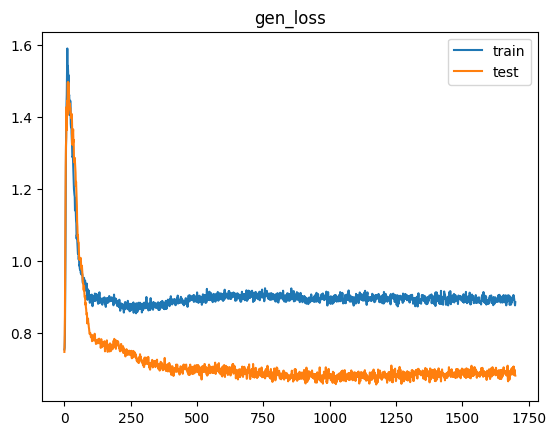

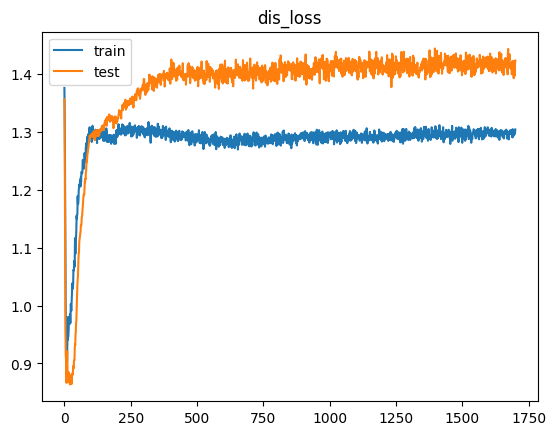

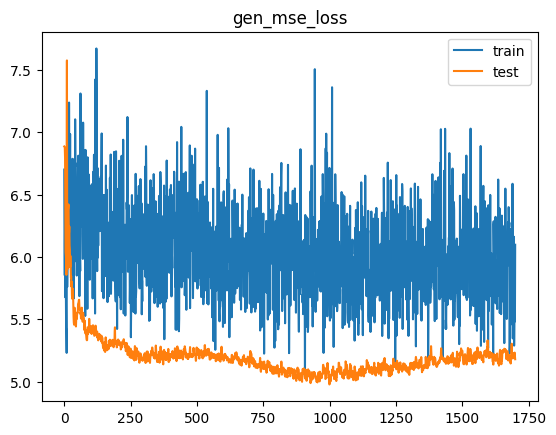

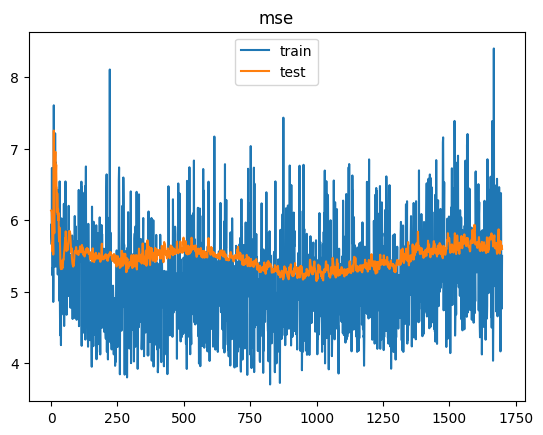

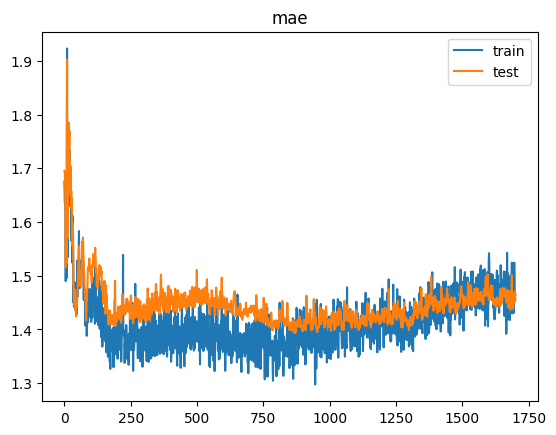

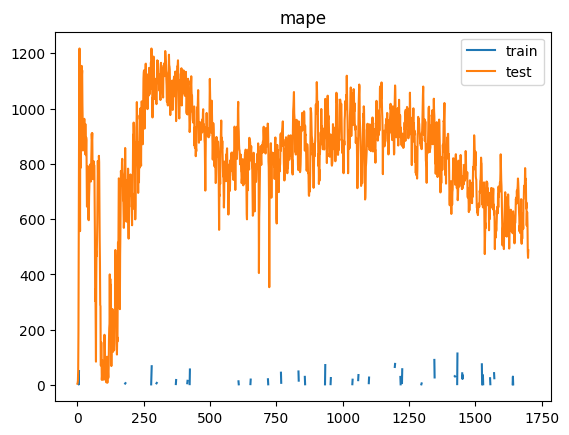

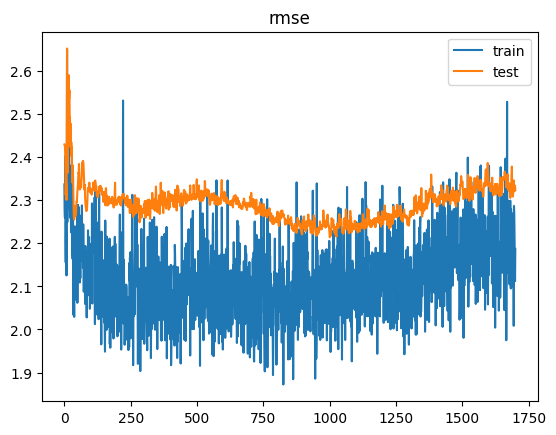

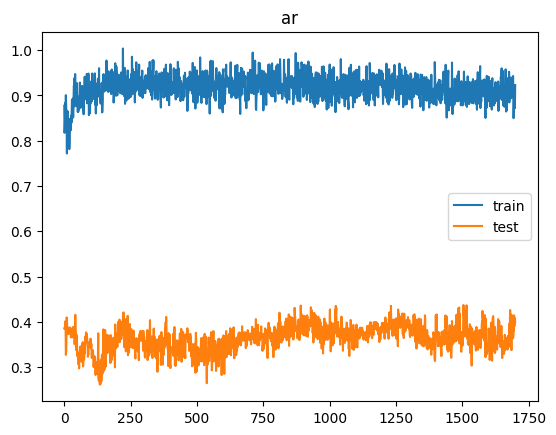

2/2 [==============================] - 0s 5ms/step


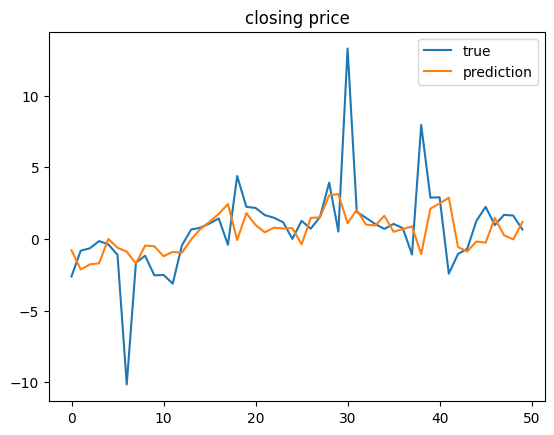

[MSE Baseline] train: 5.882024434649445  test: 5.023830941163814
Delta time with epochs = 1700: 0:30:35.438157
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 lstm_14 (LSTM)              (None, 5, 10)             720       
                                                                 
 batch_normalization_14 (Bat  (None, 5, 10)            40        
 chNormalization)                                                
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_35 (Dropout)        (None, 5, 10)             0         
                                                                 
 lstm_15 (LSTM

Time for epoch 53 is 1.0478172302246094 sec Generator Loss: 1.054608702659607,  Discriminator_loss: 1.1682088375091553
Time for epoch 54 is 1.0465672016143799 sec Generator Loss: 1.0578688383102417,  Discriminator_loss: 1.1809102296829224
Time for epoch 55 is 1.0464558601379395 sec Generator Loss: 1.0606855154037476,  Discriminator_loss: 1.1784255504608154
Time for epoch 56 is 1.035538673400879 sec Generator Loss: 1.0451213121414185,  Discriminator_loss: 1.1830462217330933
Time for epoch 57 is 1.046640157699585 sec Generator Loss: 1.0347204208374023,  Discriminator_loss: 1.185097336769104
Time for epoch 58 is 1.0308761596679688 sec Generator Loss: 1.0444031953811646,  Discriminator_loss: 1.1732218265533447
Time for epoch 59 is 1.0632717609405518 sec Generator Loss: 1.0353286266326904,  Discriminator_loss: 1.1788008213043213
Time for epoch 60 is 1.0246658325195312 sec Generator Loss: 1.0387003421783447,  Discriminator_loss: 1.18540358543396
Time for epoch 61 is 1.0448262691497803 sec Ge

Time for epoch 122 is 1.1230180263519287 sec Generator Loss: 0.9188019633293152,  Discriminator_loss: 1.2842042446136475
Time for epoch 123 is 1.027308702468872 sec Generator Loss: 0.9172910451889038,  Discriminator_loss: 1.2737077474594116
Time for epoch 124 is 1.1220097541809082 sec Generator Loss: 0.9030989408493042,  Discriminator_loss: 1.2845590114593506
Time for epoch 125 is 1.025831937789917 sec Generator Loss: 0.9069376587867737,  Discriminator_loss: 1.2883235216140747
Time for epoch 126 is 1.0586562156677246 sec Generator Loss: 0.9190280437469482,  Discriminator_loss: 1.2695852518081665
Time for epoch 127 is 1.084916353225708 sec Generator Loss: 0.9293130040168762,  Discriminator_loss: 1.2730427980422974
Time for epoch 128 is 1.3735439777374268 sec Generator Loss: 0.9172906875610352,  Discriminator_loss: 1.2673486471176147
Time for epoch 129 is 1.247826099395752 sec Generator Loss: 0.9108045697212219,  Discriminator_loss: 1.2803481817245483
Time for epoch 130 is 1.257275581359

Time for epoch 191 is 1.1129727363586426 sec Generator Loss: 0.8763188719749451,  Discriminator_loss: 1.293668508529663
Time for epoch 192 is 1.1553611755371094 sec Generator Loss: 0.8909101486206055,  Discriminator_loss: 1.2870665788650513
Time for epoch 193 is 1.137352705001831 sec Generator Loss: 0.8884122967720032,  Discriminator_loss: 1.2924084663391113
Time for epoch 194 is 1.195746660232544 sec Generator Loss: 0.8900505304336548,  Discriminator_loss: 1.293768286705017
Time for epoch 195 is 1.093557357788086 sec Generator Loss: 0.8849820494651794,  Discriminator_loss: 1.2934578657150269
Time for epoch 196 is 1.078676462173462 sec Generator Loss: 0.8854169249534607,  Discriminator_loss: 1.2920958995819092
Time for epoch 197 is 1.0799801349639893 sec Generator Loss: 0.8869994878768921,  Discriminator_loss: 1.2885127067565918
Time for epoch 198 is 1.0633857250213623 sec Generator Loss: 0.8837471604347229,  Discriminator_loss: 1.2917680740356445
Time for epoch 199 is 1.38276481628417

Time for epoch 260 is 1.0205035209655762 sec Generator Loss: 0.8594926595687866,  Discriminator_loss: 1.3052302598953247
Time for epoch 261 is 1.002269983291626 sec Generator Loss: 0.8850593566894531,  Discriminator_loss: 1.2907944917678833
Time for epoch 262 is 1.0148000717163086 sec Generator Loss: 0.8706693649291992,  Discriminator_loss: 1.3097730875015259
Time for epoch 263 is 1.2104699611663818 sec Generator Loss: 0.8695907592773438,  Discriminator_loss: 1.307621717453003
Time for epoch 264 is 1.0479769706726074 sec Generator Loss: 0.877274215221405,  Discriminator_loss: 1.3062471151351929
Time for epoch 265 is 1.0987212657928467 sec Generator Loss: 0.8639943599700928,  Discriminator_loss: 1.312182068824768
Time for epoch 266 is 1.2582151889801025 sec Generator Loss: 0.8678972721099854,  Discriminator_loss: 1.3044428825378418
Time for epoch 267 is 1.2954707145690918 sec Generator Loss: 0.8659414649009705,  Discriminator_loss: 1.3034216165542603
Time for epoch 268 is 1.114876747131

Time for epoch 329 is 1.00162672996521 sec Generator Loss: 0.8670260310173035,  Discriminator_loss: 1.3057454824447632
Time for epoch 330 is 1.0495572090148926 sec Generator Loss: 0.8761330246925354,  Discriminator_loss: 1.2928745746612549
Time for epoch 331 is 1.009784460067749 sec Generator Loss: 0.8786936402320862,  Discriminator_loss: 1.2961540222167969
Time for epoch 332 is 1.0439717769622803 sec Generator Loss: 0.8737818002700806,  Discriminator_loss: 1.3021142482757568
Time for epoch 333 is 1.0127289295196533 sec Generator Loss: 0.8784255385398865,  Discriminator_loss: 1.2975744009017944
Time for epoch 334 is 1.0320162773132324 sec Generator Loss: 0.8873458504676819,  Discriminator_loss: 1.295105218887329
Time for epoch 335 is 1.0395522117614746 sec Generator Loss: 0.8799090385437012,  Discriminator_loss: 1.301120400428772
Time for epoch 336 is 1.0361814498901367 sec Generator Loss: 0.8749037384986877,  Discriminator_loss: 1.2972159385681152
Time for epoch 337 is 1.0036144256591

Time for epoch 398 is 1.1143484115600586 sec Generator Loss: 0.8711767196655273,  Discriminator_loss: 1.301599383354187
Time for epoch 399 is 1.107227087020874 sec Generator Loss: 0.8723841905593872,  Discriminator_loss: 1.294607400894165
Time for epoch 400 is 1.1878948211669922 sec Generator Loss: 0.8757086992263794,  Discriminator_loss: 1.2985459566116333
Time for epoch 401 is 1.1489641666412354 sec Generator Loss: 0.8744089007377625,  Discriminator_loss: 1.306707739830017
Time for epoch 402 is 1.3952150344848633 sec Generator Loss: 0.8699095249176025,  Discriminator_loss: 1.2999650239944458
Time for epoch 403 is 1.306290864944458 sec Generator Loss: 0.8647892475128174,  Discriminator_loss: 1.3061095476150513
Time for epoch 404 is 1.4043035507202148 sec Generator Loss: 0.8627615571022034,  Discriminator_loss: 1.2955139875411987
Time for epoch 405 is 1.1330289840698242 sec Generator Loss: 0.8728601932525635,  Discriminator_loss: 1.2963223457336426
Time for epoch 406 is 1.1387567520141

Time for epoch 467 is 1.2930340766906738 sec Generator Loss: 0.8775273561477661,  Discriminator_loss: 1.2919354438781738
Time for epoch 468 is 1.2019379138946533 sec Generator Loss: 0.8698384761810303,  Discriminator_loss: 1.294465184211731
Time for epoch 469 is 1.4385104179382324 sec Generator Loss: 0.8666180372238159,  Discriminator_loss: 1.2946873903274536
Time for epoch 470 is 1.4786922931671143 sec Generator Loss: 0.9006071090698242,  Discriminator_loss: 1.276605248451233
Time for epoch 471 is 1.4304490089416504 sec Generator Loss: 0.8750036954879761,  Discriminator_loss: 1.3008432388305664
Time for epoch 472 is 1.4144587516784668 sec Generator Loss: 0.8778126835823059,  Discriminator_loss: 1.2961512804031372
Time for epoch 473 is 1.4503045082092285 sec Generator Loss: 0.8836694955825806,  Discriminator_loss: 1.2939648628234863
Time for epoch 474 is 1.3863310813903809 sec Generator Loss: 0.8799118995666504,  Discriminator_loss: 1.2977056503295898
Time for epoch 475 is 1.4793348312

Time for epoch 536 is 1.0728204250335693 sec Generator Loss: 0.8849511742591858,  Discriminator_loss: 1.2829686403274536
Time for epoch 537 is 1.0776104927062988 sec Generator Loss: 0.8899583220481873,  Discriminator_loss: 1.2866476774215698
Time for epoch 538 is 1.133213758468628 sec Generator Loss: 0.8882285952568054,  Discriminator_loss: 1.2884126901626587
Time for epoch 539 is 1.1434569358825684 sec Generator Loss: 0.8959873914718628,  Discriminator_loss: 1.2757059335708618
Time for epoch 540 is 1.134911060333252 sec Generator Loss: 0.8815047740936279,  Discriminator_loss: 1.289929986000061
Time for epoch 541 is 1.1236345767974854 sec Generator Loss: 0.8862562775611877,  Discriminator_loss: 1.281111478805542
Time for epoch 542 is 1.214313268661499 sec Generator Loss: 0.8959389925003052,  Discriminator_loss: 1.2836849689483643
Time for epoch 543 is 1.2161035537719727 sec Generator Loss: 0.8945831060409546,  Discriminator_loss: 1.284417748451233
Time for epoch 544 is 1.14179182052612

Time for epoch 605 is 1.3213694095611572 sec Generator Loss: 0.8978464007377625,  Discriminator_loss: 1.2851669788360596
Time for epoch 606 is 1.1718695163726807 sec Generator Loss: 0.9001336693763733,  Discriminator_loss: 1.279059886932373
Time for epoch 607 is 1.0302534103393555 sec Generator Loss: 0.8950369954109192,  Discriminator_loss: 1.2798572778701782
Time for epoch 608 is 1.0880906581878662 sec Generator Loss: 0.9038246273994446,  Discriminator_loss: 1.2840880155563354
Time for epoch 609 is 1.0944936275482178 sec Generator Loss: 0.8929648399353027,  Discriminator_loss: 1.2768768072128296
Time for epoch 610 is 1.2177839279174805 sec Generator Loss: 0.888965368270874,  Discriminator_loss: 1.2875151634216309
Time for epoch 611 is 1.2179622650146484 sec Generator Loss: 0.8952521085739136,  Discriminator_loss: 1.280295968055725
Time for epoch 612 is 1.2251603603363037 sec Generator Loss: 0.8872553706169128,  Discriminator_loss: 1.2777431011199951
Time for epoch 613 is 1.24053859710

Time for epoch 674 is 1.122443675994873 sec Generator Loss: 0.9019504189491272,  Discriminator_loss: 1.2856626510620117
Time for epoch 675 is 1.0713469982147217 sec Generator Loss: 0.9012274742126465,  Discriminator_loss: 1.2754079103469849
Time for epoch 676 is 1.086413860321045 sec Generator Loss: 0.8928987979888916,  Discriminator_loss: 1.2776411771774292
Time for epoch 677 is 1.1444826126098633 sec Generator Loss: 0.9015998840332031,  Discriminator_loss: 1.2822215557098389
Time for epoch 678 is 1.1315176486968994 sec Generator Loss: 0.8940902948379517,  Discriminator_loss: 1.2844288349151611
Time for epoch 679 is 1.5360069274902344 sec Generator Loss: 0.8987046480178833,  Discriminator_loss: 1.2749301195144653
Time for epoch 680 is 1.2187561988830566 sec Generator Loss: 0.8947700262069702,  Discriminator_loss: 1.2905856370925903
Time for epoch 681 is 1.2975900173187256 sec Generator Loss: 0.8796250820159912,  Discriminator_loss: 1.2928271293640137
Time for epoch 682 is 1.1447174549

Time for epoch 742 is 1.084416389465332 sec Generator Loss: 0.9053128361701965,  Discriminator_loss: 1.2846895456314087
Time for epoch 743 is 1.157332181930542 sec Generator Loss: 0.8992838859558105,  Discriminator_loss: 1.288932204246521
Time for epoch 744 is 1.2028677463531494 sec Generator Loss: 0.8971107602119446,  Discriminator_loss: 1.2807670831680298
Time for epoch 745 is 1.117483377456665 sec Generator Loss: 0.8918660879135132,  Discriminator_loss: 1.2758979797363281
Time for epoch 746 is 1.2156856060028076 sec Generator Loss: 0.9130576252937317,  Discriminator_loss: 1.268128514289856
Time for epoch 747 is 1.2416908740997314 sec Generator Loss: 0.9033512473106384,  Discriminator_loss: 1.292201042175293
Time for epoch 748 is 1.1635446548461914 sec Generator Loss: 0.9028795957565308,  Discriminator_loss: 1.2838259935379028
Time for epoch 749 is 1.1912059783935547 sec Generator Loss: 0.8976861238479614,  Discriminator_loss: 1.28522789478302
Time for epoch 750 is 1.1861906051635742

Time for epoch 811 is 1.1982653141021729 sec Generator Loss: 0.9133684635162354,  Discriminator_loss: 1.2825350761413574
Time for epoch 812 is 1.1519074440002441 sec Generator Loss: 0.9092919826507568,  Discriminator_loss: 1.2800043821334839
Time for epoch 813 is 1.0231199264526367 sec Generator Loss: 0.897169828414917,  Discriminator_loss: 1.2768898010253906
Time for epoch 814 is 1.0193073749542236 sec Generator Loss: 0.9032531380653381,  Discriminator_loss: 1.2777576446533203
Time for epoch 815 is 1.081068754196167 sec Generator Loss: 0.9160671234130859,  Discriminator_loss: 1.2677768468856812
Time for epoch 816 is 1.038465976715088 sec Generator Loss: 0.9051042199134827,  Discriminator_loss: 1.2704795598983765
Time for epoch 817 is 1.0705311298370361 sec Generator Loss: 0.909996747970581,  Discriminator_loss: 1.2811777591705322
Time for epoch 818 is 1.0313563346862793 sec Generator Loss: 0.9128062725067139,  Discriminator_loss: 1.2729331254959106
Time for epoch 819 is 1.041224479675

Time for epoch 879 is 1.4375948905944824 sec Generator Loss: 0.9156596064567566,  Discriminator_loss: 1.2602201700210571
Time for epoch 880 is 1.450896978378296 sec Generator Loss: 0.9174298644065857,  Discriminator_loss: 1.2637118101119995
Time for epoch 881 is 1.4840192794799805 sec Generator Loss: 0.9147640466690063,  Discriminator_loss: 1.2703031301498413
Time for epoch 882 is 1.267284631729126 sec Generator Loss: 0.9112938046455383,  Discriminator_loss: 1.270338773727417
Time for epoch 883 is 1.3720283508300781 sec Generator Loss: 0.9092799425125122,  Discriminator_loss: 1.2777338027954102
Time for epoch 884 is 1.1297552585601807 sec Generator Loss: 0.907139778137207,  Discriminator_loss: 1.2718485593795776
Time for epoch 885 is 1.1420235633850098 sec Generator Loss: 0.9164489507675171,  Discriminator_loss: 1.2676596641540527
Time for epoch 886 is 1.067821979522705 sec Generator Loss: 0.9212669730186462,  Discriminator_loss: 1.2773077487945557
Time for epoch 887 is 1.1332335472106

Time for epoch 948 is 1.1093599796295166 sec Generator Loss: 0.9203394651412964,  Discriminator_loss: 1.2685434818267822
Time for epoch 949 is 1.076993703842163 sec Generator Loss: 0.9113901257514954,  Discriminator_loss: 1.2748960256576538
Time for epoch 950 is 1.0643494129180908 sec Generator Loss: 0.9311453104019165,  Discriminator_loss: 1.2556763887405396
Time for epoch 951 is 1.0572876930236816 sec Generator Loss: 0.911108672618866,  Discriminator_loss: 1.2776681184768677
Time for epoch 952 is 1.092137098312378 sec Generator Loss: 0.9108787775039673,  Discriminator_loss: 1.2778147459030151
Time for epoch 953 is 1.0804834365844727 sec Generator Loss: 0.916786789894104,  Discriminator_loss: 1.2698838710784912
Time for epoch 954 is 1.0653958320617676 sec Generator Loss: 0.9177263379096985,  Discriminator_loss: 1.2732229232788086
Time for epoch 955 is 1.085747480392456 sec Generator Loss: 0.9204322099685669,  Discriminator_loss: 1.2677680253982544
Time for epoch 956 is 1.1659288406372

Time for epoch 1016 is 1.3329007625579834 sec Generator Loss: 0.9302398562431335,  Discriminator_loss: 1.2493181228637695
Time for epoch 1017 is 1.8073029518127441 sec Generator Loss: 0.9241056442260742,  Discriminator_loss: 1.2692430019378662
Time for epoch 1018 is 1.5970566272735596 sec Generator Loss: 0.9158957600593567,  Discriminator_loss: 1.2680693864822388
Time for epoch 1019 is 1.3534176349639893 sec Generator Loss: 0.9153895974159241,  Discriminator_loss: 1.2816509008407593
Time for epoch 1020 is 1.4772965908050537 sec Generator Loss: 0.9265688061714172,  Discriminator_loss: 1.2655835151672363
Time for epoch 1021 is 1.4589290618896484 sec Generator Loss: 0.9176362156867981,  Discriminator_loss: 1.2726954221725464
Time for epoch 1022 is 1.3422420024871826 sec Generator Loss: 0.9153572916984558,  Discriminator_loss: 1.2550709247589111
Time for epoch 1023 is 1.5079011917114258 sec Generator Loss: 0.9239001274108887,  Discriminator_loss: 1.262988567352295
Time for epoch 1024 is 1.

Time for epoch 1084 is 1.1544005870819092 sec Generator Loss: 0.9271450042724609,  Discriminator_loss: 1.2676995992660522
Time for epoch 1085 is 1.137970209121704 sec Generator Loss: 0.9139786958694458,  Discriminator_loss: 1.2750492095947266
Time for epoch 1086 is 1.1496083736419678 sec Generator Loss: 0.9131551384925842,  Discriminator_loss: 1.2726011276245117
Time for epoch 1087 is 1.1178064346313477 sec Generator Loss: 0.9118165373802185,  Discriminator_loss: 1.2739399671554565
Time for epoch 1088 is 1.1094346046447754 sec Generator Loss: 0.9220730066299438,  Discriminator_loss: 1.2623411417007446
Time for epoch 1089 is 1.127457857131958 sec Generator Loss: 0.9125858545303345,  Discriminator_loss: 1.2800695896148682
Time for epoch 1090 is 1.0988342761993408 sec Generator Loss: 0.9208804368972778,  Discriminator_loss: 1.2728369235992432
Time for epoch 1091 is 1.1540048122406006 sec Generator Loss: 0.9224578142166138,  Discriminator_loss: 1.261723518371582
Time for epoch 1092 is 1.10

Time for epoch 1152 is 1.4601969718933105 sec Generator Loss: 0.9194772243499756,  Discriminator_loss: 1.2627359628677368
Time for epoch 1153 is 1.4105253219604492 sec Generator Loss: 0.9150957465171814,  Discriminator_loss: 1.2876466512680054
Time for epoch 1154 is 1.2034528255462646 sec Generator Loss: 0.9174155592918396,  Discriminator_loss: 1.2741955518722534
Time for epoch 1155 is 1.1630988121032715 sec Generator Loss: 0.9227972030639648,  Discriminator_loss: 1.274649739265442
Time for epoch 1156 is 1.3097882270812988 sec Generator Loss: 0.9085416197776794,  Discriminator_loss: 1.2694658041000366
Time for epoch 1157 is 1.207056999206543 sec Generator Loss: 0.9352260231971741,  Discriminator_loss: 1.2689285278320312
Time for epoch 1158 is 1.1891193389892578 sec Generator Loss: 0.9358765482902527,  Discriminator_loss: 1.2604280710220337
Time for epoch 1159 is 1.2053837776184082 sec Generator Loss: 0.9164248108863831,  Discriminator_loss: 1.2797913551330566
Time for epoch 1160 is 1.2

Time for epoch 1220 is 1.204373836517334 sec Generator Loss: 0.9240667819976807,  Discriminator_loss: 1.2652095556259155
Time for epoch 1221 is 1.228384256362915 sec Generator Loss: 0.92649906873703,  Discriminator_loss: 1.2732160091400146
Time for epoch 1222 is 1.129629135131836 sec Generator Loss: 0.9350464344024658,  Discriminator_loss: 1.254852533340454
Time for epoch 1223 is 1.1122515201568604 sec Generator Loss: 0.9288783073425293,  Discriminator_loss: 1.2691086530685425
Time for epoch 1224 is 1.0741965770721436 sec Generator Loss: 0.934954822063446,  Discriminator_loss: 1.2590079307556152
Time for epoch 1225 is 1.10496187210083 sec Generator Loss: 0.9300789833068848,  Discriminator_loss: 1.2581709623336792
Time for epoch 1226 is 1.0911130905151367 sec Generator Loss: 0.9302691221237183,  Discriminator_loss: 1.2690027952194214
Time for epoch 1227 is 1.1097395420074463 sec Generator Loss: 0.9242380261421204,  Discriminator_loss: 1.276924729347229
Time for epoch 1228 is 1.069734573

Time for epoch 1288 is 1.082235336303711 sec Generator Loss: 0.9255388379096985,  Discriminator_loss: 1.2675294876098633
Time for epoch 1289 is 1.07596755027771 sec Generator Loss: 0.9157238006591797,  Discriminator_loss: 1.2876337766647339
Time for epoch 1290 is 1.1038103103637695 sec Generator Loss: 0.9230707883834839,  Discriminator_loss: 1.2674981355667114
Time for epoch 1291 is 1.1339032649993896 sec Generator Loss: 0.9258581399917603,  Discriminator_loss: 1.2696785926818848
Time for epoch 1292 is 1.1316673755645752 sec Generator Loss: 0.9187671542167664,  Discriminator_loss: 1.2707509994506836
Time for epoch 1293 is 1.077293872833252 sec Generator Loss: 0.9197208881378174,  Discriminator_loss: 1.2785893678665161
Time for epoch 1294 is 1.0971636772155762 sec Generator Loss: 0.9195955991744995,  Discriminator_loss: 1.2746925354003906
Time for epoch 1295 is 1.113666296005249 sec Generator Loss: 0.9269239902496338,  Discriminator_loss: 1.2664774656295776
Time for epoch 1296 is 1.1185

Time for epoch 1356 is 1.068650245666504 sec Generator Loss: 0.928988516330719,  Discriminator_loss: 1.2629761695861816
Time for epoch 1357 is 1.0943975448608398 sec Generator Loss: 0.9292170405387878,  Discriminator_loss: 1.2650216817855835
Time for epoch 1358 is 1.1240086555480957 sec Generator Loss: 0.9137151837348938,  Discriminator_loss: 1.2804714441299438
Time for epoch 1359 is 1.1344671249389648 sec Generator Loss: 0.9362643361091614,  Discriminator_loss: 1.2619049549102783
Time for epoch 1360 is 1.1201446056365967 sec Generator Loss: 0.9265553951263428,  Discriminator_loss: 1.2683756351470947
Time for epoch 1361 is 1.096677303314209 sec Generator Loss: 0.9156796336174011,  Discriminator_loss: 1.2825381755828857
Time for epoch 1362 is 1.135883092880249 sec Generator Loss: 0.9157399535179138,  Discriminator_loss: 1.273918628692627
Time for epoch 1363 is 1.1037318706512451 sec Generator Loss: 0.9298659563064575,  Discriminator_loss: 1.2680039405822754
Time for epoch 1364 is 1.1930

Time for epoch 1424 is 1.179133653640747 sec Generator Loss: 0.9259909391403198,  Discriminator_loss: 1.272118091583252
Time for epoch 1425 is 1.1342065334320068 sec Generator Loss: 0.9251176118850708,  Discriminator_loss: 1.2723028659820557
Time for epoch 1426 is 1.1561858654022217 sec Generator Loss: 0.9285553097724915,  Discriminator_loss: 1.2660306692123413
Time for epoch 1427 is 1.275606393814087 sec Generator Loss: 0.9014014005661011,  Discriminator_loss: 1.2875933647155762
Time for epoch 1428 is 1.224207878112793 sec Generator Loss: 0.920411229133606,  Discriminator_loss: 1.2723268270492554
Time for epoch 1429 is 1.216768741607666 sec Generator Loss: 0.9239220023155212,  Discriminator_loss: 1.270494818687439
Time for epoch 1430 is 1.141721487045288 sec Generator Loss: 0.9145449995994568,  Discriminator_loss: 1.2789223194122314
Time for epoch 1431 is 1.2548973560333252 sec Generator Loss: 0.9222169518470764,  Discriminator_loss: 1.2727413177490234
Time for epoch 1432 is 1.1939110

Time for epoch 1492 is 1.1079707145690918 sec Generator Loss: 0.9151490926742554,  Discriminator_loss: 1.2780085802078247
Time for epoch 1493 is 1.1161024570465088 sec Generator Loss: 0.9248377680778503,  Discriminator_loss: 1.263347864151001
Time for epoch 1494 is 1.1898784637451172 sec Generator Loss: 0.9125592708587646,  Discriminator_loss: 1.278586745262146
Time for epoch 1495 is 1.1258769035339355 sec Generator Loss: 0.9302360415458679,  Discriminator_loss: 1.2611361742019653
Time for epoch 1496 is 1.1163365840911865 sec Generator Loss: 0.9429087042808533,  Discriminator_loss: 1.26031494140625
Time for epoch 1497 is 1.117905855178833 sec Generator Loss: 0.9239140152931213,  Discriminator_loss: 1.2742401361465454
Time for epoch 1498 is 1.100207805633545 sec Generator Loss: 0.9151175618171692,  Discriminator_loss: 1.285699486732483
Time for epoch 1499 is 1.2066140174865723 sec Generator Loss: 0.918510377407074,  Discriminator_loss: 1.265289068222046
Time for epoch 1500 is 1.12477517

Time for epoch 1560 is 1.2280454635620117 sec Generator Loss: 0.9078141450881958,  Discriminator_loss: 1.2796459197998047
Time for epoch 1561 is 1.2072522640228271 sec Generator Loss: 0.9199891090393066,  Discriminator_loss: 1.2806650400161743
Time for epoch 1562 is 1.1745693683624268 sec Generator Loss: 0.9186400175094604,  Discriminator_loss: 1.2743821144104004
Time for epoch 1563 is 1.1289372444152832 sec Generator Loss: 0.9249750375747681,  Discriminator_loss: 1.2791215181350708
Time for epoch 1564 is 1.185441493988037 sec Generator Loss: 0.9225065112113953,  Discriminator_loss: 1.272784948348999
Time for epoch 1565 is 1.316559076309204 sec Generator Loss: 0.908014714717865,  Discriminator_loss: 1.2824280261993408
Time for epoch 1566 is 1.261502742767334 sec Generator Loss: 0.9249842762947083,  Discriminator_loss: 1.273378610610962
Time for epoch 1567 is 1.2552249431610107 sec Generator Loss: 0.9308033585548401,  Discriminator_loss: 1.2704026699066162
Time for epoch 1568 is 1.26365

Time for epoch 1628 is 1.1447205543518066 sec Generator Loss: 0.9207651019096375,  Discriminator_loss: 1.2764627933502197
Time for epoch 1629 is 1.158888339996338 sec Generator Loss: 0.9112836122512817,  Discriminator_loss: 1.289279580116272
Time for epoch 1630 is 1.2027831077575684 sec Generator Loss: 0.9036942720413208,  Discriminator_loss: 1.2744725942611694
Time for epoch 1631 is 1.1609306335449219 sec Generator Loss: 0.9180303812026978,  Discriminator_loss: 1.2848759889602661
Time for epoch 1632 is 1.1343486309051514 sec Generator Loss: 0.9116302728652954,  Discriminator_loss: 1.2787829637527466
Time for epoch 1633 is 1.1170904636383057 sec Generator Loss: 0.8986195921897888,  Discriminator_loss: 1.2840321063995361
Time for epoch 1634 is 1.143078327178955 sec Generator Loss: 0.9102994203567505,  Discriminator_loss: 1.2765063047409058
Time for epoch 1635 is 1.2586100101470947 sec Generator Loss: 0.9210032224655151,  Discriminator_loss: 1.2752526998519897
Time for epoch 1636 is 1.17

Time for epoch 1696 is 1.4592821598052979 sec Generator Loss: 0.9156450629234314,  Discriminator_loss: 1.2688941955566406
Time for epoch 1697 is 1.3639483451843262 sec Generator Loss: 0.9222868084907532,  Discriminator_loss: 1.2732514142990112
Time for epoch 1698 is 1.4442176818847656 sec Generator Loss: 0.9102122783660889,  Discriminator_loss: 1.2815731763839722
Time for epoch 1699 is 1.3985164165496826 sec Generator Loss: 0.9391929507255554,  Discriminator_loss: 1.264851450920105
Time for epoch 1700 is 1.2991151809692383 sec Generator Loss: 0.9329723119735718,  Discriminator_loss: 1.268351435661316
Time for epoch 1701 is 1.3891005516052246 sec Generator Loss: 0.9329443573951721,  Discriminator_loss: 1.271302342414856
Time for epoch 1702 is 1.3081777095794678 sec Generator Loss: 0.9181549549102783,  Discriminator_loss: 1.2770886421203613
Time for epoch 1703 is 1.2542579174041748 sec Generator Loss: 0.9195658564567566,  Discriminator_loss: 1.272979736328125
Time for epoch 1704 is 1.278

Time for epoch 1764 is 1.3623809814453125 sec Generator Loss: 0.9122495055198669,  Discriminator_loss: 1.2753877639770508
Time for epoch 1765 is 1.3510301113128662 sec Generator Loss: 0.9286737442016602,  Discriminator_loss: 1.281762719154358
Time for epoch 1766 is 1.4036872386932373 sec Generator Loss: 0.9133536219596863,  Discriminator_loss: 1.2826287746429443
Time for epoch 1767 is 1.3252558708190918 sec Generator Loss: 0.9146305322647095,  Discriminator_loss: 1.274527907371521
Time for epoch 1768 is 1.5384514331817627 sec Generator Loss: 0.9154118299484253,  Discriminator_loss: 1.2739053964614868
Time for epoch 1769 is 1.5445647239685059 sec Generator Loss: 0.9176622629165649,  Discriminator_loss: 1.291556477546692
Time for epoch 1770 is 1.4551665782928467 sec Generator Loss: 0.8993579149246216,  Discriminator_loss: 1.2828313112258911
Time for epoch 1771 is 1.3519659042358398 sec Generator Loss: 0.9135474562644958,  Discriminator_loss: 1.2733432054519653
Time for epoch 1772 is 1.31

Time for epoch 1832 is 1.2721359729766846 sec Generator Loss: 0.9182558059692383,  Discriminator_loss: 1.2857707738876343
Time for epoch 1833 is 1.3063337802886963 sec Generator Loss: 0.9236487746238708,  Discriminator_loss: 1.2765865325927734
Time for epoch 1834 is 1.2298963069915771 sec Generator Loss: 0.9216861724853516,  Discriminator_loss: 1.267004132270813
Time for epoch 1835 is 1.273423671722412 sec Generator Loss: 0.9242520332336426,  Discriminator_loss: 1.2671116590499878
Time for epoch 1836 is 1.2867720127105713 sec Generator Loss: 0.9233155846595764,  Discriminator_loss: 1.2788511514663696
Time for epoch 1837 is 1.23038649559021 sec Generator Loss: 0.9236726760864258,  Discriminator_loss: 1.2768738269805908
Time for epoch 1838 is 1.351865291595459 sec Generator Loss: 0.9168069362640381,  Discriminator_loss: 1.280452013015747
Time for epoch 1839 is 1.4725322723388672 sec Generator Loss: 0.9256337285041809,  Discriminator_loss: 1.2794435024261475
Time for epoch 1840 is 1.32639

Time for epoch 1900 is 2.0514771938323975 sec Generator Loss: 0.9230989217758179,  Discriminator_loss: 1.2759425640106201
Time for epoch 1901 is 1.5785155296325684 sec Generator Loss: 0.923728346824646,  Discriminator_loss: 1.2791355848312378
Time for epoch 1902 is 1.526698350906372 sec Generator Loss: 0.9042900204658508,  Discriminator_loss: 1.2844305038452148
Time for epoch 1903 is 1.8046083450317383 sec Generator Loss: 0.9062919020652771,  Discriminator_loss: 1.2871804237365723
Time for epoch 1904 is 2.4514458179473877 sec Generator Loss: 0.9238581657409668,  Discriminator_loss: 1.2766566276550293
Time for epoch 1905 is 2.1703591346740723 sec Generator Loss: 0.910822868347168,  Discriminator_loss: 1.2793381214141846
Time for epoch 1906 is 1.4613101482391357 sec Generator Loss: 0.9257412552833557,  Discriminator_loss: 1.2735874652862549
Time for epoch 1907 is 2.2596099376678467 sec Generator Loss: 0.9296202659606934,  Discriminator_loss: 1.2816449403762817
Time for epoch 1908 is 3.07

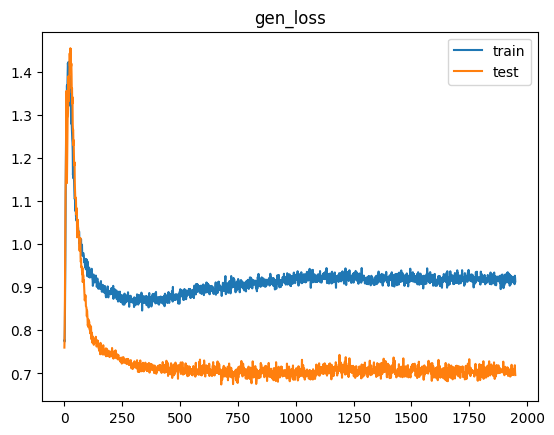

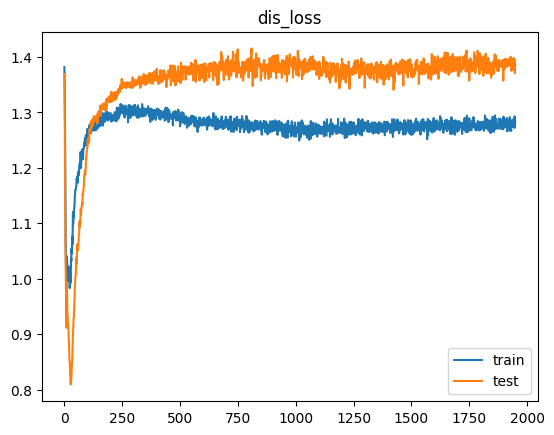

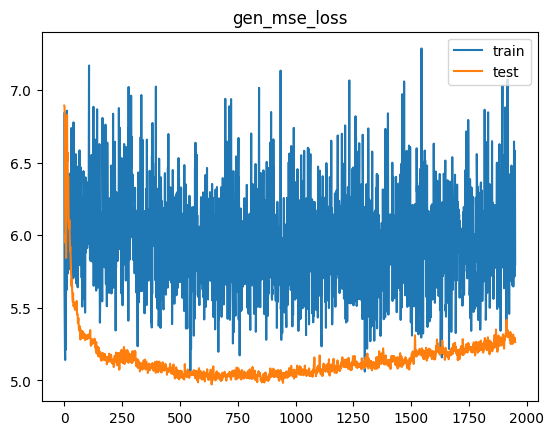

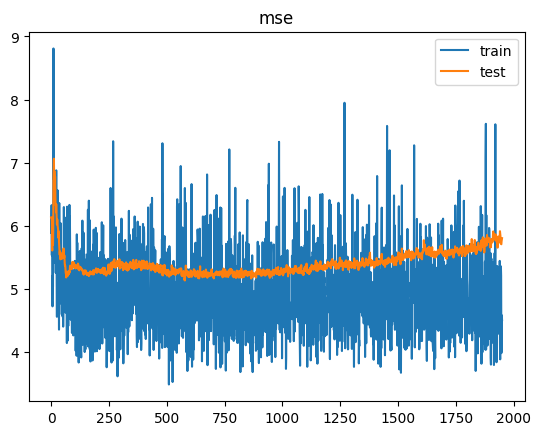

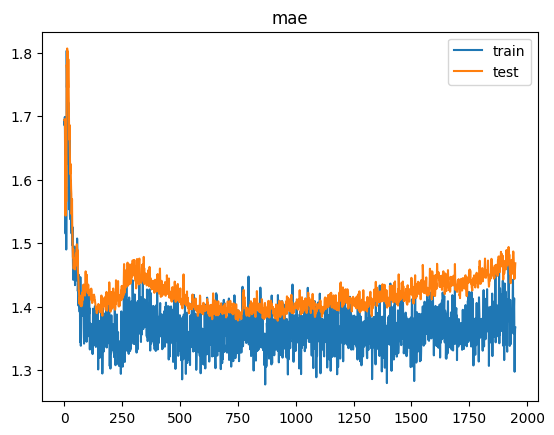

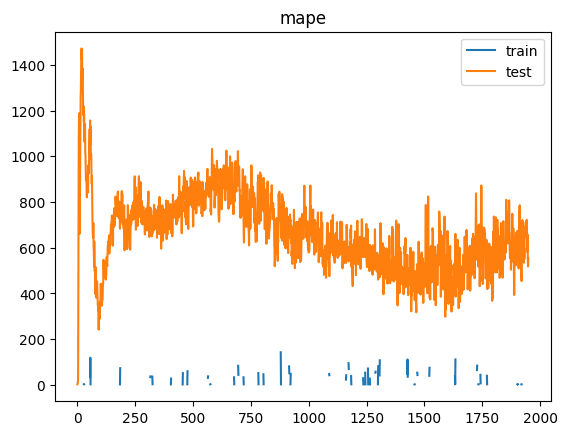

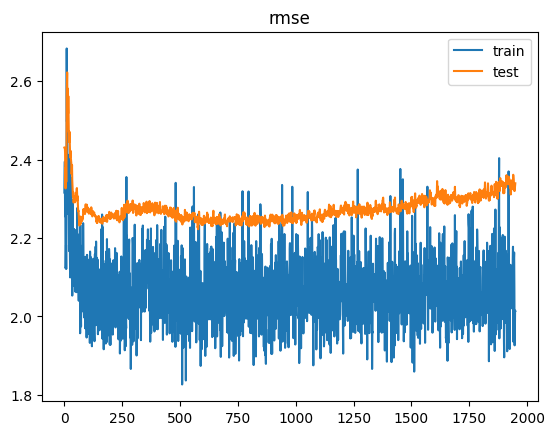

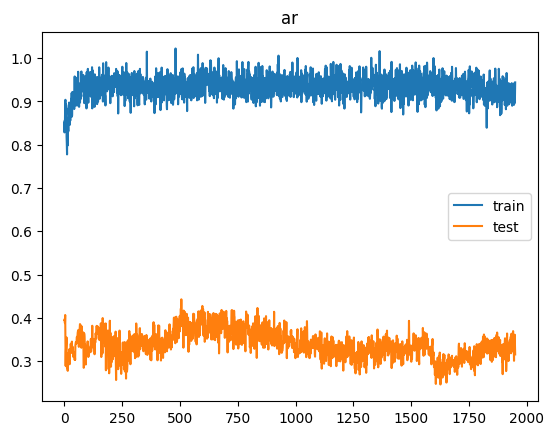

2/2 [==============================] - 0s 5ms/step


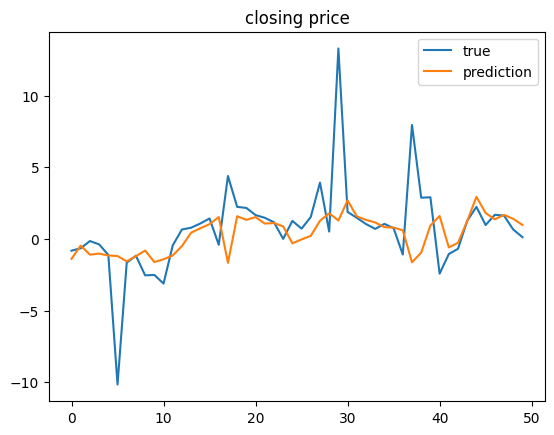

[MSE Baseline] train: 4.9348336637346  test: 5.001280720763628
Delta time with epochs = 1950: 0:39:24.527599


In [22]:
for epochs in [1700, 1950]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("lstm_ffnn_epochs_{0}.h5".format(epochs))